# Multi-Objective Fairness Analysis

This notebook implements multi-objective hyperparameter optimization for fairness-aware machine learning, exploring the trade-off between **accuracy** and **counterfactual consistency** (individual fairness).

## Overview

**Two Approaches:**
1. **Approach 1**: Models trained WITH sensitive features — evaluate counterfactual consistency by flipping sensitive attributes directly
2. **Approach 2**: Models trained WITHOUT sensitive features — evaluate consistency using proxy features

**Models:** Random Forest, MLP, SenSeI (optional)

**Sensitive Features Analyzed:** Sex (binary), Race (multiclass)

## 0. Setup & Configuration

This section initializes the notebook environment, imports required modules, and defines configuration variables and helper functions used throughout the analysis.

### 0.1 Imports & Module Reload

In [61]:
# ============================================================================
# 0.1 IMPORTS & MODULE RELOAD
# ============================================================================

# Add src to path
import sys
sys.path.insert(0, '../src')

import warnings
warnings.filterwarnings('ignore')

# For development: reload modules to pick up changes
import importlib
datasets = importlib.import_module("utils.datasets")
importlib.reload(datasets)
plotting = importlib.import_module("utils.plotting")
importlib.reload(plotting)
main = importlib.import_module("main")
importlib.reload(main)

# --- Core Imports ---
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Any
from IPython.display import Image, display
from sklearn.model_selection import train_test_split  

# --- Project Imports ---
from main import (
    run_optimization,
    get_dataset_config,
    get_configspace,
    list_available_datasets,
    get_pareto_front,
    print_pareto_summary,
    create_rf_model,
    create_mlp_model,
)

from utils.plotting import (
    plot_pareto_comparison,
    plot_parallel_coordinates,
    plot_mds_projection,
    generate_all_visualizations,
    compute_fairness_confusion_matrix,
    plot_fairness_confusion_matrix,
    print_fairness_confusion_summary,
)

from utils.datasets import load_dataset, create_flipped_data

print("✅ All modules imported successfully!")
print(f"Available datasets: {list_available_datasets()}")

✅ All modules imported successfully!
Available datasets: ['adult', 'german_credit', 'compas']


### 0.2 Configuration

Global configuration variables for the analysis. Modify these to change:
- Dataset and output paths
- Data split ratios
- SMAC optimization settings
- Caching behavior

In [ ]:
# ============================================================================
# 0.2 CONFIGURATION
# ============================================================================

# Dataset
DATASET_NAME = "adult"

# Output directories
OUTPUT_DIR = "../plots"
CACHE_DIR = "../cache"

# Data split settings
TEST_SIZE = 0.2   # 20% for final evaluation
VAL_SIZE = 0.25   # 25% of remaining = 20% of total for validation
RANDOM_STATE = 42

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/notebook", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/latex", exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

print("✅ Configuration loaded!")
print(f"   Dataset: {DATASET_NAME}")

✅ Configuration loaded!
   Dataset: adult
   Load from cache: True


### 0.3 Caching Utilities

Caching mechanism for SMAC optimization results. This allows re-running analysis without repeating time-consuming optimization:

- **`LOAD_FROM_CACHE = True`**: Load previously saved results
- **`LOAD_FROM_CACHE = False`**: Run fresh optimization and save results

Cached results are stored in the `cache/` directory as pickle files.

In [63]:
# ============================================================================
# 0.3 CACHING UTILITIES
# ============================================================================

@dataclass
class CachedConfig:
    """Simple wrapper to mimic ConfigSpace Configuration."""
    values: Dict[str, Any]
    
    def __getitem__(self, key):
        return self.values[key]
    
    def keys(self):
        return self.values.keys()
    
    def __iter__(self):
        return iter(self.values)
    
    def items(self):
        return self.values.items()


class CachedRunHistory:
    """Mock runhistory that provides the same interface as SMAC's runhistory."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self._configs = [CachedConfig(c) for c in configs]
        self._costs = {i: cost for i, cost in enumerate(costs)}
    
    def get_configs(self):
        return self._configs
    
    def average_cost(self, config):
        idx = self._configs.index(config)
        return self._costs[idx]


class CachedSMAC:
    """Mock SMAC facade that provides the same interface for visualization."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self.runhistory = CachedRunHistory(configs, costs)


def save_smac_results(results: Dict, dataset_name: str, sensitive_feature: str, approach: int = 1):
    """Save SMAC results to cache."""
    cache_data = {}
    
    for model_type, smac in results.items():
        configs = smac.runhistory.get_configs()
        configs_as_dicts = [dict(c) for c in configs]
        costs = [smac.runhistory.average_cost(c) for c in configs]
        
        cache_data[model_type] = {
            'configs': configs_as_dicts,
            'costs': costs,
        }
    
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"✅ Results cached to: {cache_file}")
    return cache_file


def load_smac_results(dataset_name: str, sensitive_feature: str, approach: int = 1) -> Dict:
    """Load SMAC results from cache."""
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    
    if not os.path.exists(cache_file):
        raise FileNotFoundError(f"Cache file not found: {cache_file}\nRun optimization first with LOAD_FROM_CACHE=False")
    
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
    
    results = {}
    for model_type, data in cache_data.items():
        results[model_type] = CachedSMAC(data['configs'], data['costs'])
    
    print(f"✅ Results loaded from cache: {cache_file}")
    return results


print("✅ Caching utilities loaded!")

✅ Caching utilities loaded!


### 0.4 Helper Functions

Reusable functions for data processing, analysis, and visualization. These are used across both Approach 1 and Approach 2 sections.

In [103]:
# ============================================================================
# 0.4 HELPER FUNCTIONS
# ============================================================================

def split_data(data, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    """Split data into train/validation/test sets."""
    X_full = data['X_train'].copy()
    y_full = data['y_train'].copy()
    
    # Split off test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_full, y_full, test_size=test_size, random_state=random_state, stratify=y_full
    )
    
    # Split remaining into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )
    
    # Update data dict
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_val'] = X_val
    data['y_val'] = y_val
    data['X_test'] = X_test
    data['y_test'] = y_test
    
    print(f"Data split: Train={len(X_train):,}, Val={len(X_val):,}, Test={len(X_test):,}")
    return data


def plot_sensitive_distribution(data, dataset_name, sensitive_feature):
    """
    Plot the distribution of sensitive feature(s) vs target variable with disparity analysis.
    
    Parameters:
    -----------
    data : dict
        Data dictionary containing X_train, y_train, and sensitive feature info
    dataset_name : str
        Name of the dataset (e.g., 'adult')
    sensitive_feature : str
        Name of the sensitive feature (e.g., 'sex', 'race')
    """
    X_train = data['X_train']
    y_train = data['y_train']
    
    # Determine if binary or multiclass based on which keys exist
    is_multiclass = 'sensitive_col_indices' in data
    
    # Get target label names (customize based on dataset)
    target_names = {0: 'Income ≤50K', 1: 'Income >50K'} if dataset_name == 'adult' else {0: 'Class 0', 1: 'Class 1'}
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if is_multiclass:
        # Multiclass sensitive feature (e.g., race)
        sens_indices = data['sensitive_col_indices']
        sens_names = data.get('sensitive_col_names', [f'Cat_{i}' for i in range(len(sens_indices))])
        n_categories = len(sens_names)
        
        # Determine which category each sample belongs to
        categories = np.argmax(X_train[:, sens_indices], axis=1)
        
        # Count samples per category and target
        category_target_counts = {}
        for cat_idx, cat_name in enumerate(sens_names):
            mask = (categories == cat_idx)
            pos_count = (y_train[mask] == 1).sum()
            neg_count = (y_train[mask] == 0).sum()
            category_target_counts[cat_name] = {'positive': pos_count, 'negative': neg_count, 'total': mask.sum()}
        
        # Plot 1: Stacked bar chart (absolute counts)
        cat_names = list(category_target_counts.keys())
        pos_counts = [category_target_counts[c]['positive'] for c in cat_names]
        neg_counts = [category_target_counts[c]['negative'] for c in cat_names]
        
        x = np.arange(len(cat_names))
        width = 0.6
        
        bars1 = axes[0].bar(x, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
        bars2 = axes[0].bar(x, pos_counts, width, bottom=neg_counts, label=target_names[1], color='#e74c3c', alpha=0.8)
        
        axes[0].set_xlabel(f'Sensitive Feature: {sensitive_feature.title()}', fontsize=11)
        axes[0].set_ylabel('Count', fontsize=11)
        axes[0].set_title('Distribution by Sensitive Group (Absolute)', fontsize=12, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(cat_names, rotation=45, ha='right')
        axes[0].legend()
        
        # Add count labels
        for i, (neg, pos) in enumerate(zip(neg_counts, pos_counts)):
            axes[0].annotate(f'{neg+pos:,}', (i, neg+pos+50), ha='center', fontsize=9)
        
        # Plot 2: Base rate (percentage positive) per group
        base_rates = [100 * category_target_counts[c]['positive'] / category_target_counts[c]['total'] 
                      for c in cat_names]
        
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(cat_names)))
        bars = axes[1].bar(x, base_rates, width, color=colors, edgecolor='black', linewidth=0.5)
        
        axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                        label=f'Overall rate: {100*y_train.mean():.1f}%')
        axes[1].set_xlabel(f'Sensitive Feature: {sensitive_feature.title()}', fontsize=11)
        axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
        axes[1].set_title('Base Rate Disparity (% Positive Outcome)', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(cat_names, rotation=45, ha='right')
        axes[1].legend()
        axes[1].set_ylim(0, max(base_rates) * 1.2)
        
        # Add percentage labels
        for i, rate in enumerate(base_rates):
            axes[1].annotate(f'{rate:.1f}%', (i, rate + 1), ha='center', fontsize=10, fontweight='bold')
        
        # For summary
        grp_names = cat_names
        counts = category_target_counts
        sens_name = sensitive_feature

    else:
        # Binary sensitive feature (e.g., sex)
        sens_idx = data['sensitive_col_idx']
        sens_name = data.get('sensitive_col_name', sensitive_feature)
        
        # Get group labels (customize based on feature)
        if 'sex' in sensitive_feature.lower():
            group_names = {0: 'Female', 1: 'Male'}
        else:
            group_names = {0: f'{sens_name}=0', 1: f'{sens_name}=1'}
        
        # Count samples per group and target
        group0_mask = (X_train[:, sens_idx] == 0)
        group1_mask = (X_train[:, sens_idx] == 1)
        
        counts = {
            group_names[0]: {'positive': int((y_train[group0_mask] == 1).sum()), 
                             'negative': int((y_train[group0_mask] == 0).sum()),
                             'total': int(group0_mask.sum())},
            group_names[1]: {'positive': int((y_train[group1_mask] == 1).sum()), 
                             'negative': int((y_train[group1_mask] == 0).sum()),
                             'total': int(group1_mask.sum())}
        }
        
        # Plot 1: Grouped bar chart
        grp_names = list(counts.keys())
        x = np.arange(len(grp_names))
        width = 0.35
        
        neg_counts = [counts[g]['negative'] for g in grp_names]
        pos_counts = [counts[g]['positive'] for g in grp_names]
        
        bars1 = axes[0].bar(x - width/2, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
        bars2 = axes[0].bar(x + width/2, pos_counts, width, label=target_names[1], color='#e74c3c', alpha=0.8)
        
        axes[0].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
        axes[0].set_ylabel('Count', fontsize=11)
        axes[0].set_title('Distribution by Sensitive Group', fontsize=12, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(grp_names)
        axes[0].legend()
        
        # Add count labels
        for bar in bars1:
            axes[0].annotate(f'{int(bar.get_height()):,}', 
                             (bar.get_x() + bar.get_width()/2, bar.get_height()),
                             ha='center', va='bottom', fontsize=9)
        for bar in bars2:
            axes[0].annotate(f'{int(bar.get_height()):,}', 
                             (bar.get_x() + bar.get_width()/2, bar.get_height()),
                             ha='center', va='bottom', fontsize=9)
        
        # Plot 2: Base rate comparison
        base_rates = [100 * counts[g]['positive'] / counts[g]['total'] for g in grp_names]
        
        colors = ['#9b59b6', '#1abc9c']
        bars = axes[1].bar(x, base_rates, width=0.5, color=colors, edgecolor='black', linewidth=1)
        
        axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                        label=f'Overall rate: {100*y_train.mean():.1f}%')
        axes[1].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
        axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
        axes[1].set_title('Base Rate Disparity', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(grp_names)
        axes[1].legend()
        axes[1].set_ylim(0, max(base_rates) * 1.3)
        
        # Add percentage labels
        for i, rate in enumerate(base_rates):
            axes[1].annotate(f'{rate:.1f}%', (i, rate + 1.5), ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DISTRIBUTION SUMMARY")
    print("="*60)
    
    if is_multiclass:
        print(f"\nSensitive Feature: {sensitive_feature} ({n_categories} categories)")
    else:
        print(f"\nSensitive Feature: {sens_name}")
    
    print(f"{'Group':<15} {'Count':>10} {'% of Data':>12} {'Base Rate':>12}")
    print("-"*50)
    for grp_name in grp_names:
        c = counts[grp_name]
        pct_data = 100 * c['total'] / len(y_train)
        base_rate = 100 * c['positive'] / c['total']
        print(f"{grp_name:<15} {c['total']:>10,} {pct_data:>11.1f}% {base_rate:>11.1f}%")
    
    print("-"*50)
    print(f"{'OVERALL':<15} {len(y_train):>10,} {'100.0%':>12} {100*y_train.mean():>11.1f}%")
    
    # Calculate disparity
    rates = [counts[g]['positive'] / counts[g]['total'] for g in grp_names]
    disparity_ratio = max(rates) / min(rates)
    disparity_diff = 100 * (max(rates) - min(rates))
    
    print(f"\n📊 Disparity Analysis:")
    print(f"   • Highest base rate: {100*max(rates):.1f}%")
    print(f"   • Lowest base rate:  {100*min(rates):.1f}%")
    print(f"   • Disparity ratio:   {disparity_ratio:.2f}x")
    print(f"   • Absolute gap:      {disparity_diff:.1f} percentage points")


def run_smac_optimization(data, dataset_name, sensitive_feature, load_from_cache=True,
                          walltime_limit=300, n_trials=100):
    """
    Run SMAC optimization or load from cache.
    
    Parameters:
    -----------
    data : dict
        Data dictionary with X_train, y_train, X_val, y_val
    dataset_name : str
        Name of the dataset
    sensitive_feature : str
        Name of the sensitive feature
    load_from_cache : bool
        Whether to try loading from cache first
    walltime_limit : int
        Time limit for optimization in seconds
    n_trials : int
        Number of trials for optimization
        
    Returns:
    --------
    dict : Results dictionary with 'rf' and 'mlp' SMAC objects
    """
    results = None
    
    if load_from_cache:
        print(f"Loading results from cache for {dataset_name}/{sensitive_feature}...")
        results = load_smac_results(dataset_name, sensitive_feature, approach=1)
        if results is not None:
            print(f"✓ Loaded from cache!")
            return results
        else:
            print("⚠️  Cache not found! Running optimization...")
    
    print(f"Running SMAC optimization for {dataset_name}/{sensitive_feature}...")
    results = {}
    
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()} (Sensitive: {sensitive_feature})...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data,
            walltime_limit=walltime_limit,
            n_trials=n_trials,
            output_dir=f"../smac_output/{dataset_name}_{sensitive_feature}"
        )
        results[model_type] = smac
    
    print("\n" + "="*60)
    print("✓ Optimization complete!")
    print("="*60)
    
    # Save results to cache
    save_smac_results(results, dataset_name, sensitive_feature, approach=1)
    
    return results


def get_optimization_stats(smac, model_name):
    """Extract statistics from SMAC optimization run."""
    runhistory = smac.runhistory
    
    # Number of configurations evaluated
    n_configs = len(runhistory.get_configs())
    
    # Get Pareto front size
    pareto_configs, pareto_costs = get_pareto_front(smac)
    n_incumbents = len(pareto_configs)
    
    # Calculate total time and average time per config
    total_time = 0
    for key, value in runhistory.items():
        if value.time is not None:
            total_time += value.time
    
    avg_time = total_time / n_configs if n_configs > 0 else 0
    
    return {
        'Model': model_name.upper(),
        'Configs Evaluated': n_configs,
        'Pareto Front Size': n_incumbents,
        'Total Time (s)': f"{total_time:.1f}",
        'Avg Time/Config (s)': f"{avg_time:.2f}",
    }


def print_optimization_summary(results, dataset_name, sensitive_feature):
    """Print optimization summary table and insights."""
    import pandas as pd
    
    # Build summary table
    summary_data = []
    for model_type, smac in results.items():
        stats = get_optimization_stats(smac, model_type)
        summary_data.append(stats)
    
    summary_df = pd.DataFrame(summary_data)
    
    print("=" * 70)
    print(f"OPTIMIZATION SUMMARY: {dataset_name.upper()} / {sensitive_feature.upper()}")
    print("=" * 70)
    display(summary_df)
    
    # Additional insights
    print("\n" + "=" * 70)
    print("PARETO EFFICIENCY")
    print("=" * 70)
    for model_type, smac in results.items():
        n_configs = len(smac.runhistory.get_configs())
        pareto_configs, _ = get_pareto_front(smac)
        pareto_pct = len(pareto_configs) / n_configs * 100 if n_configs > 0 else 0
        print(f"{model_type.upper()}: {len(pareto_configs)}/{n_configs} configs are Pareto-optimal ({pareto_pct:.1f}%)")


def plot_and_display_pareto(results, dataset_name, sensitive_feature, output_dir):
    """Generate and display Pareto comparison plot."""
    pareto_filename = f"pareto_{dataset_name}_{sensitive_feature}.png"
    pareto_paths = plot_pareto_comparison(
        results, 
        output_dir=output_dir,
        filename=pareto_filename,
        formats=["notebook", "latex"]
    )
    
    # Display the notebook version
    display(Image(filename=pareto_paths["notebook"]))
    
    return pareto_paths


def plot_parallel_coords_both_models(results, dataset_name, sensitive_feature, output_dir):
    """
    Generate and display parallel coordinate plots for both RF and MLP.
    
    Returns dict with paths to all generated plots.
    """
    paths = {}
    
    for model_type in ['rf', 'mlp']:
        if model_type not in results:
            continue
            
        filename = f"parallel_coords_{dataset_name}_{sensitive_feature}_{model_type}.png"
        model_paths = plot_parallel_coordinates(
            results[model_type], 
            model_type,
            get_configspace_fn=get_configspace,
            output_dir=output_dir,
            filename=filename,
            color_by='error',
            formats=["notebook", "latex"]
        )
        
        print(f"\n{model_type.upper()} - Parallel Coordinate Plot:")
        display(Image(filename=model_paths["notebook"]))
        
        paths[model_type] = model_paths
    
    return paths

def plot_mds_both_models(results, dataset_name, sensitive_feature, output_dir):
    """
    Generate and display MDS projection plots for both RF and MLP.
    
    Returns dict with paths to all generated plots.
    """
    paths = {}
    
    for model_type in ['rf', 'mlp']:
        if model_type not in results:
            continue
            
        filename = f"mds_projection_{dataset_name}_{sensitive_feature}_{model_type}.png"
        model_paths = plot_mds_projection(
            results[model_type], 
            model_type,
            get_configspace_fn=get_configspace,
            output_dir=output_dir,
            filename=filename,
            formats=["notebook", "latex"]
        )
        
        print(f"\n{model_type.upper()} - MDS Projection:")
        display(Image(filename=model_paths["notebook"]))
        
        paths[model_type] = model_paths
    
    return paths
# Add more helper functions here as needed...

def analyze_fairness_confusion_matrix(results, data, dataset_name, sensitive_feature, output_dir):
    """
    Analyze fairness-accuracy confusion matrix for best-accuracy configs.
    
    Trains models on training set, evaluates on validation set.
    
    Returns dict with FCM results and plot paths for each model.
    """
    is_multiclass = 'sensitive_col_indices' in data
    all_results = {}
    
    for model_type in ["rf", "mlp"]:
        if model_type not in results:
            continue
            
        print(f"\n{'='*70}")
        print(f"Analyzing {model_type.upper()} - Best Accuracy Configuration")
        print(f"{'='*70}")
        
        # Get best accuracy config from Pareto front
        configs, costs = get_pareto_front(results[model_type])
        best_acc_idx = np.argmin(costs[:, 0])  # Lowest error = best accuracy
        best_config = configs[best_acc_idx]
        
        print(f"Accuracy: {1 - costs[best_acc_idx, 0]:.4f}")
        print(f"Consistency: {1 - costs[best_acc_idx, 1]:.4f}")
        
        # Create and train the model on TRAINING set
        if model_type == "rf":
            model = create_rf_model(best_config)
        else:
            model = create_mlp_model(best_config)
        
        model.fit(data['X_train'], data['y_train'])
        
        # Compute fairness confusion matrix on VALIDATION set
        if is_multiclass:
            fcm_results = compute_fairness_confusion_matrix(
                model, data['X_val'], data['y_val'],
                sensitive_col_indices=data['sensitive_col_indices'],
                is_multiclass=True
            )
        else:
            fcm_results = compute_fairness_confusion_matrix(
                model, data['X_val'], data['y_val'],
                sensitive_col_idx=data['sensitive_col_idx'],
                is_multiclass=False
            )
        
        # Print summary
        print_fairness_confusion_summary(fcm_results, f"{model_type.upper()} (Best Accuracy)")
        
        # Plot and save
        fcm_paths = plot_fairness_confusion_matrix(
            fcm_results,
            model_name=f"{model_type.upper()} (Best Accuracy)",
            output_dir=output_dir,
            filename=f"fairness_confusion_{dataset_name}_{sensitive_feature}_{model_type}_best_acc.png",
            formats=["notebook", "latex"]
        )
        
        # Display
        display(Image(filename=fcm_paths["notebook"]))
        
        all_results[model_type] = {
            'config': best_config,
            'accuracy': 1 - costs[best_acc_idx, 0],
            'consistency': 1 - costs[best_acc_idx, 1],
            'fcm': fcm_results,
            'paths': fcm_paths
        }
    
    return all_results

def analyze_trivial_fairness(results, data, model_type='mlp'):
    """
    Investigate potentially degenerate 'trivially fair' configurations.
    
    Compares the fairest config with ReLU activation to diagnose vanishing gradients.
    
    Parameters:
    -----------
    results : dict
        SMAC results dictionary
    data : dict
        Data dictionary with X_train, y_train, X_val, y_val
    model_type : str
        Model type to analyze (default: 'mlp')
    
    Returns:
    --------
    dict with analysis results
    """
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import balanced_accuracy_score
    
    if model_type not in results:
        print(f"No {model_type} results found.")
        return None
    
    # Get the fairest MLP config from Pareto front
    configs, costs = get_pareto_front(results[model_type])
    best_fair_idx = np.argmin(costs[:, 1])  # Lowest inconsistency
    fair_config = configs[best_fair_idx]
    
    print("="*70)
    print("TRIVIALLY FAIR MLP ANALYSIS")
    print("="*70)
    
    # Check if this is actually a degenerate case
    accuracy = 1 - costs[best_fair_idx, 0]
    consistency = 1 - costs[best_fair_idx, 1]
    
    print(f"\nFairest configuration from Pareto front:")
    print(f"  Accuracy: {accuracy:.1%}")
    print(f"  Consistency: {consistency:.1%}")
    
    if accuracy > 0.6:
        print(f"\n✓ This config has reasonable accuracy ({accuracy:.1%}).")
        print(f"  Not a degenerate 'trivial fairness' case.")
        return {'is_degenerate': False, 'accuracy': accuracy, 'consistency': consistency}
    
    # Build config dict for sklearn
    fairest_config = {
        'hidden_layer_sizes': tuple([fair_config["n_neurons"]] * fair_config["n_hidden_layers"]),
        'activation': fair_config["activation"],
        'solver': fair_config["solver"],
        'alpha': fair_config["alpha"],
        'learning_rate_init': fair_config["learning_rate_init"],
        'max_iter': 500,
        'early_stopping': True,
        'random_state': 42
    }
    
    print(f"\nConfiguration: {fair_config['activation']} activation, {fair_config['solver']} solver")
    print(f"Learning rate: {fair_config['learning_rate_init']:.4f}, Alpha: {fair_config['alpha']:.4f}")
    
    # Get data splits
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    
    # Train with original config
    model_original = MLPClassifier(**fairest_config)
    model_original.fit(X_train, y_train)
    y_pred_original = model_original.predict(X_val)
    acc_original = balanced_accuracy_score(y_val, y_pred_original)
    
    print(f"\n--- With {fair_config['activation'].upper()} activation ---")
    print(f"Unique predictions: {np.unique(y_pred_original)}", end="")
    if len(np.unique(y_pred_original)) == 1:
        print(" → Predicts only ONE class!")
    else:
        print(" → Predicts both classes")
    print(f"Balanced Accuracy: {acc_original:.1%}")
    print(f"Training iterations: {model_original.n_iter_}")
    
    # Test with ReLU as a fix
    relu_config = fairest_config.copy()
    relu_config['activation'] = 'relu'
    
    model_relu = MLPClassifier(**relu_config)
    model_relu.fit(X_train, y_train)
    y_pred_relu = model_relu.predict(X_val)
    acc_relu = balanced_accuracy_score(y_val, y_pred_relu)
    
    print(f"\n--- With ReLU activation (same other params) ---")
    print(f"Unique predictions: {np.unique(y_pred_relu)}", end="")
    if len(np.unique(y_pred_relu)) == 1:
        print(" → Predicts only ONE class!")
    else:
        print(" → Predicts both classes")
    print(f"Balanced Accuracy: {acc_relu:.1%}")
    print(f"Training iterations: {model_relu.n_iter_}")
    
    # Conclusion
    print(f"\n" + "="*70)
    print("CONCLUSION:")
    print("="*70)
    
    if acc_relu > acc_original + 0.1:
        print(f"→ {fair_config['activation'].title()} activation caused vanishing gradients")
        print(f"→ Network never learned → constant predictions → 'trivial' 100% fairness")
        print(f"→ ReLU fixes this: accuracy improves from {acc_original:.1%} to {acc_relu:.1%}")
        print(f"\n⚠️  High fairness + low accuracy = likely a degenerate solution!")
    else:
        print(f"→ Activation function doesn't appear to be the issue")
        print(f"→ May be caused by other hyperparameters (alpha, learning rate)")
    
    return {
        'is_degenerate': len(np.unique(y_pred_original)) == 1,
        'original_activation': fair_config['activation'],
        'acc_original': acc_original,
        'acc_relu': acc_relu,
        'config': fair_config
    }

def setup_case_study_analysis(results, data, dataset_name, sensitive_feature):
    """
    Setup for case study analysis: train models and compute counterfactual predictions.
    
    Returns a dict with all computed values needed for case studies.
    """
    from utils.datasets import create_flipped_data
    
    # Get best accuracy configs from Pareto front
    rf_configs, rf_costs = get_pareto_front(results['rf'])
    mlp_configs, mlp_costs = get_pareto_front(results['mlp'])
    
    rf_best_acc_idx = np.argmin(rf_costs[:, 0])
    mlp_best_acc_idx = np.argmin(mlp_costs[:, 0])
    
    rf_config = rf_configs[rf_best_acc_idx]
    mlp_config = mlp_configs[mlp_best_acc_idx]
    
    print("Selected Models (Best Accuracy from Pareto Front):")
    print(f"  RF:  Accuracy={1-rf_costs[rf_best_acc_idx, 0]:.4f}, Consistency={1-rf_costs[rf_best_acc_idx, 1]:.4f}")
    print(f"  MLP: Accuracy={1-mlp_costs[mlp_best_acc_idx, 0]:.4f}, Consistency={1-mlp_costs[mlp_best_acc_idx, 1]:.4f}")
    
    # Create and train models on TRAINING set
    rf_model = create_rf_model(rf_config)
    mlp_model = create_mlp_model(mlp_config)
    
    rf_model.fit(data['X_train'], data['y_train'])
    mlp_model.fit(data['X_train'], data['y_train'])
    
    # Use VALIDATION set for analysis
    X_val = data['X_val']
    y_val = data['y_val']
    
    # Original predictions and probabilities
    rf_pred_orig = rf_model.predict(X_val)
    rf_proba_orig = rf_model.predict_proba(X_val)[:, 1]
    mlp_pred_orig = mlp_model.predict(X_val)
    mlp_proba_orig = mlp_model.predict_proba(X_val)[:, 1]
    
    # Determine if multiclass
    is_multiclass = 'sensitive_col_indices' in data
    
    # Initialize result dict
    cs = {
        'rf_model': rf_model,
        'mlp_model': mlp_model,
        'X_val': X_val,
        'y_val': y_val,
        'rf_pred_orig': rf_pred_orig,
        'rf_proba_orig': rf_proba_orig,
        'mlp_pred_orig': mlp_pred_orig,
        'mlp_proba_orig': mlp_proba_orig,
        'is_multiclass': is_multiclass,
        'sensitive_feature': sensitive_feature,
    }
    
    if is_multiclass:
        from utils.datasets import create_flipped_data_multiclass_exhaustive
        flipped_versions, original_categories = create_flipped_data_multiclass_exhaustive(
            X_val, data['sensitive_col_indices']
        )
        n_categories = len(data['sensitive_col_indices'])
        sens_names = data['sensitive_col_names']
        
        # Compute predictions for ALL flipped versions
        rf_preds_flipped = [rf_model.predict(fv) for fv in flipped_versions]
        rf_probas_flipped = [rf_model.predict_proba(fv)[:, 1] for fv in flipped_versions]
        mlp_preds_flipped = [mlp_model.predict(fv) for fv in flipped_versions]
        mlp_probas_flipped = [mlp_model.predict_proba(fv)[:, 1] for fv in flipped_versions]
        
        # Compute TRUE multiclass consistency
        rf_inconsistent = np.zeros(len(X_val), dtype=bool)
        mlp_inconsistent = np.zeros(len(X_val), dtype=bool)
        
        for target_cat in range(n_categories):
            is_actual_flip = (original_categories != target_cat)
            rf_inconsistent |= (is_actual_flip & (rf_pred_orig != rf_preds_flipped[target_cat]))
            mlp_inconsistent |= (is_actual_flip & (mlp_pred_orig != mlp_preds_flipped[target_cat]))
        
        # Probability analysis
        rf_proba_changes = np.array([np.abs(rf_probas_flipped[i] - rf_proba_orig) for i in range(n_categories)])
        mlp_proba_changes = np.array([np.abs(mlp_probas_flipped[i] - mlp_proba_orig) for i in range(n_categories)])
        
        rf_proba_change = rf_proba_changes.max(axis=0)
        mlp_proba_change = mlp_proba_changes.max(axis=0)
        rf_max_flip_target = rf_proba_changes.argmax(axis=0)
        mlp_max_flip_target = mlp_proba_changes.argmax(axis=0)
        
        cs.update({
            'original_categories': original_categories,
            'n_categories': n_categories,
            'sens_names': sens_names,
            'rf_preds_flipped': rf_preds_flipped,
            'rf_probas_flipped': rf_probas_flipped,
            'mlp_preds_flipped': mlp_preds_flipped,
            'mlp_probas_flipped': mlp_probas_flipped,
            'rf_max_flip_target': rf_max_flip_target,
            'mlp_max_flip_target': mlp_max_flip_target,
        })
        
        print(f"\nUsing MULTICLASS counterfactual ({n_categories} categories)")
        print(f"Categories: {sens_names}")
        
    else:
        # Binary case
        X_val_flipped = create_flipped_data(X_val, data['sensitive_col_idx'])
        
        rf_pred_flip = rf_model.predict(X_val_flipped)
        rf_proba_flip = rf_model.predict_proba(X_val_flipped)[:, 1]
        mlp_pred_flip = mlp_model.predict(X_val_flipped)
        mlp_proba_flip = mlp_model.predict_proba(X_val_flipped)[:, 1]
        
        rf_inconsistent = rf_pred_orig != rf_pred_flip
        mlp_inconsistent = mlp_pred_orig != mlp_pred_flip
        rf_proba_change = np.abs(rf_proba_flip - rf_proba_orig)
        mlp_proba_change = np.abs(mlp_proba_flip - mlp_proba_orig)
        
        cs.update({
            'X_val_flipped': X_val_flipped,
            'rf_pred_flip': rf_pred_flip,
            'rf_proba_flip': rf_proba_flip,
            'mlp_pred_flip': mlp_pred_flip,
            'mlp_proba_flip': mlp_proba_flip,
            'sensitive_col_idx': data['sensitive_col_idx'],
            'sensitive_col_name': data.get('sensitive_col_name', sensitive_feature),
        })
        
        print(f"\nUsing BINARY counterfactual (feature: {sensitive_feature})")
    
    cs.update({
        'rf_inconsistent': rf_inconsistent,
        'mlp_inconsistent': mlp_inconsistent,
        'rf_proba_change': rf_proba_change,
        'mlp_proba_change': mlp_proba_change,
    })
    
    # Summary
    print(f"\n{'='*60}")
    print("Counterfactual Consistency on VALIDATION SET:")
    print(f"  RF:  {100*(1-rf_inconsistent.mean()):.1f}% consistent ({rf_inconsistent.sum():,} inconsistent)")
    print(f"  MLP: {100*(1-mlp_inconsistent.mean()):.1f}% consistent ({mlp_inconsistent.sum():,} inconsistent)")
    print(f"\n✓ These results match what SMAC optimized for!")
    
    return cs

def case_study_prediction_flip(cs):
    """
    CASE 1: Find the most extreme prediction flip when sensitive attribute changes.
    """
    X_val = cs['X_val']
    y_val = cs['y_val']
    is_multiclass = cs['is_multiclass']
    rf_inconsistent = cs['rf_inconsistent']
    rf_proba_orig = cs['rf_proba_orig']
    rf_pred_orig = cs['rf_pred_orig']
    rf_proba_change = cs['rf_proba_change']
    
    rf_flip_indices = np.where(rf_inconsistent)[0]
    
    print("="*70)
    print("CASE: Prediction FLIPS When Sensitive Attribute Changes (Most Extreme)")
    print("="*70)
    
    if len(rf_flip_indices) == 0:
        print("No prediction flips found! Model is perfectly consistent.")
        return
    
    flip_proba_changes = rf_proba_change[rf_flip_indices]
    most_extreme_local_idx = np.argmax(flip_proba_changes)
    idx = rf_flip_indices[most_extreme_local_idx]
    
    print(f"Sample {idx}: True label = {y_val[idx]}")
    
    if is_multiclass:
        orig_cat = cs['original_categories'][idx]
        target_cat = cs['rf_max_flip_target'][idx]
        sens_names = cs['sens_names']
        print(f"  Original ({sens_names[orig_cat]}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped to {sens_names[target_cat]}:  P(class=1) = {cs['rf_probas_flipped'][target_cat][idx]:.4f} → Pred = {cs['rf_preds_flipped'][target_cat][idx]}")
        print(f"  ΔP = {cs['rf_probas_flipped'][target_cat][idx] - rf_proba_orig[idx]:+.4f}")
        print(f"  Direction: {sens_names[orig_cat]} → {sens_names[target_cat]}")
    else:
        sens_name = cs['sensitive_col_name']
        orig_val = "1" if X_val[idx, cs['sensitive_col_idx']] == 1 else "0"
        flip_val = "0" if orig_val == "1" else "1"
        print(f"  Original ({sens_name}={orig_val}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped ({sens_name}={flip_val}):   P(class=1) = {cs['rf_proba_flip'][idx]:.4f} → Pred = {cs['rf_pred_flip'][idx]}")
        print(f"  ΔP = {cs['rf_proba_flip'][idx] - rf_proba_orig[idx]:+.4f}")


def case_study_consistent_sample(cs):
    """
    CASE 2: Find a high-confidence sample that stays consistent.
    """
    X_val = cs['X_val']
    y_val = cs['y_val']
    is_multiclass = cs['is_multiclass']
    rf_inconsistent = cs['rf_inconsistent']
    rf_proba_orig = cs['rf_proba_orig']
    rf_pred_orig = cs['rf_pred_orig']
    rf_proba_change = cs['rf_proba_change']
    
    rf_consistent_indices = np.where(~rf_inconsistent)[0]
    
    print("="*70)
    print("CASE: Prediction STAYS CONSISTENT (Robust to Change)")
    print("="*70)
    
    if len(rf_consistent_indices) == 0:
        print("No consistent samples found!")
        return
    
    consistent_proba = rf_proba_orig[rf_consistent_indices]
    high_conf_local_idx = np.argmax(np.abs(consistent_proba - 0.5))
    idx = rf_consistent_indices[high_conf_local_idx]
    
    print(f"Sample {idx}: True label = {y_val[idx]}")
    
    if is_multiclass:
        orig_cat = cs['original_categories'][idx]
        target_cat = cs['rf_max_flip_target'][idx]
        sens_names = cs['sens_names']
        print(f"  Original ({sens_names[orig_cat]}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Max change flip ({sens_names[target_cat]}): P(class=1) = {cs['rf_probas_flipped'][target_cat][idx]:.4f} → Pred = {cs['rf_preds_flipped'][target_cat][idx]}")
        print(f"  Max |ΔP| = {rf_proba_change[idx]:.4f} (prediction unchanged)")
        print(f"  ✓ Model robust across ALL {cs['n_categories']} categories")
    else:
        sens_name = cs['sensitive_col_name']
        sens_idx = cs['sensitive_col_idx']
        orig_val = int(X_val[idx, sens_idx])
        flip_val = 1 - orig_val
        print(f"  Original ({sens_name}={orig_val}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped ({sens_name}={flip_val}):   P(class=1) = {cs['rf_proba_flip'][idx]:.4f} → Pred = {cs['rf_pred_flip'][idx]}")
        print(f"  |ΔP| = {rf_proba_change[idx]:.4f} (prediction unchanged)")
        print(f"  ✓ Model relies on other features, not {sens_name}")


def case_study_edge_cases(cs):
    """
    CASE 3: Analyze samples near the decision boundary.
    """
    X_val = cs['X_val']
    is_multiclass = cs['is_multiclass']
    rf_inconsistent = cs['rf_inconsistent']
    rf_proba_orig = cs['rf_proba_orig']
    
    print("="*70)
    print("CASE: Edge Cases Near Decision Boundary")
    print("="*70)
    
    boundary_dist = np.abs(rf_proba_orig - 0.5)
    near_boundary = boundary_dist < 0.1
    
    n_near_boundary = near_boundary.sum()
    n_near_boundary_inconsistent = (near_boundary & rf_inconsistent).sum()
    
    print(f"Samples within 10% of boundary: {n_near_boundary:,}")
    print(f"Of these, inconsistent: {n_near_boundary_inconsistent:,}")
    
    if n_near_boundary > 0:
        boundary_inconsistency_rate = n_near_boundary_inconsistent / n_near_boundary
        overall_inconsistency_rate = rf_inconsistent.mean()
        
        print(f"Inconsistency rate near boundary: {100*boundary_inconsistency_rate:.1f}%")
        print(f"Inconsistency rate overall: {100*overall_inconsistency_rate:.1f}%")
        
        if overall_inconsistency_rate > 0:
            vulnerability_ratio = boundary_inconsistency_rate / overall_inconsistency_rate
            print(f"\n→ Edge cases are {vulnerability_ratio:.1f}x more vulnerable!")
        
        if is_multiclass:
            print(f"\n(Evaluated across all {cs['n_categories']} {cs['sensitive_feature']} categories)")
    
    print(f"\n✓ Analysis on VALIDATION set ({len(X_val):,} samples)")


def case_study_model_comparison(cs):
    """
    CASE 4: Compare RF vs MLP fairness behavior.
    """
    rf_inconsistent = cs['rf_inconsistent']
    mlp_inconsistent = cs['mlp_inconsistent']
    
    print("="*70)
    print("CASE: RF vs MLP - Different Models, Different Fairness")
    print("="*70)
    
    rf_only = rf_inconsistent & ~mlp_inconsistent
    mlp_only = ~rf_inconsistent & mlp_inconsistent
    both = rf_inconsistent & mlp_inconsistent
    neither = ~rf_inconsistent & ~mlp_inconsistent
    
    print(f"Only RF unfair:  {rf_only.sum():,}")
    print(f"Only MLP unfair: {mlp_only.sum():,}")
    print(f"Both unfair:     {both.sum():,}")
    print(f"Both fair:       {neither.sum():,}")
    print(f"\n→ Models can be unfair to DIFFERENT individuals!")


def case_study_probability_swings(cs):
    """
    CASE 5: Analyze largest probability swings with directional information.
    """
    X_val = cs['X_val']
    is_multiclass = cs['is_multiclass']
    rf_inconsistent = cs['rf_inconsistent']
    mlp_inconsistent = cs['mlp_inconsistent']
    rf_proba_orig = cs['rf_proba_orig']
    mlp_proba_orig = cs['mlp_proba_orig']
    rf_proba_change = cs['rf_proba_change']
    mlp_proba_change = cs['mlp_proba_change']
    
    print("="*70)
    print("CASE: Largest Probability Swings")
    print("="*70)
    
    rf_max_idx = np.argmax(rf_proba_change)
    mlp_max_idx = np.argmax(mlp_proba_change)
    
    if is_multiclass:
        sens_names = cs['sens_names']
        rf_target_cat = cs['rf_max_flip_target'][rf_max_idx]
        mlp_target_cat = cs['mlp_max_flip_target'][mlp_max_idx]
        rf_orig_cat = cs['original_categories'][rf_max_idx]
        mlp_orig_cat = cs['original_categories'][mlp_max_idx]
        
        print(f"RF  max swing: Sample {rf_max_idx}")
        print(f"    Direction: {sens_names[rf_orig_cat]} → {sens_names[rf_target_cat]}")
        print(f"    P: {rf_proba_orig[rf_max_idx]:.4f} → {cs['rf_probas_flipped'][rf_target_cat][rf_max_idx]:.4f} (Δ={rf_proba_change[rf_max_idx]:.4f})")
        print(f"    Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")
        
        print(f"\nMLP max swing: Sample {mlp_max_idx}")
        print(f"    Direction: {sens_names[mlp_orig_cat]} → {sens_names[mlp_target_cat]}")
        print(f"    P: {mlp_proba_orig[mlp_max_idx]:.4f} → {cs['mlp_probas_flipped'][mlp_target_cat][mlp_max_idx]:.4f} (Δ={mlp_proba_change[mlp_max_idx]:.4f})")
        print(f"    Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")
    else:
        print(f"RF  max swing: Sample {rf_max_idx}")
        print(f"    P: {rf_proba_orig[rf_max_idx]:.4f} → {cs['rf_proba_flip'][rf_max_idx]:.4f} (Δ={rf_proba_change[rf_max_idx]:.4f})")
        print(f"    Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")
        
        print(f"\nMLP max swing: Sample {mlp_max_idx}")
        print(f"    P: {mlp_proba_orig[mlp_max_idx]:.4f} → {cs['mlp_proba_flip'][mlp_max_idx]:.4f} (Δ={mlp_proba_change[mlp_max_idx]:.4f})")
        print(f"    Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")
    
    print(f"\n→ Even without flipping, large ΔP indicates sensitivity to protected attribute!")


def case_study_directional_analysis(cs):
    """
    CASE 6: Aggregate directional analysis of probability changes.
    """
    X_val = cs['X_val']
    is_multiclass = cs['is_multiclass']
    rf_proba_orig = cs['rf_proba_orig']
    mlp_proba_orig = cs['mlp_proba_orig']
    rf_proba_change = cs['rf_proba_change']
    mlp_proba_change = cs['mlp_proba_change']
    
    print("="*70)
    print("CASE: Aggregate Directional Analysis")
    print("="*70)
    
    if is_multiclass:
        rf_signed_change = np.array([
            cs['rf_probas_flipped'][cs['rf_max_flip_target'][i]][i] - rf_proba_orig[i] 
            for i in range(len(rf_proba_orig))
        ])
        mlp_signed_change = np.array([
            cs['mlp_probas_flipped'][cs['mlp_max_flip_target'][i]][i] - mlp_proba_orig[i] 
            for i in range(len(mlp_proba_orig))
        ])
        
        print(f"\nOverall Average Probability Changes:")
        print(f"  RF:  Mean ΔP = {rf_signed_change.mean():+.4f}, Mean |ΔP| = {rf_proba_change.mean():.4f}")
        print(f"  MLP: Mean ΔP = {mlp_signed_change.mean():+.4f}, Mean |ΔP| = {mlp_proba_change.mean():.4f}")
        
        sens_names = cs['sens_names']
        original_categories = cs['original_categories']
        
        print(f"\nRF breakdown by original {cs['sensitive_feature']}:")
        for cat_idx, cat_name in enumerate(sens_names):
            mask = original_categories == cat_idx
            if mask.sum() > 0:
                mean_signed = rf_signed_change[mask].mean()
                mean_abs = rf_proba_change[mask].mean()
                direction = "↑" if mean_signed > 0 else "↓"
                print(f"  {cat_name:<20}: Mean ΔP = {mean_signed:+.4f} {direction}, |ΔP| = {mean_abs:.4f} (n={mask.sum():,})")
        
        print(f"\nMLP breakdown by original {cs['sensitive_feature']}:")
        for cat_idx, cat_name in enumerate(sens_names):
            mask = original_categories == cat_idx
            if mask.sum() > 0:
                mean_signed = mlp_signed_change[mask].mean()
                mean_abs = mlp_proba_change[mask].mean()
                direction = "↑" if mean_signed > 0 else "↓"
                print(f"  {cat_name:<20}: Mean ΔP = {mean_signed:+.4f} {direction}, |ΔP| = {mean_abs:.4f} (n={mask.sum():,})")
    
    else:
        rf_signed_change = cs['rf_proba_flip'] - rf_proba_orig
        mlp_signed_change = cs['mlp_proba_flip'] - mlp_proba_orig
        
        print(f"\nOverall Average Probability Changes:")
        print(f"  RF:  Mean ΔP = {rf_signed_change.mean():+.4f}, Mean |ΔP| = {rf_proba_change.mean():.4f}")
        print(f"  MLP: Mean ΔP = {mlp_signed_change.mean():+.4f}, Mean |ΔP| = {mlp_proba_change.mean():.4f}")
        print(f"  (positive ΔP = flipping 0→1 INCREASES probability on average)")
        
        sens_idx = cs['sensitive_col_idx']
        sens_name = cs['sensitive_col_name']
        orig_vals = X_val[:, sens_idx]
        
        mask_0 = orig_vals == 0
        mask_1 = orig_vals == 1
        
        print(f"\nRF breakdown by original {sens_name}:")
        print(f"  {sens_name}=0 → 1: Mean ΔP = {rf_signed_change[mask_0].mean():+.4f}, |ΔP| = {rf_proba_change[mask_0].mean():.4f} (n={mask_0.sum():,})")
        print(f"  {sens_name}=1 → 0: Mean ΔP = {rf_signed_change[mask_1].mean():+.4f}, |ΔP| = {rf_proba_change[mask_1].mean():.4f} (n={mask_1.sum():,})")
        
        print(f"\nMLP breakdown by original {sens_name}:")
        print(f"  {sens_name}=0 → 1: Mean ΔP = {mlp_signed_change[mask_0].mean():+.4f}, |ΔP| = {mlp_proba_change[mask_0].mean():.4f} (n={mask_0.sum():,})")
        print(f"  {sens_name}=1 → 0: Mean ΔP = {mlp_signed_change[mask_1].mean():+.4f}, |ΔP| = {mlp_proba_change[mask_1].mean():.4f} (n={mask_1.sum():,})")
    
    print(f"\n✓ Analysis on VALIDATION set ({len(X_val):,} samples)")


print("✅ Helper functions loaded!")

✅ Helper functions loaded!


## Approach 1: Models WITH Sensitive Features

In this approach, we train standard ML models (Random Forest, MLP) **with sensitive features included** in the training data. Fairness is evaluated using **counterfactual consistency**: does the prediction change when we flip the sensitive attribute?

### Sensitive Features Analyzed

| Feature | Type | Counterfactual Method |
|---------|------|----------------------|
| **Sex** | Binary | Flip 0↔1 (e.g., Female↔Male) |
| **Race** | Multiclass (5 categories) | Exhaustive flip to all other categories |

For multiclass, a sample is **inconsistent** if the prediction changes for *any* flip — the strictest definition of individual fairness.

### Objectives

| Objective | Description | Goal |
|-----------|-------------|------|
| **Accuracy** | Balanced accuracy on validation set | Maximize |
| **Fairness** | Counterfactual consistency (prediction unchanged when flipping sensitive attribute) | Maximize |

### Analysis Pipeline

For each sensitive feature (Sex, Race):
1. **Load & Split Data** — Train/Validation/Test split
2. **Data Exploration** — Distribution of outcomes by sensitive group
3. **SMAC Optimization** — Multi-objective hyperparameter search
4. **Pareto Front Analysis** — Trade-off between accuracy and fairness
5. **Case Studies** — Sample-level fairness analysis
6. **Fairness Confusion Matrix** — Joint analysis of correctness and consistency

### Visualizations
- **Pareto Front** — Trade-off curves between accuracy and fairness
- **Parallel Coordinates** — How hyperparameters affect both objectives  
- **MDS Projection** — 2D view of the hyperparameter search space
- **Counterfactual Scatter** — Original vs flipped probabilities
- **Fairness Confusion Matrix** — Correct/Incorrect × Consistent/Inconsistent

### 1.1 Analysis: Sex (Binary Sensitive Feature)

First, we analyze fairness with respect to **sex** — a binary sensitive attribute.
- **Counterfactual method**: Simple flip (Female ↔ Male)
- **Consistency definition**: Prediction unchanged after flip

#### Code: 1.1.1 Load Data & Split (Sex)


In [66]:
# ============================================================================
# 1.1.1 LOAD DATA & SPLIT - SEX (Binary)
# ============================================================================

SENSITIVE_FEATURE_SEX = "sex"

# Load dataset
data_sex = load_dataset(DATASET_NAME, SENSITIVE_FEATURE_SEX)

# Apply train/val/test split
data_sex = split_data(data_sex)  # Uses helper function from Section 0

print(f"\n{'='*60}")
print(f"DATASET: {DATASET_NAME} | SENSITIVE FEATURE: {SENSITIVE_FEATURE_SEX}")
print(f"{'='*60}")
print(f"  Train:      {len(data_sex['X_train']):,}")
print(f"  Validation: {len(data_sex['X_val']):,}")
print(f"  Test:       {len(data_sex['X_test']):,}")
print(f"  Type: BINARY (single column flip)")

Loading Adult Income from OpenML (ID: 179)...
APPROACH 1: Keeping sensitive features in training
  Sensitive feature for counterfactual: sex
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Binary sensitive feature: sex_Male (index 46)

Final features (62): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 1):
  Samples: 45222, Features: 62
  Positive class ratio: 24.78%
Data split: Train=27,132, Val=9,045, Test=9,045

DATASET: adult | SENSITIVE FEATURE: sex
  Train:      27,132
  Validation: 9,045
  Test:       9,045
  Type: BINARY (single column flip)


#### 1.1.2 Data Exploration: Sex Distribution

Understanding the distribution of outcomes across sensitive groups is crucial for fairness analysis. 
We examine:

1. **Base rate disparity** — Are positive outcomes distributed equally across sensitive groups?
2. **Sample sizes** — How many samples per sensitive group?
3. **Class imbalance** — Is there imbalance within each sensitive group?

These distributions reveal potential historical biases in the data that models may learn and amplify.

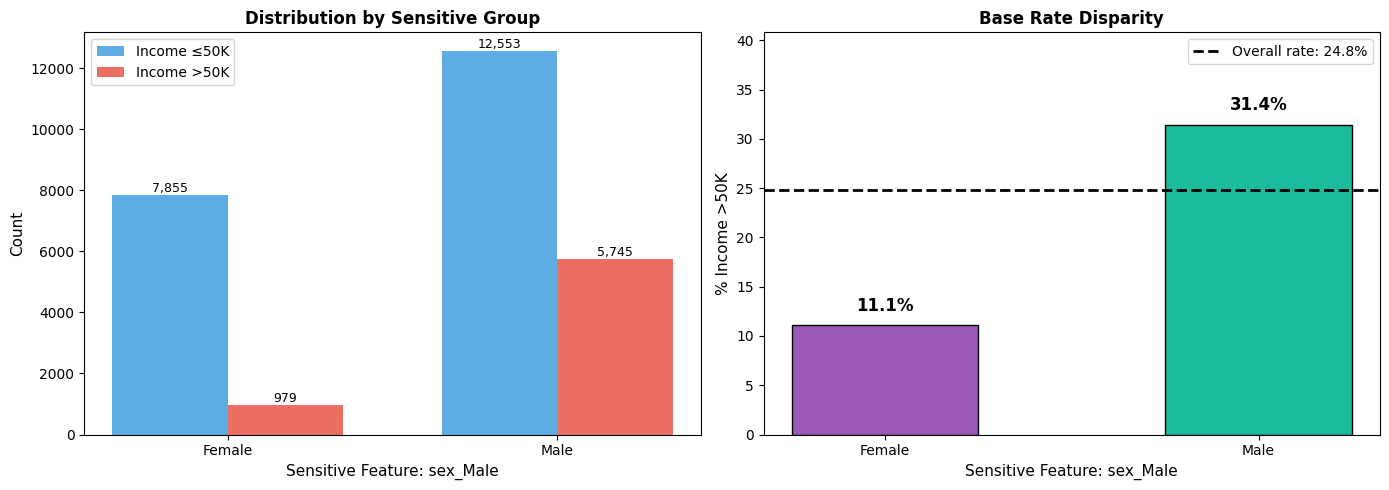


DISTRIBUTION SUMMARY

Sensitive Feature: sex_Male
Group                Count    % of Data    Base Rate
--------------------------------------------------
Female               8,834        32.6%        11.1%
Male                18,298        67.4%        31.4%
--------------------------------------------------
OVERALL             27,132       100.0%        24.8%

📊 Disparity Analysis:
   • Highest base rate: 31.4%
   • Lowest base rate:  11.1%
   • Disparity ratio:   2.83x
   • Absolute gap:      20.3 percentage points


In [71]:
# ============================================================================
# 1.1.2 DATA EXPLORATION - SEX
# ============================================================================

plot_sensitive_distribution(data_sex, DATASET_NAME, SENSITIVE_FEATURE_SEX)

### 1.1.3 Multi-Objective Optimization (Sex)

Run SMAC (Sequential Model-based Algorithm Configuration) to find Pareto-optimal hyperparameter configurations that balance **accuracy** and **counterfactual consistency** with respect to the **sex** sensitive feature.

**Objectives:**
- Minimize classification error (maximize balanced accuracy)
- Minimize counterfactual inconsistency (maximize consistency when flipping sex)

**Note:** Results are cached to avoid re-running time-consuming optimization.

In [75]:
# SMAC settings
WALLTIME_LIMIT = 60  # seconds per model
N_TRIALS = 100        # max configurations per model

# Caching
LOAD_FROM_CACHE = False  # Set to False to re-run optimization

In [76]:
%%time
# ============================================================================
# 1.1.3 SMAC OPTIMIZATION - SEX
# ============================================================================

results_sex = run_smac_optimization(
    data=data_sex,
    dataset_name=DATASET_NAME,
    sensitive_feature=SENSITIVE_FEATURE_SEX,
    load_from_cache=LOAD_FROM_CACHE,
    walltime_limit=WALLTIME_LIMIT,
    n_trials=N_TRIALS
)

Running SMAC optimization for adult/sex...

Optimizing RF (Sensitive: sex)...

Running SMAC optimization for RF (Approach 1)
Training samples: 27,132
Validation samples: 9,045
Using BINARY counterfactual (single column flip)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config 5b18e1 is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config af4b72 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:604] Config ac98cb 

### 1.1.4 Results & Visualization (Sex)

#### Pareto Front Analysis

The Pareto front shows the optimal trade-off between accuracy and counterfactual consistency when **sex** is the sensitive attribute.

- **X-axis**: Balanced Accuracy (higher = better predictions)
- **Y-axis**: Counterfactual Consistency (higher = fairer w.r.t. sex)
- **Pareto-optimal points**: Connected by dashed lines
- **Dominated points**: Lighter colored, suboptimal configurations

A configuration is Pareto-optimal if no other configuration is better in both objectives simultaneously.

In [78]:
# ============================================================================
# 1.1.4a OPTIMIZATION SUMMARY - SEX
# ============================================================================

print_optimization_summary(results_sex, DATASET_NAME, SENSITIVE_FEATURE_SEX)

OPTIMIZATION SUMMARY: ADULT / SEX


Model  Configs Evaluated  Pareto Front Size Total Time (s)  \
0    RF                 34                  5           21.2   
1   MLP                 14                  4           59.5   

  Avg Time/Config (s)  
0                0.62  
1                4.25


PARETO EFFICIENCY
RF: 5/34 configs are Pareto-optimal (14.7%)
MLP: 4/14 configs are Pareto-optimal (28.6%)


In [79]:
# ============================================================================
# 1.1.4b PARETO FRONT DETAILS - SEX
# ============================================================================

print(f"\n{'='*70}")
print(f"PARETO-OPTIMAL CONFIGURATIONS: {DATASET_NAME.upper()} / {SENSITIVE_FEATURE_SEX.upper()}")
print(f"{'='*70}\n")

print_pareto_summary(results_sex)


PARETO-OPTIMAL CONFIGURATIONS: ADULT / SEX


PARETO FRONT SUMMARY

RF Pareto Front (5 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7721, Consistency=0.9906
  Config 2: Accuracy=0.7625, Consistency=0.9989
  Config 3: Accuracy=0.7466, Consistency=0.9996
  Config 4: Accuracy=0.7371, Consistency=0.9997
  Config 5: Accuracy=0.7315, Consistency=1.0000

  Best Accuracy: 0.7721 (Consistency: 0.9906)
  Best Consistency: 1.0000 (Accuracy: 0.7315)

MLP Pareto Front (4 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7984, Consistency=0.9055
  Config 2: Accuracy=0.7977, Consistency=0.9595
  Config 3: Accuracy=0.7896, Consistency=0.9676
  Config 4: Accuracy=0.5000, Consistency=1.0000

  Best Accuracy: 0.7984 (Consistency: 0.9055)
  Best Consistency: 1.0000 (Accuracy: 0.5000)


[notebook] Pareto plot saved to: ../plots/notebook/pareto_adult_sex.png
[latex] Pareto plot saved to: ../plots/latex/pareto_adult_sex.png


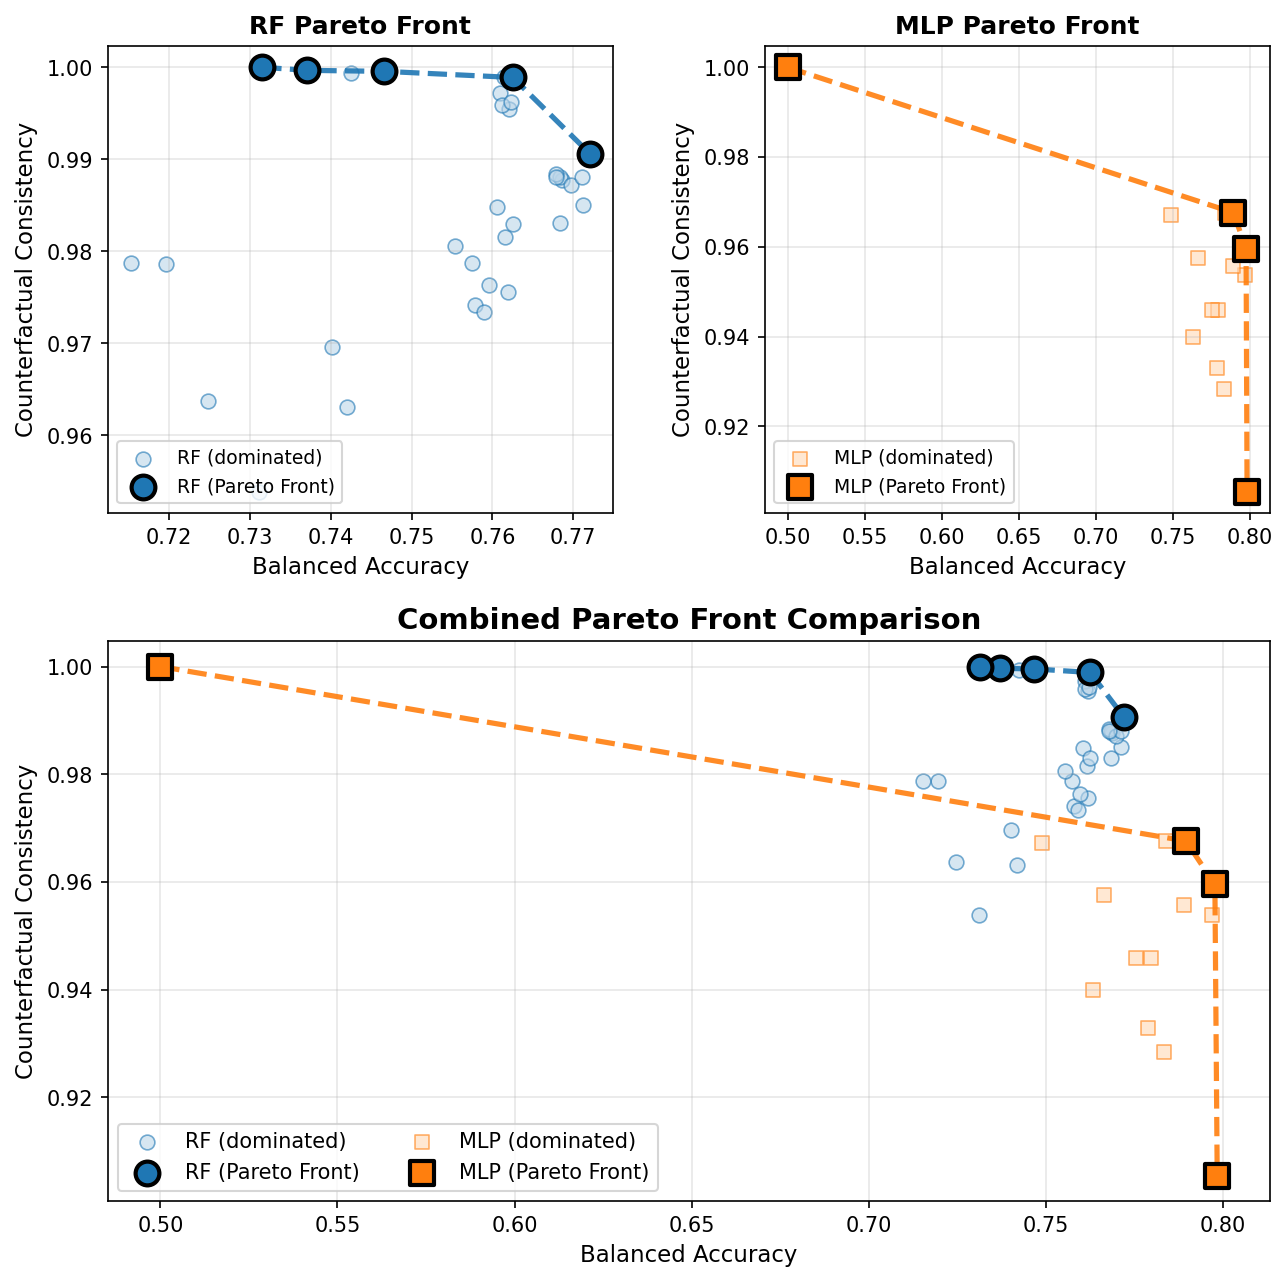

In [80]:
# ============================================================================
# 1.1.4c PARETO FRONT VISUALIZATION - SEX
# ============================================================================

pareto_paths_sex = plot_and_display_pareto(
    results_sex, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_SEX, 
    OUTPUT_DIR
)

#### Parallel Coordinate Plots (Sex)

Parallel coordinate plots visualize how hyperparameter configurations map to objective values.

| Element | Meaning |
|---------|---------|
| **Vertical axes** | Hyperparameters and objectives |
| **Lines** | Individual configurations |
| **Bold lines** | Pareto-optimal configurations |
| **Faint lines** | Dominated configurations |
| **Color** | Performance (green = better, red = worse) |

**Key insights:**
- Identify which hyperparameter ranges lead to better trade-offs
- Spot correlations between hyperparameters and objectives
- Assess diversity of the explored configuration space

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_sex_rf.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_sex_rf.png

RF - Parallel Coordinate Plot:


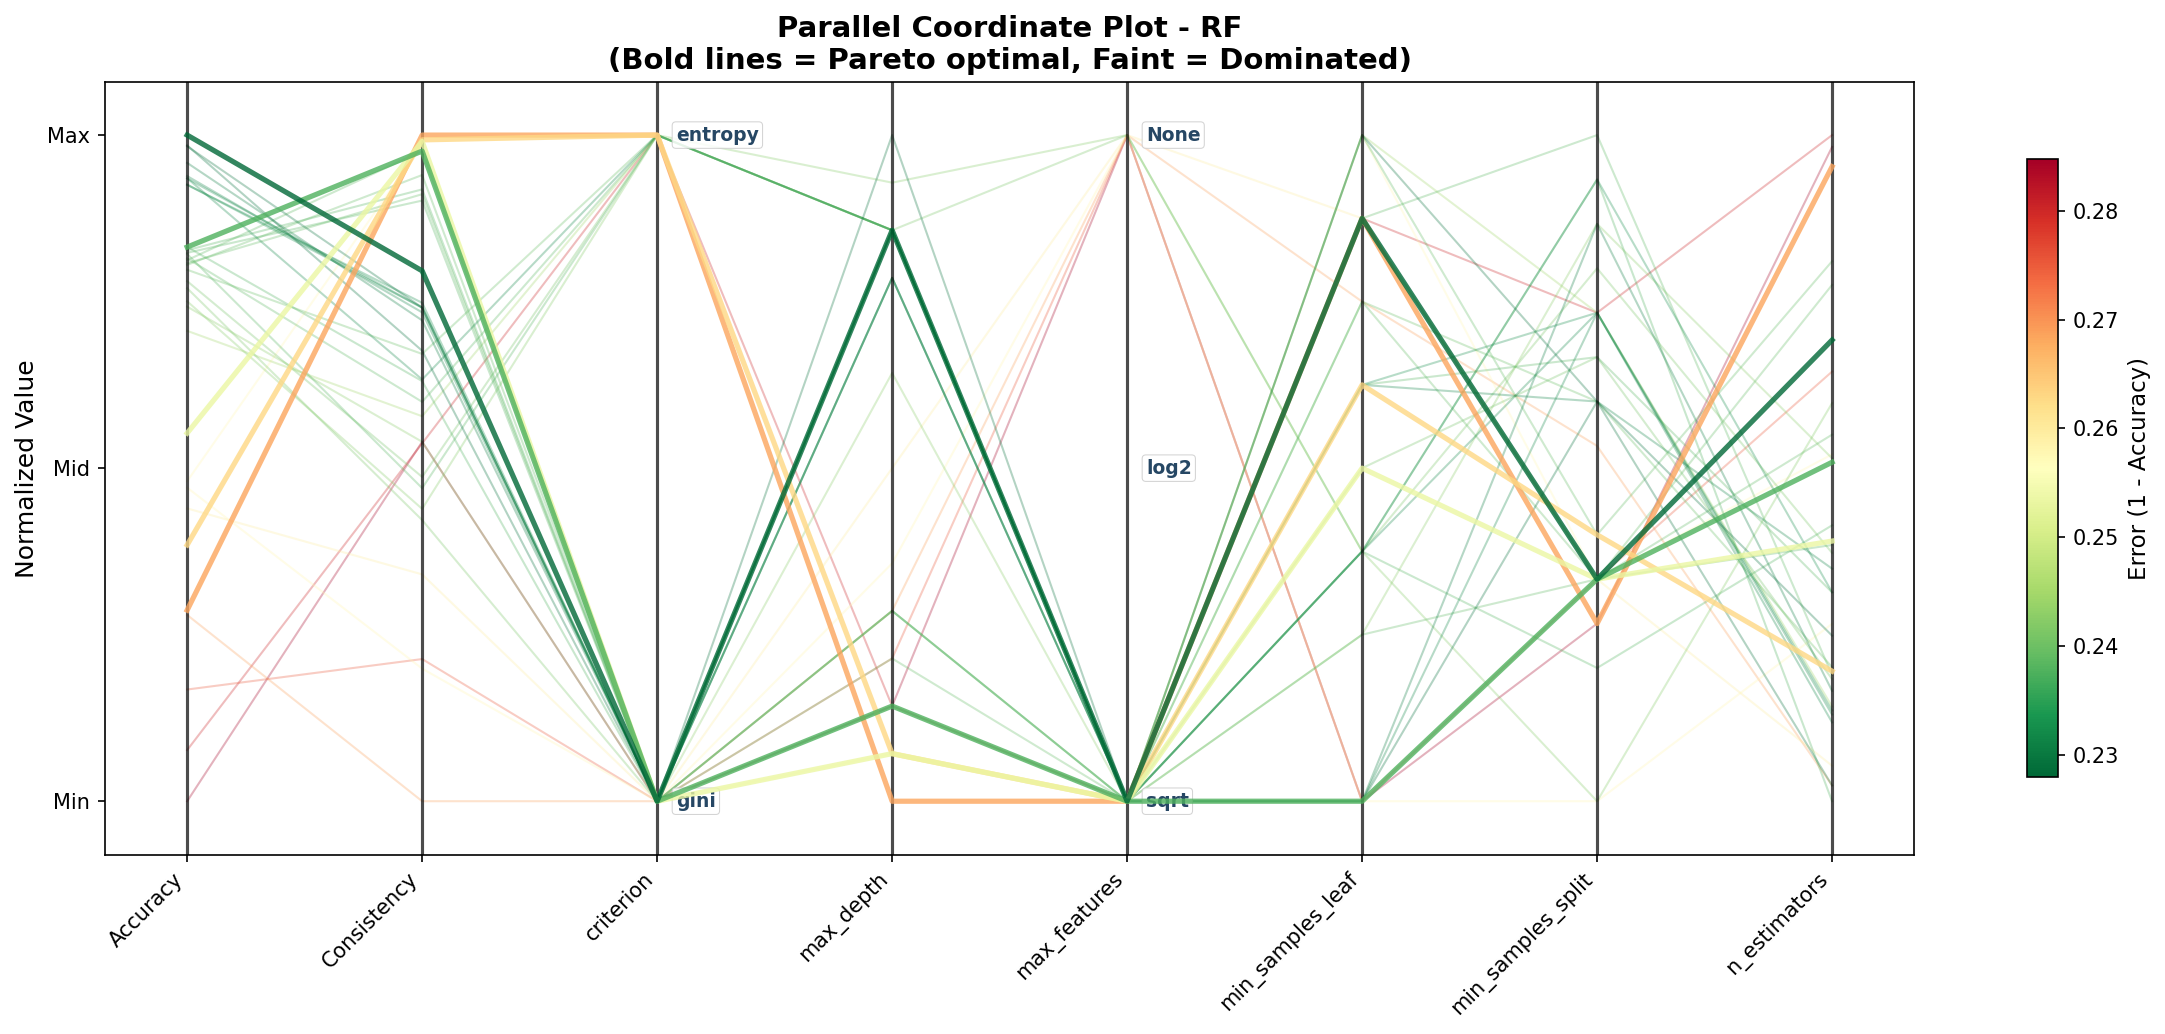

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_sex_mlp.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_sex_mlp.png

MLP - Parallel Coordinate Plot:


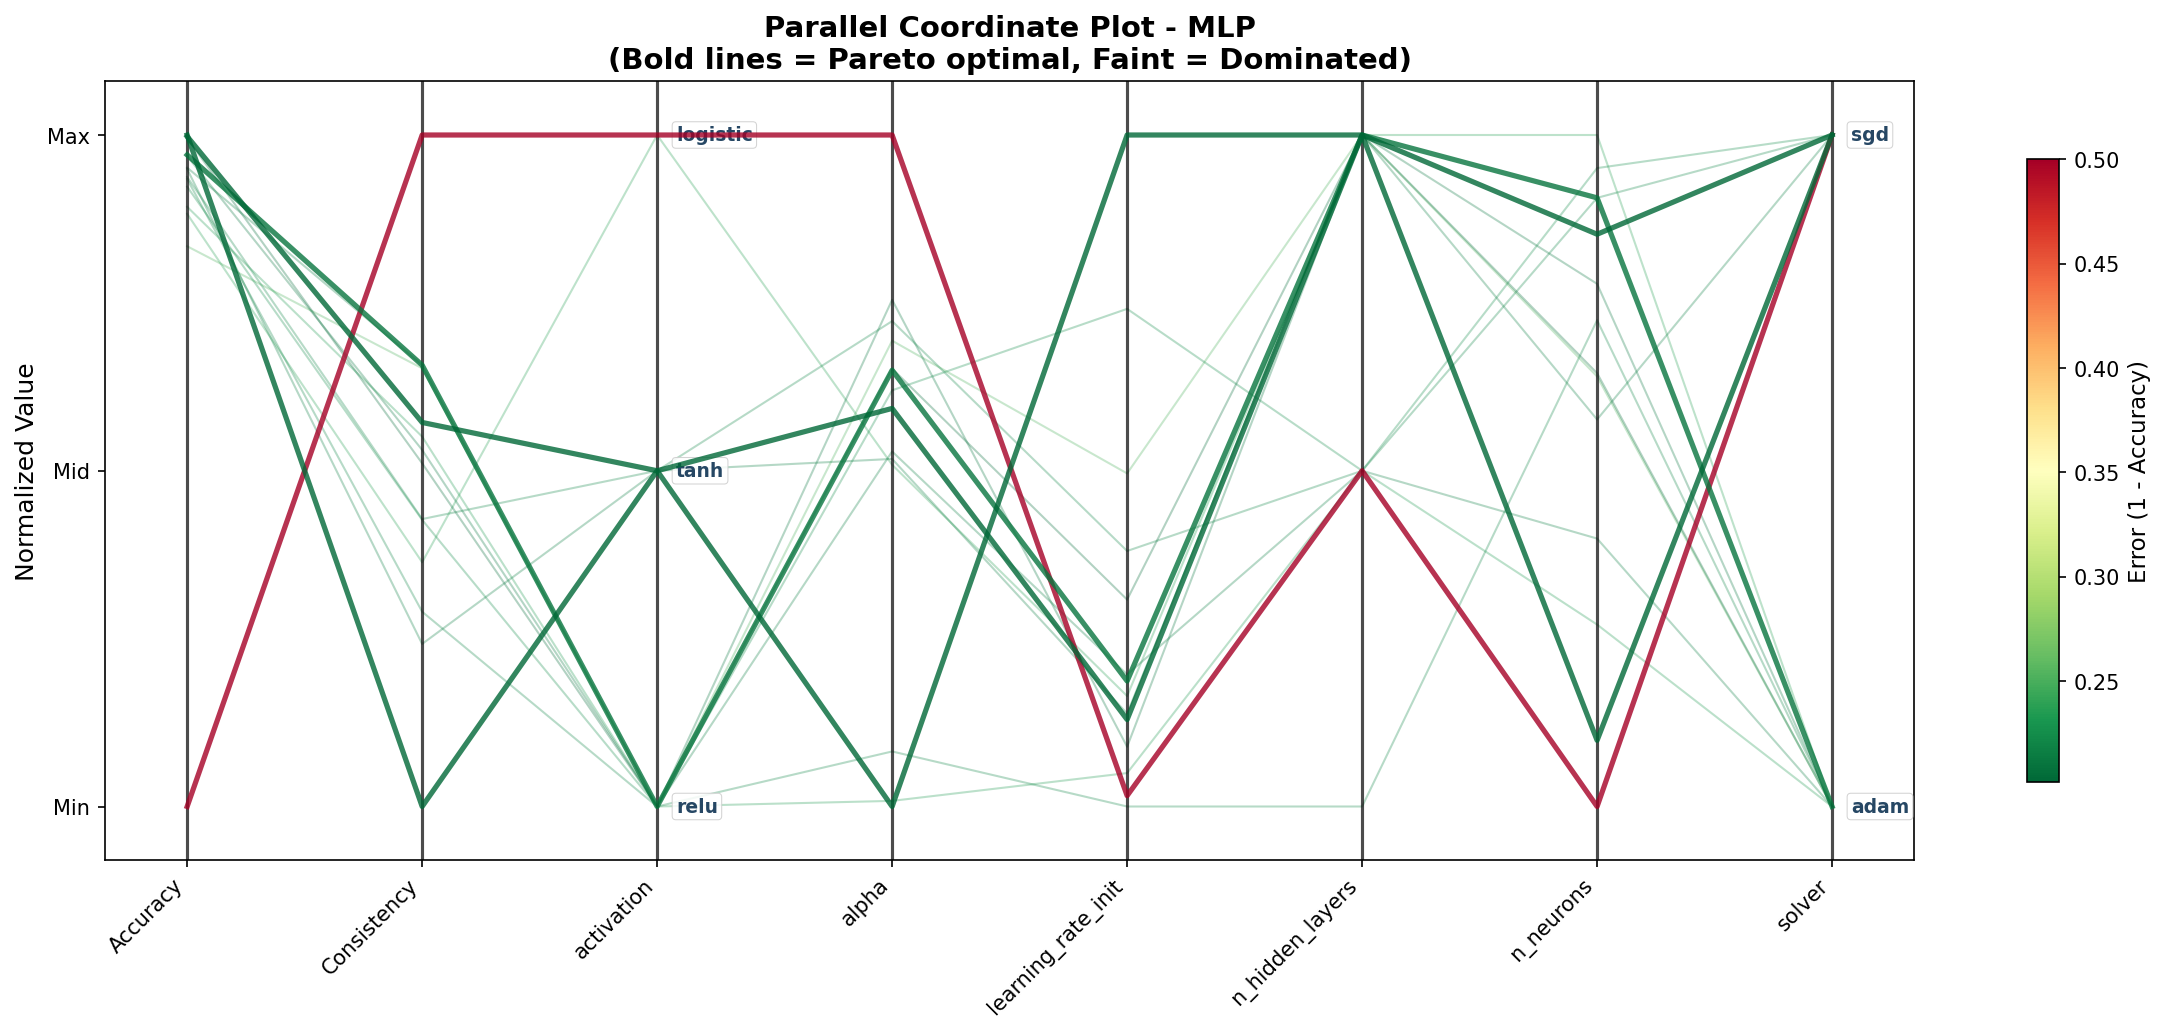

In [82]:
# ============================================================================
# 1.1.4d PARALLEL COORDINATE PLOTS - SEX
# ============================================================================

parallel_paths_sex = plot_parallel_coords_both_models(
    results_sex, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_SEX, 
    OUTPUT_DIR
)

#### MDS Projection (Sex)

Multidimensional Scaling (MDS) projects the high-dimensional hyperparameter space into 2D while preserving pairwise distances between configurations.

| Element | Meaning |
|---------|---------|
| **Points** | Hyperparameter configurations |
| **Distance** | Similarity in hyperparameter values |
| **Background color** | Interpolated performance surface |
| **Red squares** | Pareto-optimal configurations |
| **White circles** | Non-Pareto configurations |

**Key insights:**
- Identify clusters of similar configurations
- See if high-performing configs are localized or spread out
- Understand the performance landscape structure

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_sex_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_sex_rf.png

RF - MDS Projection:


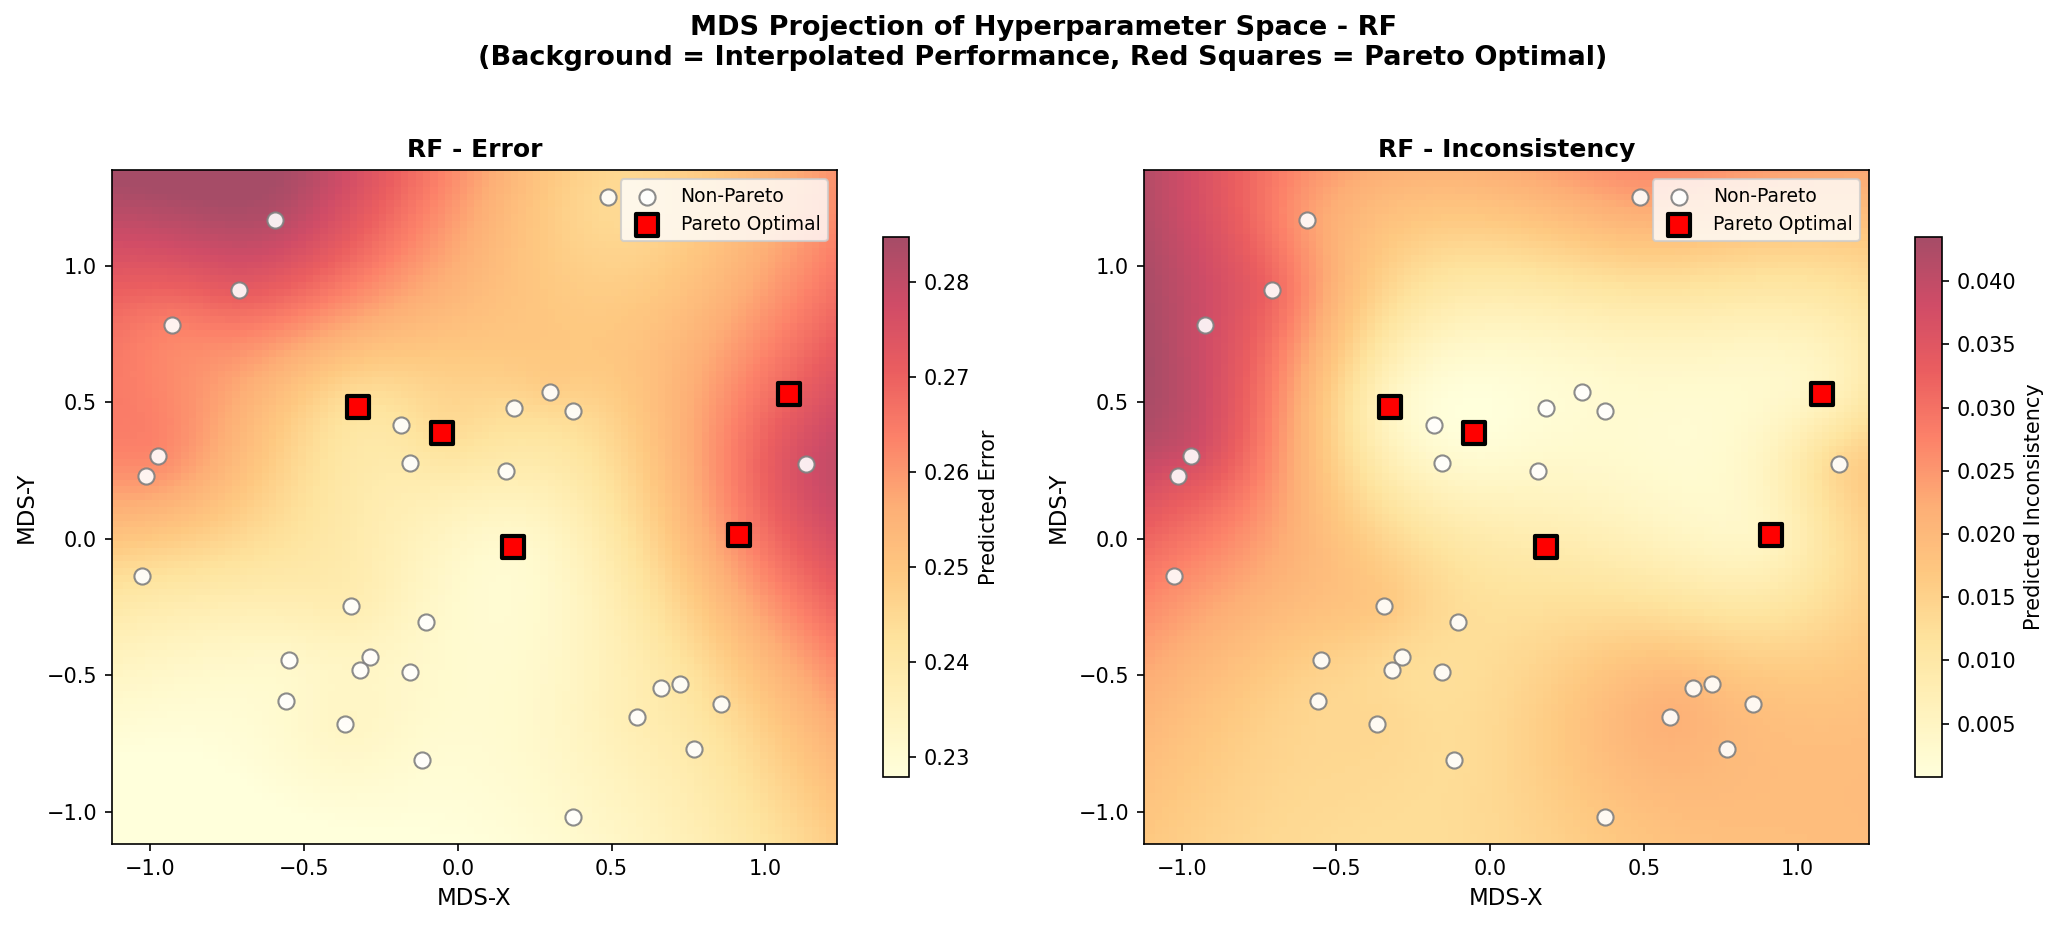

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_sex_mlp.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_sex_mlp.png

MLP - MDS Projection:


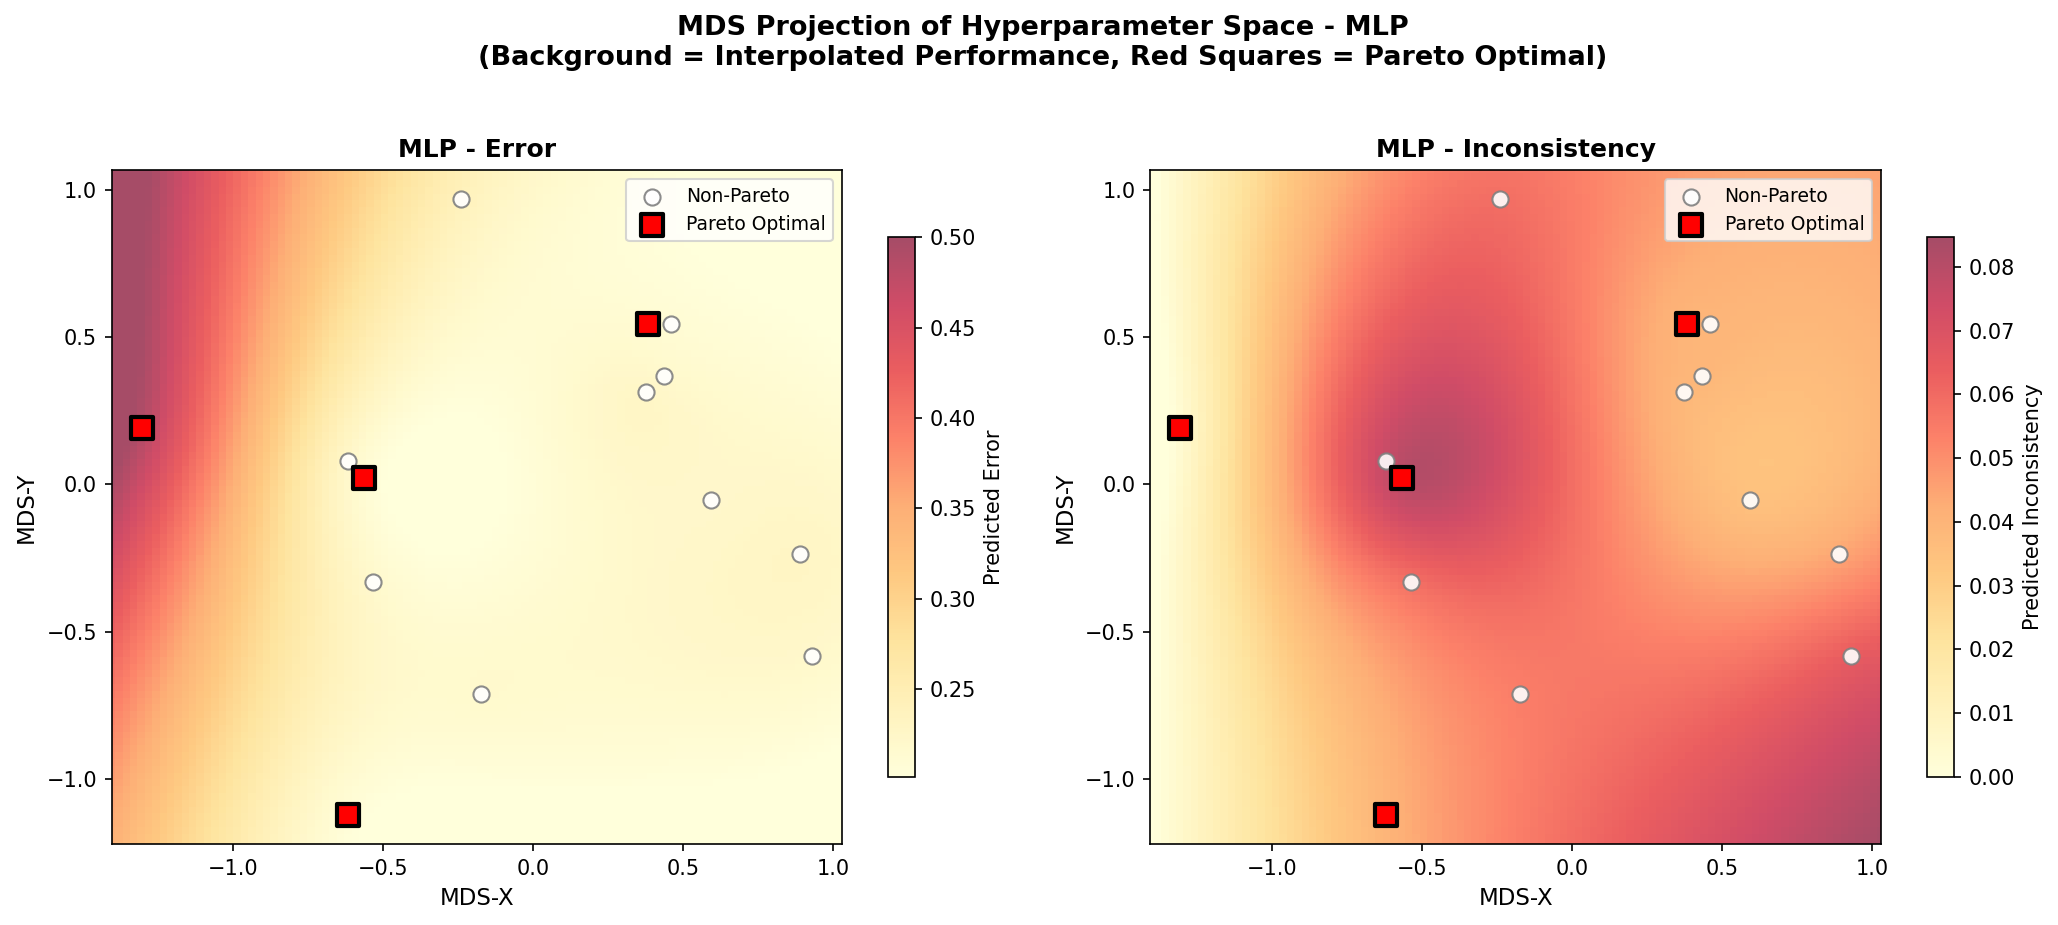

In [85]:
# ============================================================================
# 1.1.4e MDS PROJECTION PLOTS - SEX
# ============================================================================

mds_paths_sex = plot_mds_both_models(
    results_sex, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_SEX, 
    OUTPUT_DIR
)

### 1.1.5 Fairness-Accuracy Confusion Matrix (Sex)

Analyzes the joint distribution of prediction correctness and counterfactual consistency at the **sample level** for the sex-sensitive feature.

|                        | **Consistent** | **Inconsistent** |
|------------------------|----------------|------------------|
| **Correct Prediction** | ✅ Ideal | ⚠️ Right but Unfair |
| **Wrong Prediction**   | 🔸 Fair Error | ❌ Worst Case |

**Key questions:**
- **P(Consistent | Correct)**: Are correct predictions more likely to be fair?
- **P(Correct | Inconsistent)**: Are unfair predictions more likely to be wrong?

This reveals whether fairness and accuracy are **aligned** or in **tension** for this model.


Analyzing RF - Best Accuracy Configuration
Accuracy: 0.7721
Consistency: 0.9906

FAIRNESS-ACCURACY CONFUSION MATRIX: RF (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7681              55       7736
Wrong Prediction                1279              30       1309
------------------------------------------------------------
Total                           8960              85       9045

📈 Key Metrics:
  • Accuracy:    85.53%
  • Consistency: 99.06%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   99.29%
  • P(Consistent | Wrong):     97.71%
  • P(Correct | Consistent):   85.73%
  • P(Correct | Inconsistent): 64.71%

💡 Interpretation:
  → Correct predictions are 1.6% more likely to be consistent
    (Fairness and accuracy are positively correlated)
  → 0.7% of correct predictions are 'right but unfair'

[notebook] Fairness confusio

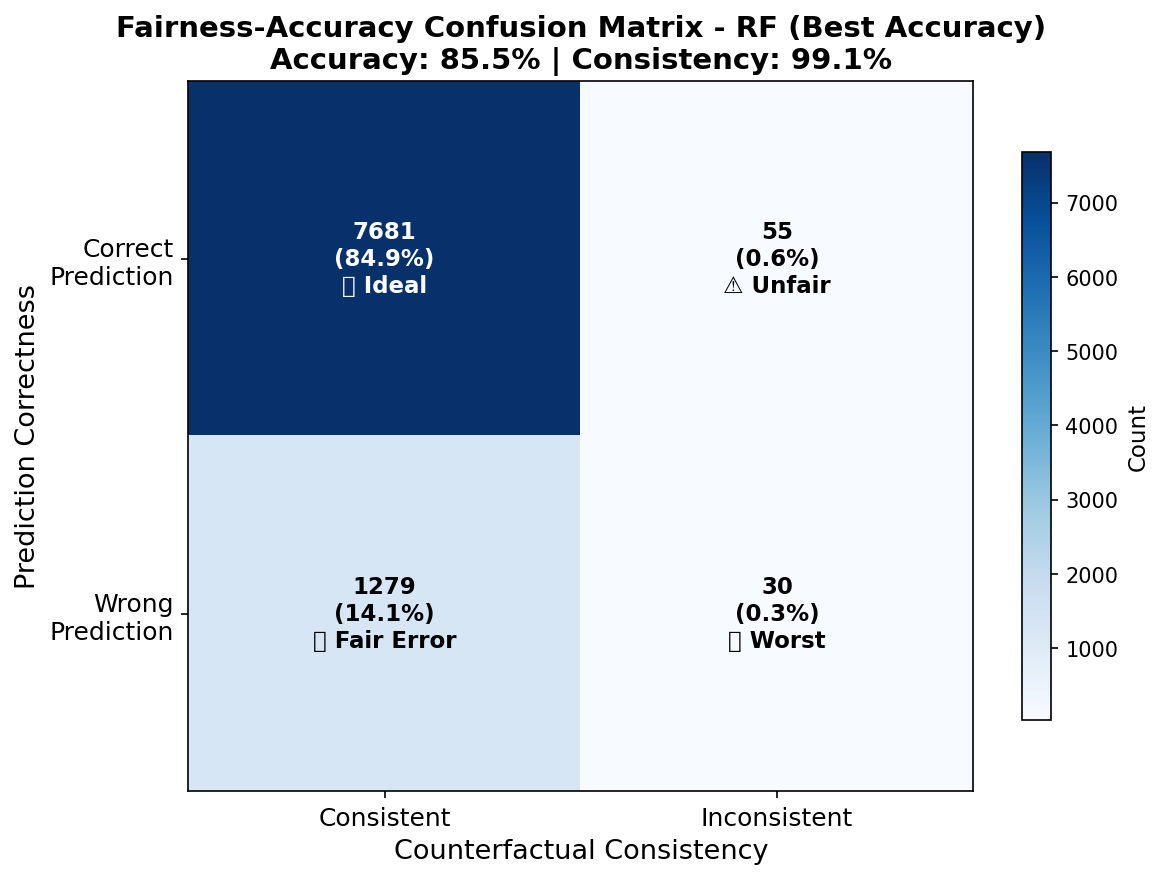


Analyzing MLP - Best Accuracy Configuration
Accuracy: 0.7984
Consistency: 0.9055

FAIRNESS-ACCURACY CONFUSION MATRIX: MLP (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7254             472       7726
Wrong Prediction                 936             383       1319
------------------------------------------------------------
Total                           8190             855       9045

📈 Key Metrics:
  • Accuracy:    85.42%
  • Consistency: 90.55%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   93.89%
  • P(Consistent | Wrong):     70.96%
  • P(Correct | Consistent):   88.57%
  • P(Correct | Inconsistent): 55.20%

💡 Interpretation:
  → Correct predictions are 22.9% more likely to be consistent
    (Fairness and accuracy are positively correlated)
  → 6.1% of correct predictions are 'right but unfair'

[notebook] Fairness confu

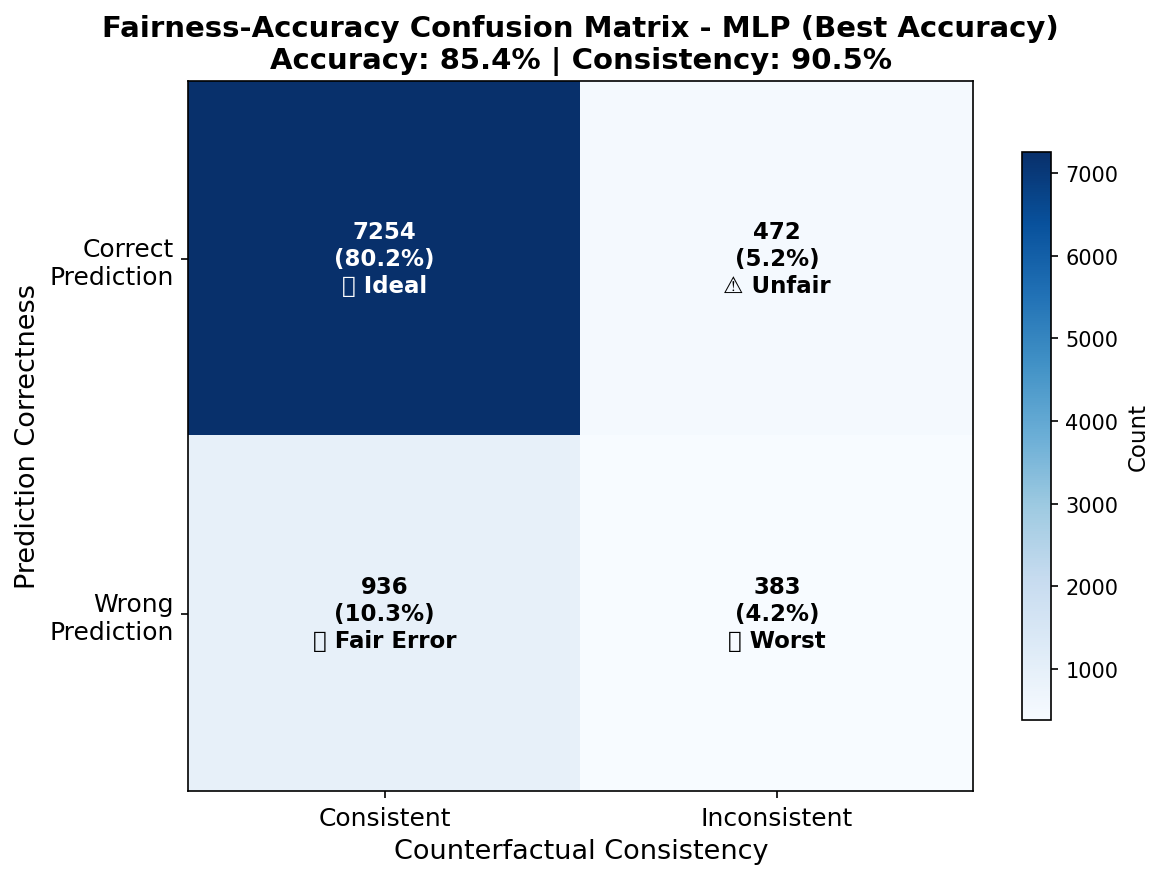

In [87]:
# ============================================================================
# 1.1.5 FAIRNESS-ACCURACY CONFUSION MATRIX - SEX
# ============================================================================
# Analyze the relationship between correctness and consistency
# Using the best accuracy configuration from the Pareto front
# Train on TRAINING set, evaluate on VALIDATION set

fcm_results_sex = analyze_fairness_confusion_matrix(
    results_sex, 
    data_sex, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_SEX, 
    OUTPUT_DIR
)

### 1.1.6 Investigating the "Trivially Fair" MLP (Sex)

During optimization, SMAC may find an MLP configuration achieving **100% consistency but only ~50% accuracy**. This section investigates why this happens and confirms it's a **degenerate solution** rather than a genuinely fair model.

**Key question:** Is high fairness with low accuracy meaningful, or a pathological case?

In [89]:
# ============================================================================
# 1.1.6 TRIVIALLY FAIR MLP ANALYSIS - SEX
# ============================================================================
# Investigate if the "fairest" MLP is actually a degenerate solution

trivial_analysis_sex = analyze_trivial_fairness(results_sex, data_sex, model_type='mlp')

TRIVIALLY FAIR MLP ANALYSIS

Fairest configuration from Pareto front:
  Accuracy: 50.0%
  Consistency: 100.0%

Configuration: logistic activation, sgd solver
Learning rate: 0.0017, Alpha: 0.0367

--- With LOGISTIC activation ---
Unique predictions: [0] → Predicts only ONE class!
Balanced Accuracy: 50.0%
Training iterations: 12

--- With ReLU activation (same other params) ---
Unique predictions: [0 1] → Predicts both classes
Balanced Accuracy: 76.6%
Training iterations: 67

CONCLUSION:
→ Logistic activation caused vanishing gradients
→ Network never learned → constant predictions → 'trivial' 100% fairness
→ ReLU fixes this: accuracy improves from 50.0% to 76.6%

⚠️  High fairness + low accuracy = likely a degenerate solution!


#### Summary: The "Trivial Fairness" Problem

##### The Configuration

| Hyperparameter | Value | Impact |
|---------------|-------|--------|
| `activation` | `logistic` (sigmoid) | **Main culprit** - causes vanishing gradients |
| `solver` | `sgd` | No momentum to escape flat regions |
| `learning_rate_init` | ~0.002 | Very low - tiny weight updates |
| `alpha` | ~0.04 | High L2 regularization - pushes weights to zero |
| `hidden_layer_sizes` | 2 layers | Gradients multiply through both |

##### Root Cause: Vanishing Gradient Problem

The sigmoid activation function has a maximum gradient of only 0.25:

$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$$

In a 2-layer network, gradients compound:

$$\text{Effective gradient} \approx 0.25 \times 0.25 = 0.0625 \text{ (6.25\% of original)}$$

##### Why This Matters for Fairness Research

This is a **false positive for fairness**: the model achieves perfect consistency not because it learned to be fair, but because it **learned nothing at all**. A constant predictor trivially satisfies:

$$\text{Consistency} = \frac{\sum \mathbb{1}[f(x) = f(x')]}{n} = 1.0 \quad \text{when } f(x) = c \text{ for all } x$$

##### Key Takeaway

> ⚠️ **When evaluating fairness metrics, always check model accuracy first.** A model with very high fairness but near-random accuracy may be a degenerate solution that provides no value.

##### Verification

Changing **only** the activation from `logistic` to `relu` (keeping all else the same) allows the network to learn:
- ReLU gradient = 1 (for positive inputs) vs sigmoid's max of 0.25
- The model achieves meaningful accuracy with the same hyperparameters
- This confirms the sigmoid activation was the bottleneck

### 1.1.7 Case Study: Sample-Level Fairness Analysis (Sex)

This section analyzes individual samples to understand how counterfactual consistency manifests at the sample level for the **sex** sensitive feature. We examine:

1. **Prediction flips** — Samples where changing sex changes the prediction
2. **Consistent samples** — Samples robust to sex attribute changes
3. **Edge cases** — Samples near the decision boundary (most vulnerable to bias)
4. **Model comparison** — How RF and MLP differ in their fairness behavior
5. **Probability sensitivity** — How much predictions shift even without flipping

In [91]:
# ============================================================================
# 1.1.7a CASE STUDY SETUP - SEX
# ============================================================================

cs_sex = setup_case_study_analysis(
    results_sex, 
    data_sex, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_SEX
)

Selected Models (Best Accuracy from Pareto Front):
  RF:  Accuracy=0.7721, Consistency=0.9906
  MLP: Accuracy=0.7984, Consistency=0.9055

Using BINARY counterfactual (feature: sex)

Counterfactual Consistency on VALIDATION SET:
  RF:  99.1% consistent (85 inconsistent)
  MLP: 90.5% consistent (855 inconsistent)

✓ These results match what SMAC optimized for!


In [96]:
# 1.1.7b - Case 1: Prediction Flip
case_study_prediction_flip(cs_sex)

CASE: Prediction FLIPS When Sensitive Attribute Changes (Most Extreme)
Sample 2660: True label = 0
  Original (sex_Male=1):  P(class=1) = 0.6016 → Pred = 1
  Flipped (sex_Male=0):   P(class=1) = 0.0899 → Pred = 0
  ΔP = -0.5117


In [104]:
# 1.1.7c - Case 2: Consistent Sample  
case_study_consistent_sample(cs_sex)

CASE: Prediction STAYS CONSISTENT (Robust to Change)
Sample 8: True label = 1
  Original (sex_Male=0):  P(class=1) = 1.0000 → Pred = 1
  Flipped (sex_Male=1):   P(class=1) = 1.0000 → Pred = 1
  |ΔP| = 0.0000 (prediction unchanged)
  ✓ Model relies on other features, not sex_Male


In [98]:
# 1.1.7d - Case 3: Edge Cases
case_study_edge_cases(cs_sex)

CASE: Edge Cases Near Decision Boundary
Samples within 10% of boundary: 846
Of these, inconsistent: 47
Inconsistency rate near boundary: 5.6%
Inconsistency rate overall: 0.9%

→ Edge cases are 5.9x more vulnerable!

✓ Analysis on VALIDATION set (9,045 samples)


In [99]:
# 1.1.7e - Case 4: Model Comparison
case_study_model_comparison(cs_sex)

CASE: RF vs MLP - Different Models, Different Fairness
Only RF unfair:  48
Only MLP unfair: 818
Both unfair:     37
Both fair:       8,142

→ Models can be unfair to DIFFERENT individuals!


In [100]:
# 1.1.7f - Case 5: Probability Swings
case_study_probability_swings(cs_sex)

CASE: Largest Probability Swings
RF  max swing: Sample 2660
    P: 0.6016 → 0.0899 (Δ=0.5117)
    Prediction flipped: Yes ✗

MLP max swing: Sample 2298
    P: 0.3992 → 0.6340 (Δ=0.2348)
    Prediction flipped: Yes ✗

→ Even without flipping, large ΔP indicates sensitivity to protected attribute!


In [101]:
# 1.1.7g - Case 6: Directional Analysis
case_study_directional_analysis(cs_sex)

CASE: Aggregate Directional Analysis

Overall Average Probability Changes:
  RF:  Mean ΔP = +0.0042, Mean |ΔP| = 0.0181
  MLP: Mean ΔP = -0.0458, Mean |ΔP| = 0.0802
  (positive ΔP = flipping 0→1 INCREASES probability on average)

RF breakdown by original sex_Male:
  sex_Male=0 → 1: Mean ΔP = +0.0247, |ΔP| = 0.0289 (n=2,877)
  sex_Male=1 → 0: Mean ΔP = -0.0054, |ΔP| = 0.0131 (n=6,168)

MLP breakdown by original sex_Male:
  sex_Male=0 → 1: Mean ΔP = +0.0542, |ΔP| = 0.0542 (n=2,877)
  sex_Male=1 → 0: Mean ΔP = -0.0924, |ΔP| = 0.0924 (n=6,168)

✓ Analysis on VALIDATION set (9,045 samples)


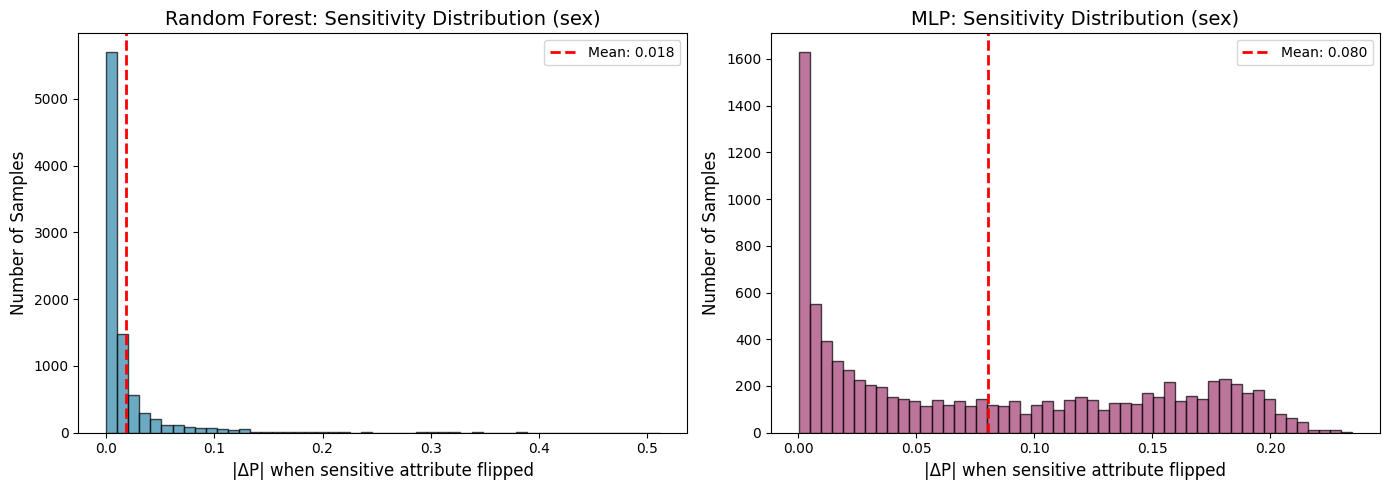

RF:  Mean |ΔP| = 0.0181, Max = 0.5117
MLP: Mean |ΔP| = 0.0802, Max = 0.2348


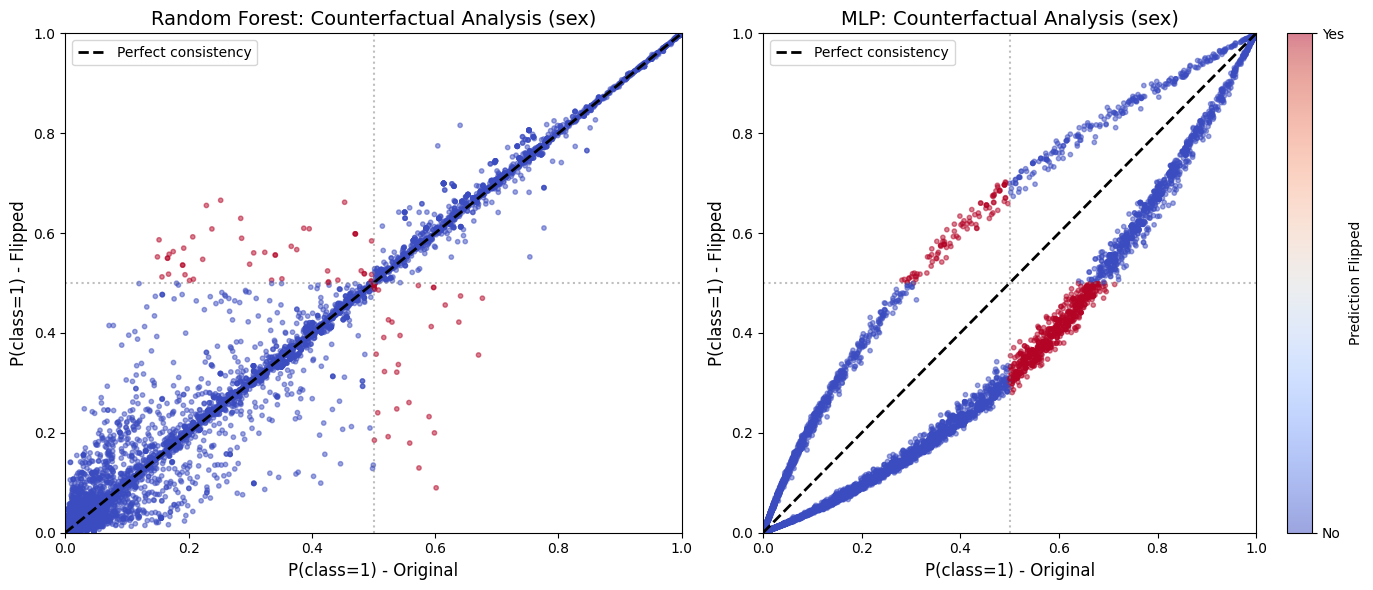

Blue = consistent (fair), Red = prediction flipped (unfair)
Points in upper-left/lower-right quadrants crossed the decision boundary


In [102]:
# 1.1.7h - Visualizations
plot_case_study_visualizations(cs_sex, DATASET_NAME, SENSITIVE_FEATURE_SEX, OUTPUT_DIR)

### 1.2 Analysis: Race (Multiclass Sensitive Feature)

Next, we analyze fairness with respect to **race** — a multiclass sensitive attribute (one-hot encoded).
- **Counterfactual method**: Exhaustive flip (test all category assignments)
- **Consistency definition**: Prediction unchanged across ALL possible race assignments
- **Categories**: White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other

#### Code: 1.2.1 Load Data & Split (Race)


In [106]:
# ============================================================================
# 1.2.1 LOAD DATA & SPLIT - RACE (Multiclass)
# ============================================================================

SENSITIVE_FEATURE_RACE = "race_all"

# Load dataset
data_race = load_dataset(DATASET_NAME, SENSITIVE_FEATURE_RACE)

# Apply train/val/test split
data_race = split_data(data_race)  # Uses helper function from Section 0

print(f"\n{'='*60}")
print(f"DATASET: {DATASET_NAME} | SENSITIVE FEATURE: {SENSITIVE_FEATURE_RACE}")
print(f"{'='*60}")
print(f"  Train:      {len(data_race['X_train']):,}")
print(f"  Validation: {len(data_race['X_val']):,}")
print(f"  Test:       {len(data_race['X_test']):,}")
print(f"  Type: MULTICLASS ({len(data_race['sensitive_col_indices'])} categories, exhaustive flip)")
print(f"  Categories: {data_race['sensitive_col_names']}")

Loading Adult Income from OpenML (ID: 179)...
APPROACH 1: Keeping sensitive features in training
  Sensitive feature for counterfactual: race_all
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Multiclass sensitive feature: race_all
  Columns (5): ['race_White', 'race_Black', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other']
  Indices: [41, 45, 42, 43, 44]

Final features (63): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 1):
  Samples: 45222, Features: 63
  Positive class ratio: 24.78%
Data split: Train=27,132, Val=9,045, Test=9,045

DATASET: adult | SENSITIVE FEATURE: race_all
  Train:      27,132
  Validation: 9,045
  Te

#### 1.2.2 Data Exploration: Race Distribution

Understanding the distribution of outcomes across sensitive groups is crucial for fairness analysis. 
We examine:

1. **Base rate disparity** — Are positive outcomes distributed equally across race categories?
2. **Sample sizes** — How many samples per race category? (imbalanced groups affect fairness)
3. **Class imbalance** — Is there imbalance within each race category?

These distributions reveal potential historical biases in the data that models may learn and amplify.

**Note:** With 5 race categories (White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other), we expect varying sample sizes and potentially different base rates across groups.

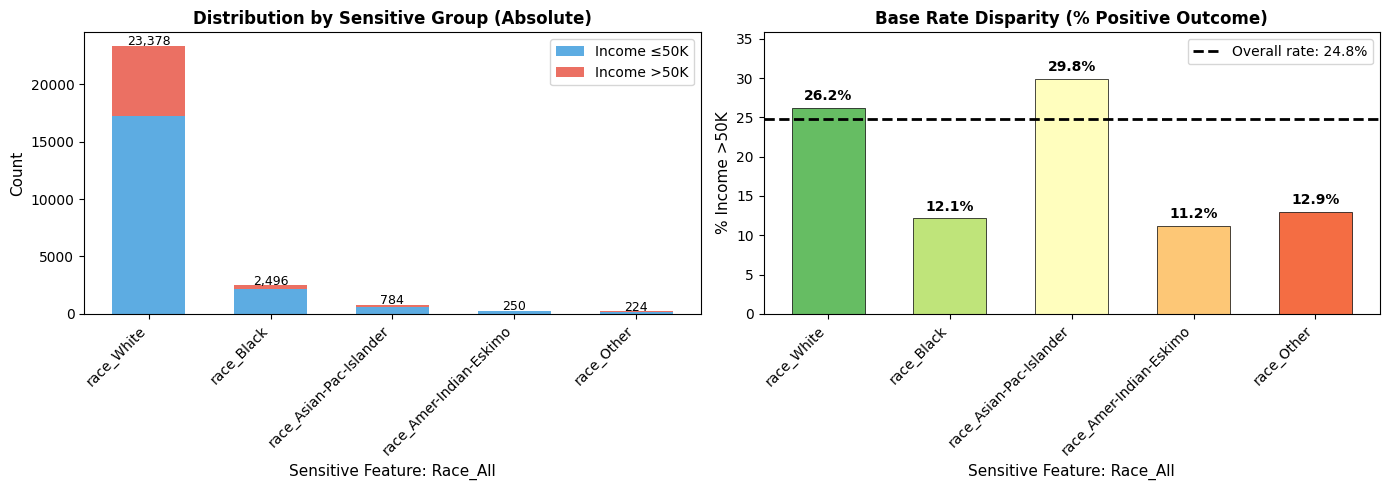


DISTRIBUTION SUMMARY

Sensitive Feature: race_all (5 categories)
Group                Count    % of Data    Base Rate
--------------------------------------------------
race_White          23,378        86.2%        26.2%
race_Black           2,496         9.2%        12.1%
race_Asian-Pac-Islander        784         2.9%        29.8%
race_Amer-Indian-Eskimo        250         0.9%        11.2%
race_Other             224         0.8%        12.9%
--------------------------------------------------
OVERALL             27,132       100.0%        24.8%

📊 Disparity Analysis:
   • Highest base rate: 29.8%
   • Lowest base rate:  11.2%
   • Disparity ratio:   2.66x
   • Absolute gap:      18.6 percentage points


In [108]:
# ============================================================================
# 1.1.2 DATA EXPLORATION - SEX
# ============================================================================

plot_sensitive_distribution(data_race, DATASET_NAME, SENSITIVE_FEATURE_RACE)

### 1.2.3 Multi-Objective Optimization (Race)

Run SMAC (Sequential Model-based Algorithm Configuration) to find Pareto-optimal hyperparameter configurations that balance **accuracy** and **counterfactual consistency** with respect to **race** (multiclass).

**Objectives:**
- Minimize classification error (maximize balanced accuracy)
- Minimize counterfactual inconsistency (maximize consistency across ALL race flips)

**Note:** Multiclass consistency is stricter — a sample is only consistent if the prediction stays the same when flipping to ANY other race category.

In [ ]:
# SMAC settings
WALLTIME_LIMIT = 60  # seconds per model
N_TRIALS = 100        # max configurations per model

# Caching
LOAD_FROM_CACHE = False  # Set to False to re-run optimization

In [109]:
%%time
# ============================================================================
# 1.2.3 SMAC OPTIMIZATION - RACE
# ============================================================================

results_race = run_smac_optimization(
    data=data_race,
    dataset_name=DATASET_NAME,
    sensitive_feature=SENSITIVE_FEATURE_RACE,
    load_from_cache=LOAD_FROM_CACHE,
    walltime_limit=WALLTIME_LIMIT,
    n_trials=N_TRIALS
)

Running SMAC optimization for adult/race_all...

Optimizing RF (Sensitive: race_all)...

Running SMAC optimization for RF (Approach 1)
Training samples: 27,132
Validation samples: 9,045
Using MULTICLASS counterfactual (exhaustive, 5 categories)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 31471b is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config b559dc is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:596] Added config 30b752 and rejected config 65fa19 as incumbent because it is not better than the i

### 1.2.4 Results & Visualization (Race)

#### Pareto Front Analysis

The Pareto front shows the optimal trade-off between accuracy and counterfactual consistency when **race** is the sensitive attribute (multiclass, 5 categories).

- **X-axis**: Balanced Accuracy (higher = better predictions)
- **Y-axis**: Counterfactual Consistency (higher = fairer w.r.t. race)
- **Pareto-optimal points**: Connected by dashed lines
- **Dominated points**: Lighter colored, suboptimal configurations

**Note:** Multiclass consistency is typically lower than binary because it requires robustness across ALL possible race assignments, not just a single flip.

In [110]:
# ============================================================================
# 1.2.4a OPTIMIZATION SUMMARY - RACE
# ============================================================================

print_optimization_summary(results_race, DATASET_NAME, SENSITIVE_FEATURE_RACE)

OPTIMIZATION SUMMARY: ADULT / RACE_ALL


Model  Configs Evaluated  Pareto Front Size Total Time (s)  \
0    RF                 34                  9           25.1   
1   MLP                 18                  7           61.2   

  Avg Time/Config (s)  
0                0.74  
1                3.40


PARETO EFFICIENCY
RF: 9/34 configs are Pareto-optimal (26.5%)
MLP: 7/18 configs are Pareto-optimal (38.9%)


In [111]:
# ============================================================================
# 1.2.4b PARETO FRONT DETAILS - RACE
# ============================================================================

print(f"\n{'='*70}")
print(f"PARETO-OPTIMAL CONFIGURATIONS: {DATASET_NAME.upper()} / {SENSITIVE_FEATURE_RACE.upper()}")
print(f"{'='*70}\n")

print_pareto_summary(results_race)


PARETO-OPTIMAL CONFIGURATIONS: ADULT / RACE_ALL


PARETO FRONT SUMMARY

RF Pareto Front (9 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7718, Consistency=0.9799
  Config 2: Accuracy=0.7658, Consistency=0.9899
  Config 3: Accuracy=0.7632, Consistency=0.9979
  Config 4: Accuracy=0.7627, Consistency=0.9986
  Config 5: Accuracy=0.7623, Consistency=0.9990
  Config 6: Accuracy=0.7615, Consistency=0.9991
  Config 7: Accuracy=0.7615, Consistency=0.9991
  Config 8: Accuracy=0.7614, Consistency=0.9998
  Config 9: Accuracy=0.7371, Consistency=1.0000

  Best Accuracy: 0.7718 (Consistency: 0.9799)
  Best Consistency: 1.0000 (Accuracy: 0.7371)

MLP Pareto Front (7 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7932, Consistency=0.9501
  Config 2: Accuracy=0.7862, Consistency=0.9745
  Config 3: Accuracy=0.7778, Consistency=0.9756
  Config 4: Accuracy=0.7731, Consistency=0.9766
  Config 5: Accuracy=0.7523, Consi

[notebook] Pareto plot saved to: ../plots/notebook/pareto_adult_race_all.png
[latex] Pareto plot saved to: ../plots/latex/pareto_adult_race_all.png


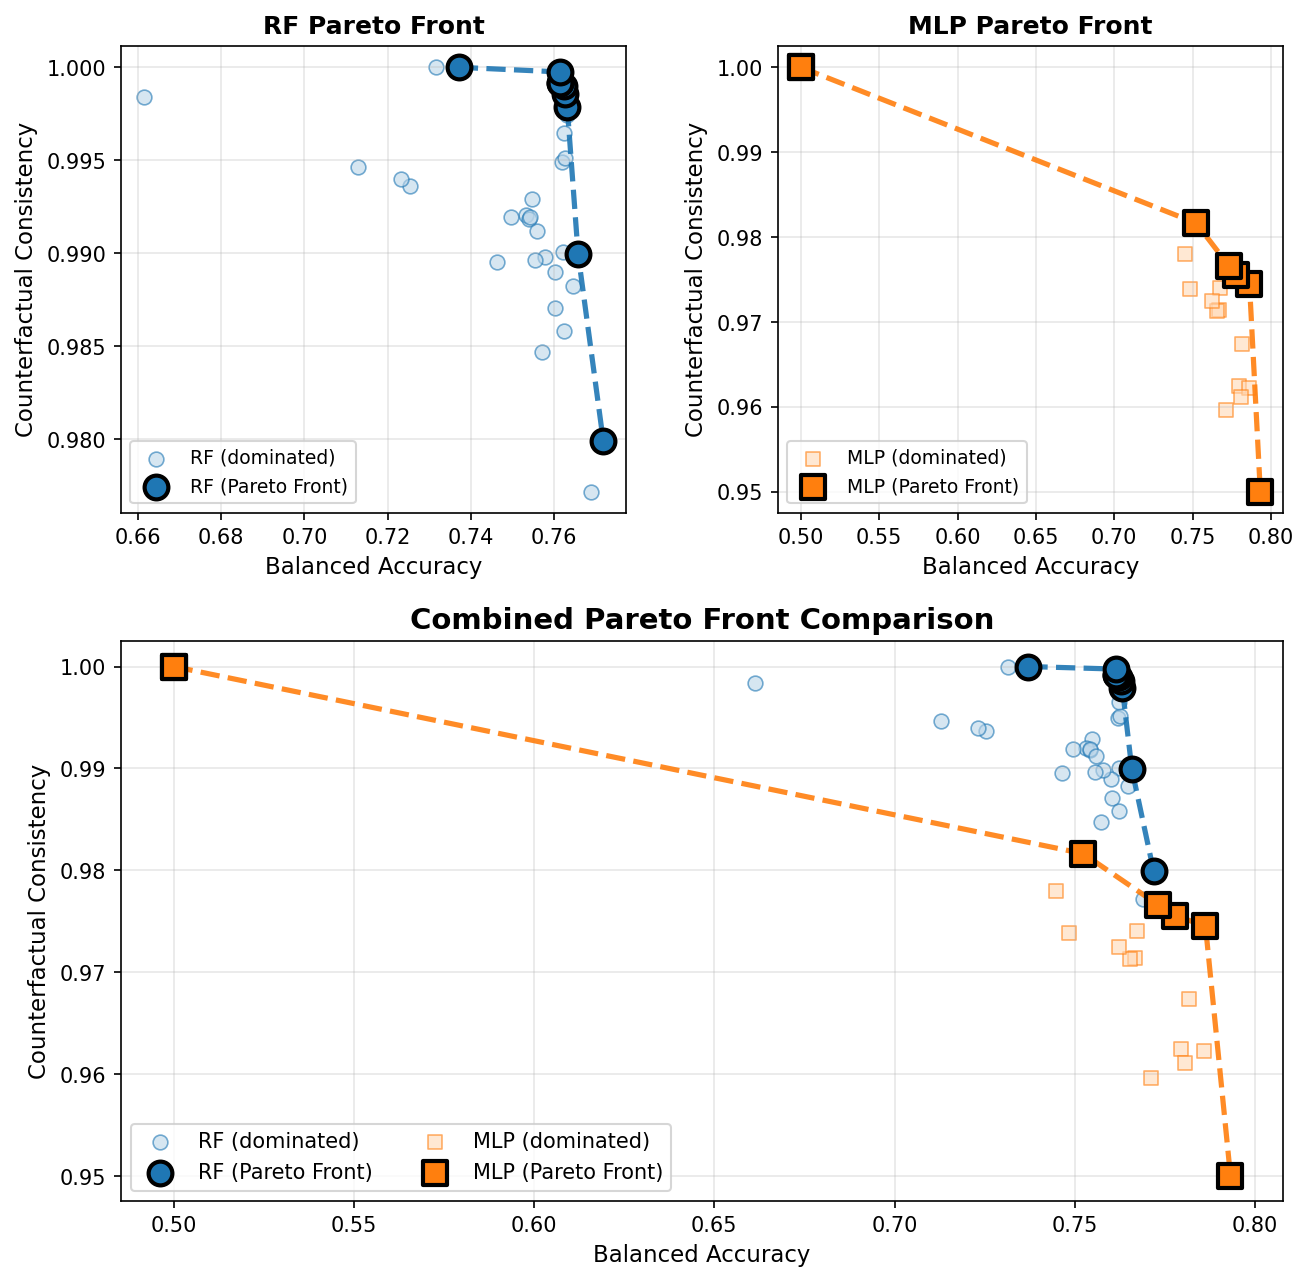

In [113]:
# ============================================================================
# 1.2.4c PARETO FRONT VISUALIZATION - RACE
# ============================================================================

pareto_paths_race = plot_and_display_pareto(
    results_race, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_RACE, 
    OUTPUT_DIR
)

#### Parallel Coordinate Plots (Sex)

Parallel coordinate plots visualize how hyperparameter configurations map to objective values.

| Element | Meaning |
|---------|---------|
| **Vertical axes** | Hyperparameters and objectives |
| **Lines** | Individual configurations |
| **Bold lines** | Pareto-optimal configurations |
| **Faint lines** | Dominated configurations |
| **Color** | Performance (green = better, red = worse) |

**Key insights:**
- Identify which hyperparameter ranges lead to better trade-offs
- Spot correlations between hyperparameters and objectives
- Assess diversity of the explored configuration space

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_rf.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_rf.png

RF - Parallel Coordinate Plot:


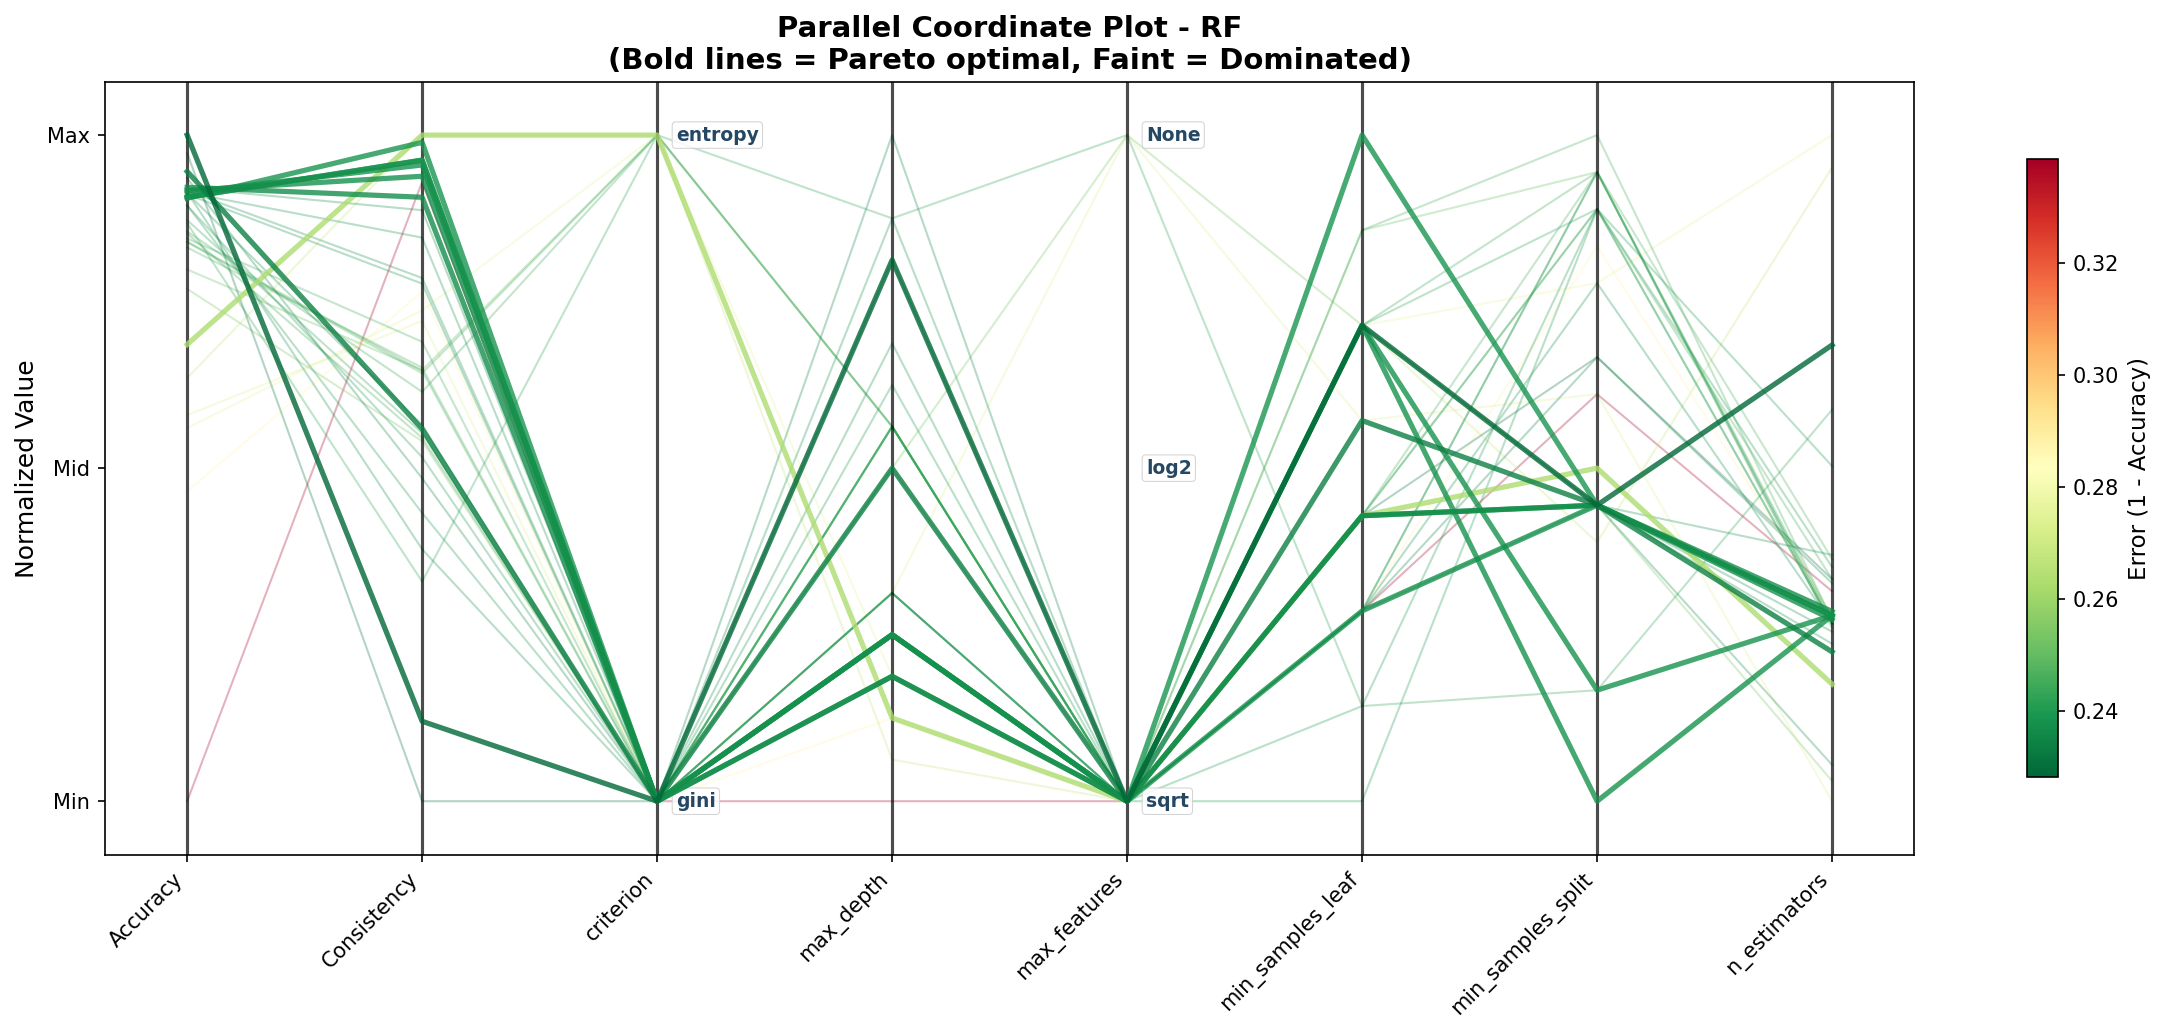

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_mlp.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_mlp.png

MLP - Parallel Coordinate Plot:


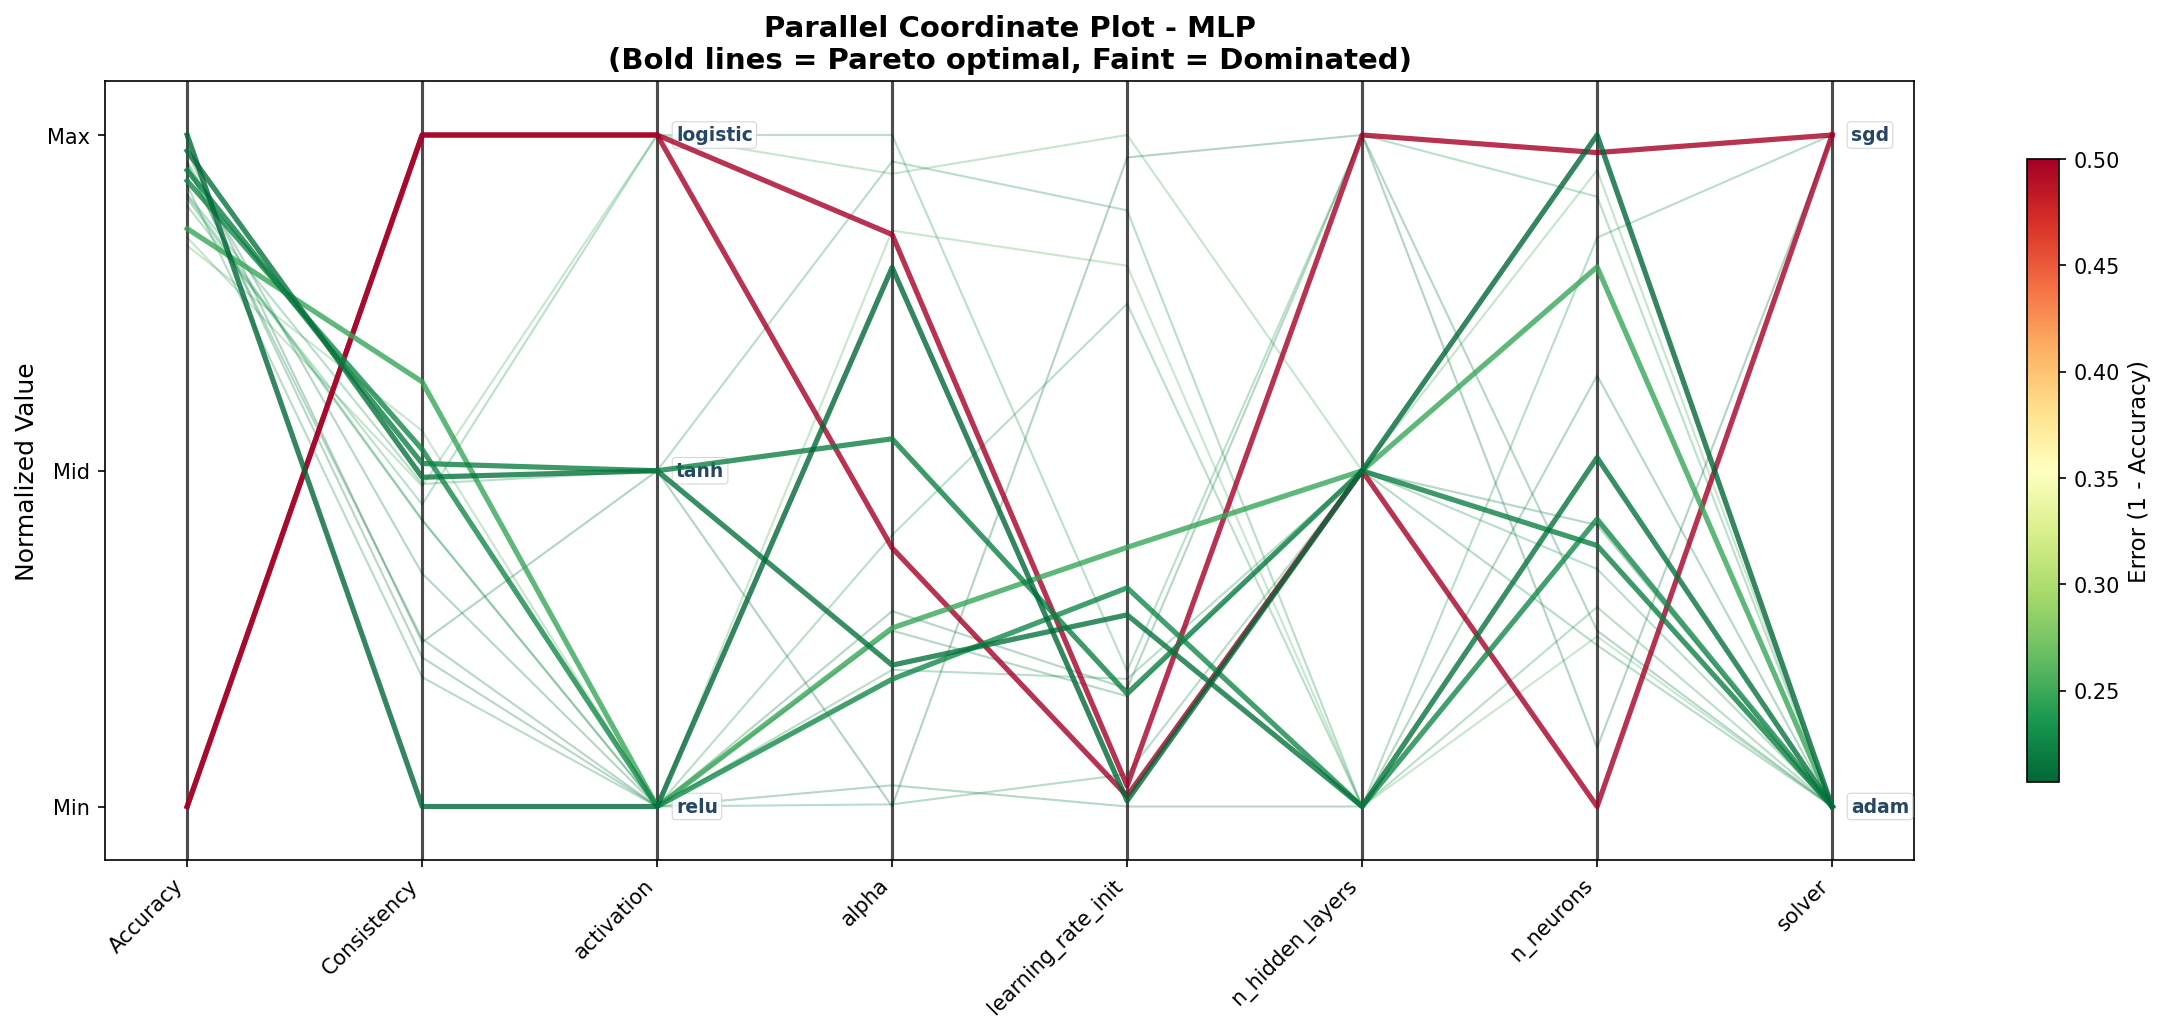

In [114]:
# ============================================================================
# 1.2.4d PARALLEL COORDINATE PLOTS - RACE
# ============================================================================

parallel_paths_race = plot_parallel_coords_both_models(
    results_race, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_RACE, 
    OUTPUT_DIR
)

#### MDS Projection (Sex)

Multidimensional Scaling (MDS) projects the high-dimensional hyperparameter space into 2D while preserving pairwise distances between configurations.

| Element | Meaning |
|---------|---------|
| **Points** | Hyperparameter configurations |
| **Distance** | Similarity in hyperparameter values |
| **Background color** | Interpolated performance surface |
| **Red squares** | Pareto-optimal configurations |
| **White circles** | Non-Pareto configurations |

**Key insights:**
- Identify clusters of similar configurations
- See if high-performing configs are localized or spread out
- Understand the performance landscape structure

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_race_all_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_race_all_rf.png

RF - MDS Projection:


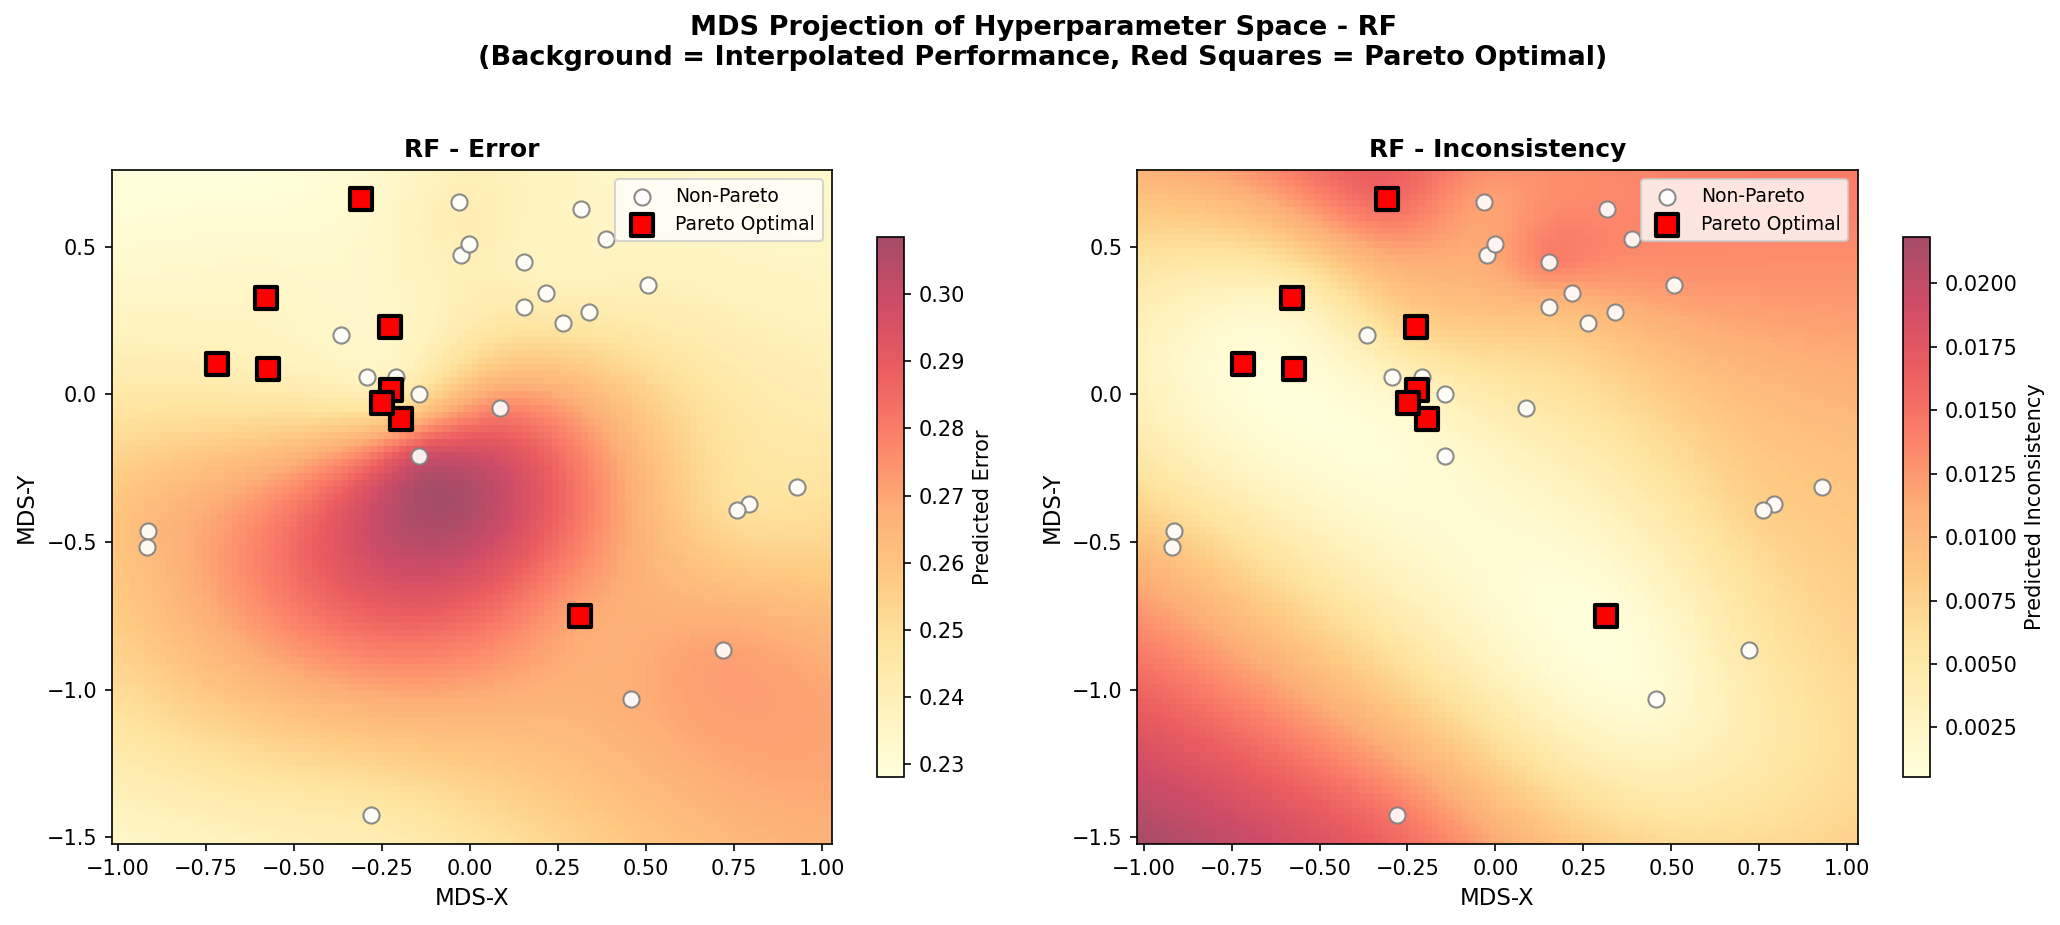

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_race_all_mlp.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_race_all_mlp.png

MLP - MDS Projection:


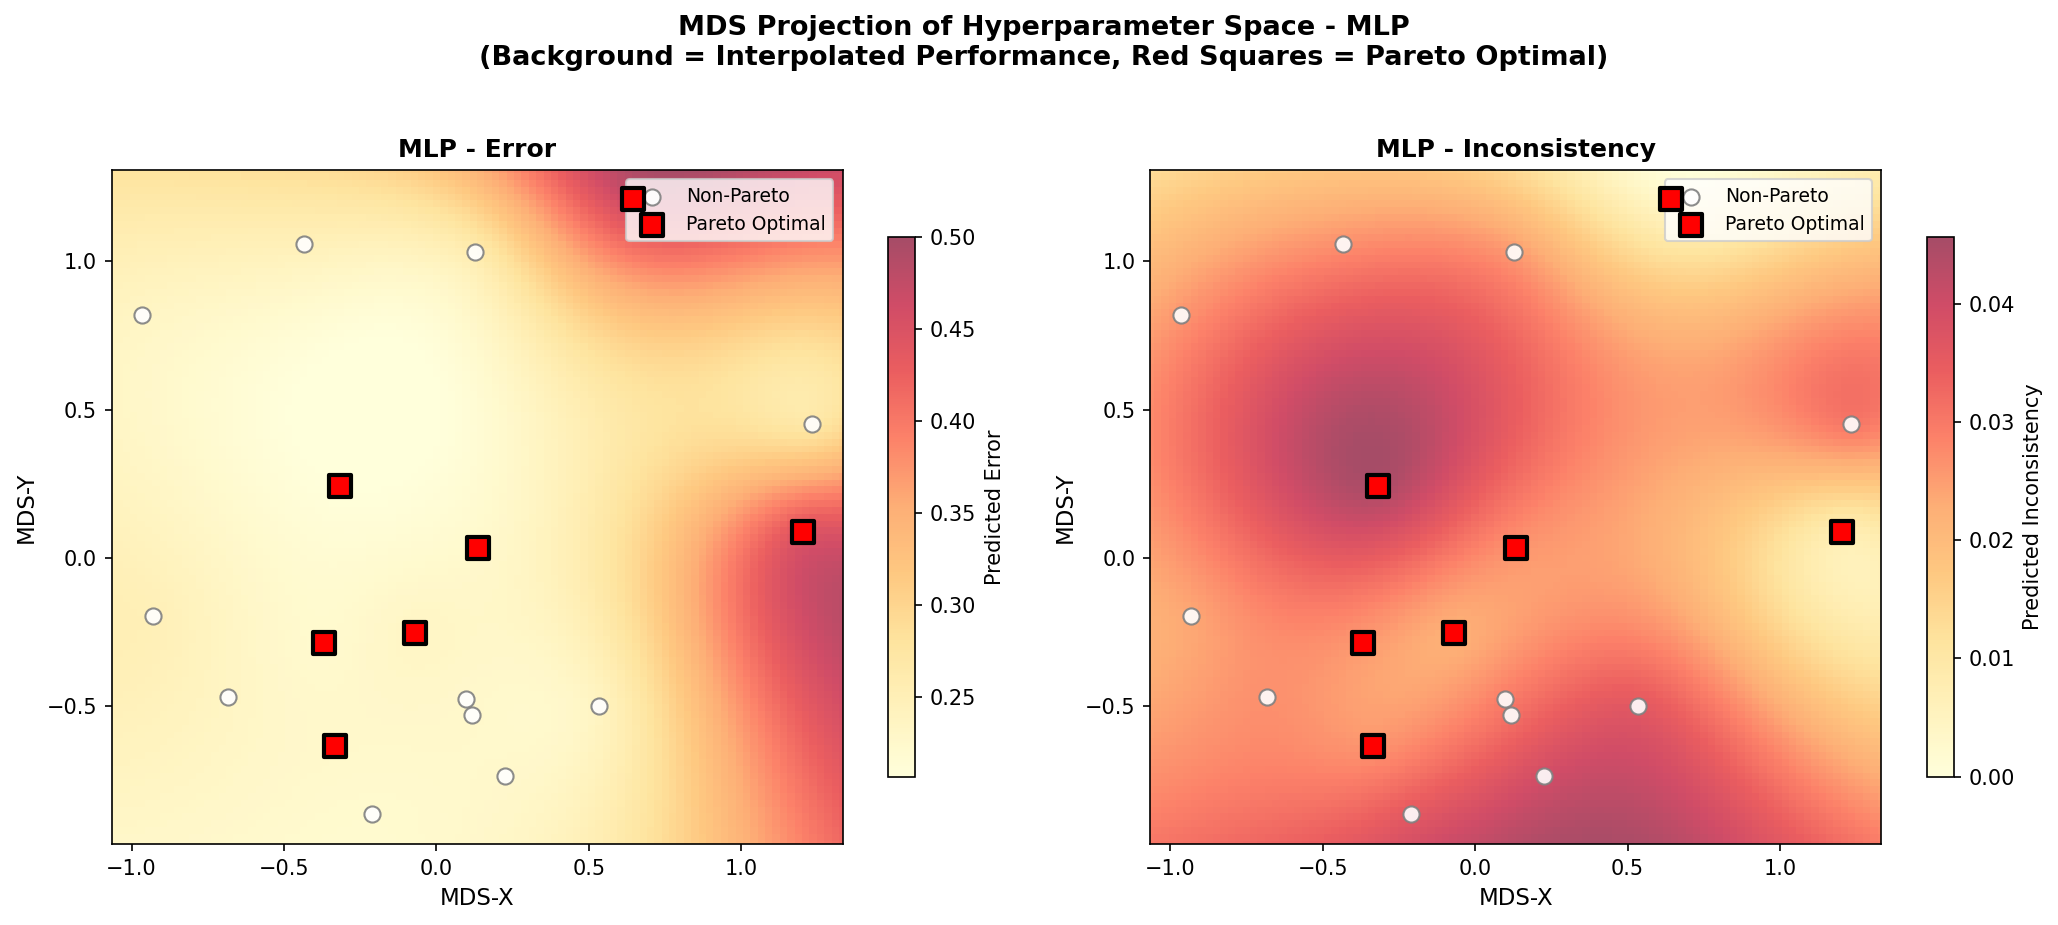

In [115]:
# ============================================================================
# 1.2.4e MDS PROJECTION PLOTS - RACE
# ============================================================================

mds_paths_race = plot_mds_both_models(
    results_race, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_RACE, 
    OUTPUT_DIR
)

### 1.1.5 Fairness-Accuracy Confusion Matrix (Sex)

Analyzes the joint distribution of prediction correctness and counterfactual consistency at the **sample level** for the sex-sensitive feature.

|                        | **Consistent** | **Inconsistent** |
|------------------------|----------------|------------------|
| **Correct Prediction** | ✅ Ideal | ⚠️ Right but Unfair |
| **Wrong Prediction**   | 🔸 Fair Error | ❌ Worst Case |

**Key questions:**
- **P(Consistent | Correct)**: Are correct predictions more likely to be fair?
- **P(Correct | Inconsistent)**: Are unfair predictions more likely to be wrong?

This reveals whether fairness and accuracy are **aligned** or in **tension** for this model.


Analyzing RF - Best Accuracy Configuration
Accuracy: 0.7718
Consistency: 0.9799

FAIRNESS-ACCURACY CONFUSION MATRIX: RF (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7598             137       7735
Wrong Prediction                1201             109       1310
------------------------------------------------------------
Total                           8799             246       9045

📈 Key Metrics:
  • Accuracy:    85.52%
  • Consistency: 97.28%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   98.23%
  • P(Consistent | Wrong):     91.68%
  • P(Correct | Consistent):   86.35%
  • P(Correct | Inconsistent): 55.69%

💡 Interpretation:
  → Correct predictions are 6.5% more likely to be consistent
    (Fairness and accuracy are positively correlated)
  → 1.8% of correct predictions are 'right but unfair'

[notebook] Fairness confusio

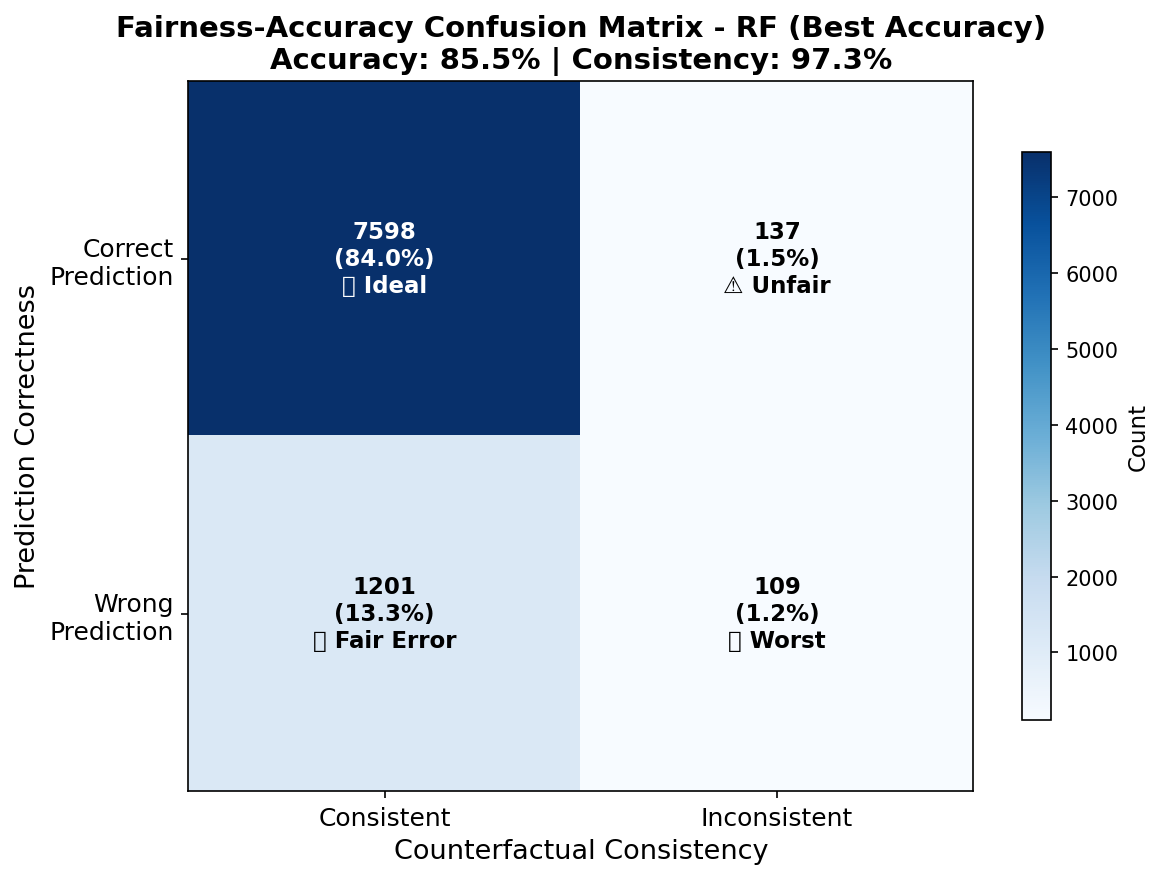


Analyzing MLP - Best Accuracy Configuration
Accuracy: 0.7932
Consistency: 0.9501

FAIRNESS-ACCURACY CONFUSION MATRIX: MLP (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7250             476       7726
Wrong Prediction                 923             396       1319
------------------------------------------------------------
Total                           8173             872       9045

📈 Key Metrics:
  • Accuracy:    85.42%
  • Consistency: 90.36%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   93.84%
  • P(Consistent | Wrong):     69.98%
  • P(Correct | Consistent):   88.71%
  • P(Correct | Inconsistent): 54.59%

💡 Interpretation:
  → Correct predictions are 23.9% more likely to be consistent
    (Fairness and accuracy are positively correlated)
  → 6.2% of correct predictions are 'right but unfair'

[notebook] Fairness confu

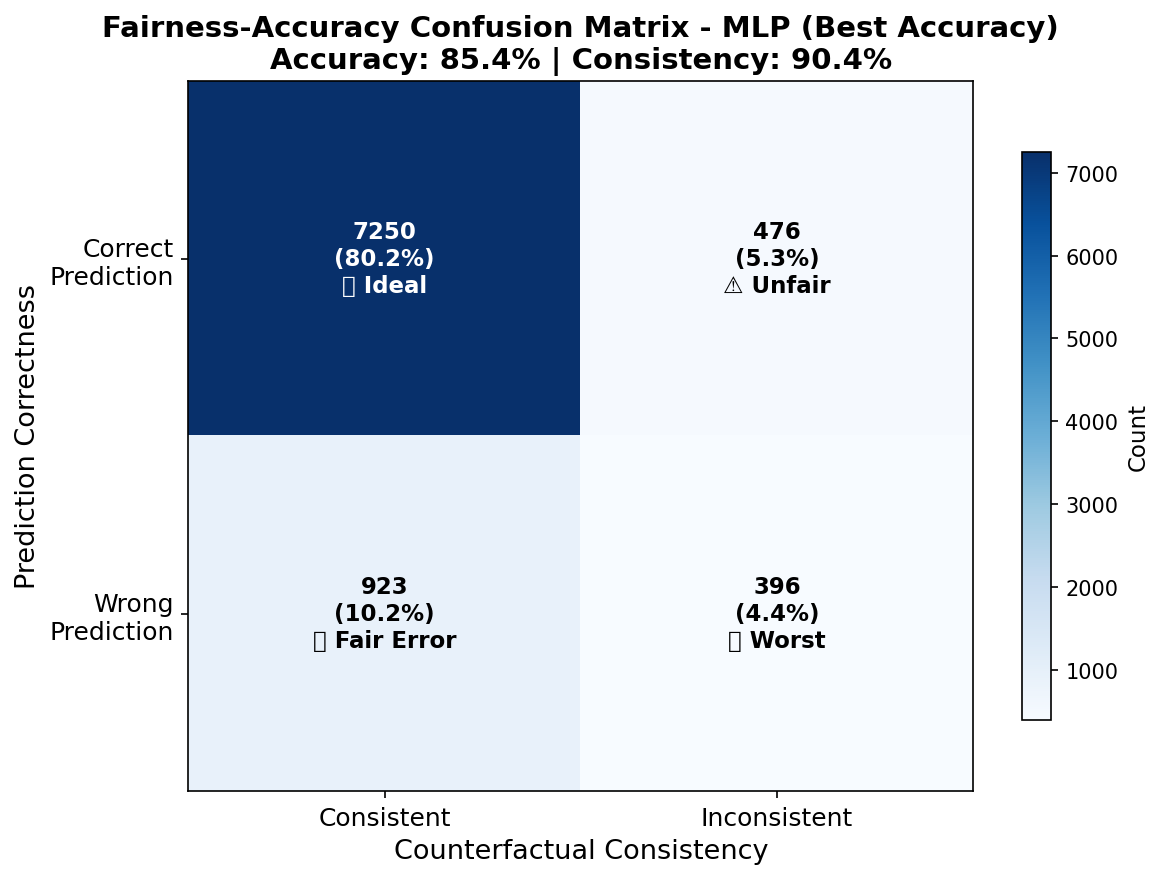

In [116]:
# ============================================================================
# 1.2.5 FAIRNESS-ACCURACY CONFUSION MATRIX - RACE
# ============================================================================
# Analyze the relationship between correctness and consistency
# Using the best accuracy configuration from the Pareto front
# Train on TRAINING set, evaluate on VALIDATION set

fcm_results_race = analyze_fairness_confusion_matrix(
    results_race, 
    data_race, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_RACE, 
    OUTPUT_DIR
)

### 1.1.6 Investigating the "Trivially Fair" MLP (Sex)

During optimization, SMAC may find an MLP configuration achieving **100% consistency but only ~50% accuracy**. This section investigates why this happens and confirms it's a **degenerate solution** rather than a genuinely fair model.

**Key question:** Is high fairness with low accuracy meaningful, or a pathological case?

In [ ]:
# ============================================================================
# 1.1.6 TRIVIALLY FAIR MLP ANALYSIS - SEX
# ============================================================================
# Investigate if the "fairest" MLP is actually a degenerate solution

trivial_analysis_sex = analyze_trivial_fairness(results_sex, data_sex, model_type='mlp')

TRIVIALLY FAIR MLP ANALYSIS

Fairest configuration from Pareto front:
  Accuracy: 50.0%
  Consistency: 100.0%

Configuration: logistic activation, sgd solver
Learning rate: 0.0017, Alpha: 0.0367

--- With LOGISTIC activation ---
Unique predictions: [0] → Predicts only ONE class!
Balanced Accuracy: 50.0%
Training iterations: 12

--- With ReLU activation (same other params) ---
Unique predictions: [0 1] → Predicts both classes
Balanced Accuracy: 76.6%
Training iterations: 67

CONCLUSION:
→ Logistic activation caused vanishing gradients
→ Network never learned → constant predictions → 'trivial' 100% fairness
→ ReLU fixes this: accuracy improves from 50.0% to 76.6%

⚠️  High fairness + low accuracy = likely a degenerate solution!


#### Summary: The "Trivial Fairness" Problem

##### The Configuration

| Hyperparameter | Value | Impact |
|---------------|-------|--------|
| `activation` | `logistic` (sigmoid) | **Main culprit** - causes vanishing gradients |
| `solver` | `sgd` | No momentum to escape flat regions |
| `learning_rate_init` | ~0.002 | Very low - tiny weight updates |
| `alpha` | ~0.04 | High L2 regularization - pushes weights to zero |
| `hidden_layer_sizes` | 2 layers | Gradients multiply through both |

##### Root Cause: Vanishing Gradient Problem

The sigmoid activation function has a maximum gradient of only 0.25:

$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$$

In a 2-layer network, gradients compound:

$$\text{Effective gradient} \approx 0.25 \times 0.25 = 0.0625 \text{ (6.25\% of original)}$$

##### Why This Matters for Fairness Research

This is a **false positive for fairness**: the model achieves perfect consistency not because it learned to be fair, but because it **learned nothing at all**. A constant predictor trivially satisfies:

$$\text{Consistency} = \frac{\sum \mathbb{1}[f(x) = f(x')]}{n} = 1.0 \quad \text{when } f(x) = c \text{ for all } x$$

##### Key Takeaway

> ⚠️ **When evaluating fairness metrics, always check model accuracy first.** A model with very high fairness but near-random accuracy may be a degenerate solution that provides no value.

##### Verification

Changing **only** the activation from `logistic` to `relu` (keeping all else the same) allows the network to learn:
- ReLU gradient = 1 (for positive inputs) vs sigmoid's max of 0.25
- The model achieves meaningful accuracy with the same hyperparameters
- This confirms the sigmoid activation was the bottleneck

### 1.2.6 Case Study: Sample-Level Fairness Analysis (Race)

This section analyzes individual samples to understand how counterfactual consistency manifests at the sample level for the **race** sensitive feature (multiclass). We examine:

1. **Prediction flips** — Samples where changing race changes the prediction
2. **Consistent samples** — Samples robust to race attribute changes across ALL categories
3. **Edge cases** — Samples near the decision boundary (most vulnerable to bias)
4. **Model comparison** — How RF and MLP differ in their fairness behavior
5. **Probability sensitivity** — How much predictions shift even without flipping

**Note:** For multiclass, consistency requires robustness across ALL race reassignments (e.g., White→Black, White→Asian, etc.).

In [117]:
# ============================================================================
# 1.2.6a CASE STUDY SETUP - RACE
# ============================================================================

cs_race = setup_case_study_analysis(
    results_race, 
    data_race, 
    DATASET_NAME, 
    SENSITIVE_FEATURE_RACE
)

Selected Models (Best Accuracy from Pareto Front):
  RF:  Accuracy=0.7718, Consistency=0.9799
  MLP: Accuracy=0.7932, Consistency=0.9501

Using MULTICLASS counterfactual (5 categories)
Categories: ['race_White', 'race_Black', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other']

Counterfactual Consistency on VALIDATION SET:
  RF:  97.3% consistent (246 inconsistent)
  MLP: 90.4% consistent (872 inconsistent)

✓ These results match what SMAC optimized for!


In [118]:
# 1.2.6b - Case 1: Prediction Flip
case_study_prediction_flip(cs_race)

CASE: Prediction FLIPS When Sensitive Attribute Changes (Most Extreme)
Sample 2138: True label = 1
  Original (race_White):  P(class=1) = 0.6226 → Pred = 1
  Flipped to race_Black:  P(class=1) = 0.3596 → Pred = 0
  ΔP = -0.2630
  Direction: race_White → race_Black


In [119]:
# 1.2.6c - Case 2: Consistent Sample  
case_study_consistent_sample(cs_race)

CASE: Prediction STAYS CONSISTENT (Robust to Change)
Sample 8: True label = 1
  Original (race_Black):  P(class=1) = 1.0000 → Pred = 1
  Max change flip (race_White): P(class=1) = 1.0000 → Pred = 1
  Max |ΔP| = 0.0000 (prediction unchanged)
  ✓ Model robust across ALL 5 categories


In [120]:
# 1.2.6d - Case 3: Edge Cases
case_study_edge_cases(cs_race)

CASE: Edge Cases Near Decision Boundary
Samples within 10% of boundary: 842
Of these, inconsistent: 210
Inconsistency rate near boundary: 24.9%
Inconsistency rate overall: 2.7%

→ Edge cases are 9.2x more vulnerable!

(Evaluated across all 5 race_all categories)

✓ Analysis on VALIDATION set (9,045 samples)


In [121]:
# 1.2.6e - Case 4: Model Comparison
case_study_model_comparison(cs_race)

CASE: RF vs MLP - Different Models, Different Fairness
Only RF unfair:  89
Only MLP unfair: 715
Both unfair:     157
Both fair:       8,084

→ Models can be unfair to DIFFERENT individuals!


In [122]:
# 1.2.6f - Case 5: Probability Swings
case_study_probability_swings(cs_race)

CASE: Largest Probability Swings
RF  max swing: Sample 1083
    Direction: race_Asian-Pac-Islander → race_White
    P: 0.5029 → 0.8239 (Δ=0.3209)
    Prediction flipped: No ✓

MLP max swing: Sample 607
    Direction: race_White → race_Black
    P: 0.7342 → 0.4122 (Δ=0.3221)
    Prediction flipped: Yes ✗

→ Even without flipping, large ΔP indicates sensitivity to protected attribute!


In [123]:
# 1.2.6g - Case 6: Directional Analysis
case_study_directional_analysis(cs_race)

CASE: Aggregate Directional Analysis

Overall Average Probability Changes:
  RF:  Mean ΔP = -0.0033, Mean |ΔP| = 0.0288
  MLP: Mean ΔP = -0.0471, Mean |ΔP| = 0.0713

RF breakdown by original race_all:
  race_White          : Mean ΔP = -0.0056 ↓, |ΔP| = 0.0295 (n=7,761)
  race_Black          : Mean ΔP = +0.0125 ↑, |ΔP| = 0.0222 (n=883)
  race_Asian-Pac-Islander: Mean ΔP = +0.0021 ↑, |ΔP| = 0.0336 (n=251)
  race_Amer-Indian-Eskimo: Mean ΔP = +0.0110 ↑, |ΔP| = 0.0175 (n=89)
  race_Other          : Mean ΔP = +0.0166 ↑, |ΔP| = 0.0245 (n=61)

MLP breakdown by original race_all:
  race_White          : Mean ΔP = -0.0565 ↓, |ΔP| = 0.0738 (n=7,761)
  race_Black          : Mean ΔP = +0.0165 ↑, |ΔP| = 0.0510 (n=883)
  race_Asian-Pac-Islander: Mean ΔP = -0.0420 ↓, |ΔP| = 0.0751 (n=251)
  race_Amer-Indian-Eskimo: Mean ΔP = +0.0662 ↑, |ΔP| = 0.0662 (n=89)
  race_Other          : Mean ΔP = +0.0420 ↑, |ΔP| = 0.0444 (n=61)

✓ Analysis on VALIDATION set (9,045 samples)


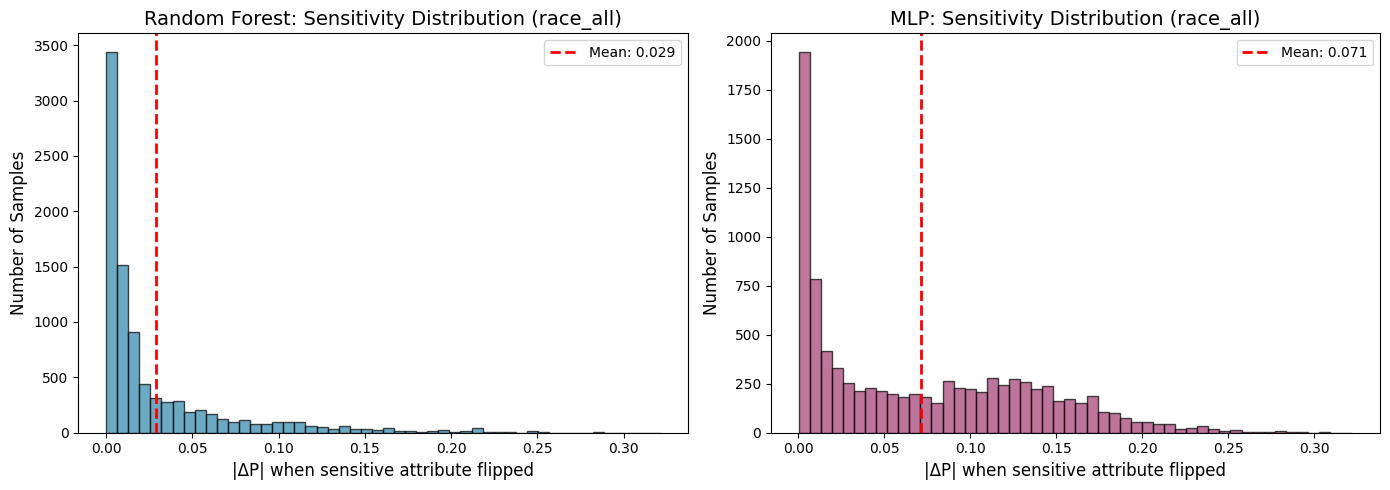

RF:  Mean |ΔP| = 0.0288, Max = 0.3209
MLP: Mean |ΔP| = 0.0713, Max = 0.3221


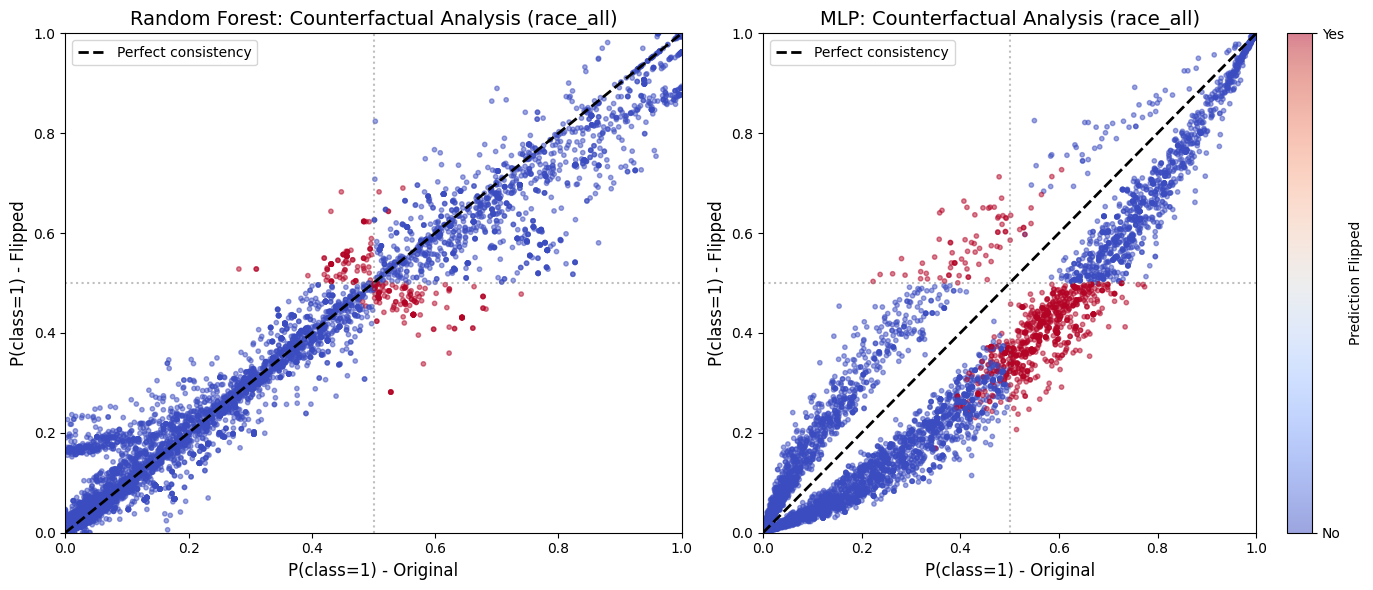

Blue = consistent (fair), Red = prediction flipped (unfair)
Points in upper-left/lower-right quadrants crossed the decision boundary
(For multiclass: showing probability change to max-change target category)


In [124]:
# 1.2.6h - Visualizations
plot_case_study_visualizations(cs_race, DATASET_NAME, SENSITIVE_FEATURE_RACE, OUTPUT_DIR)

---

# Approach 2: Models WITHOUT Sensitive Features + SenSeI

In this section, we compare models trained **without sensitive features** (sex, race removed):

**Models compared:**
1. **Random Forest** - trained without sex/race, evaluated on proxy
2. **MLP** - trained without sex/race, evaluated on proxy  
3. **SenSeI** - IBM's individual fairness model with Lipschitz constraint

**Key differences from Approach 1:**
- Sensitive features (sex_Male, race_White) are **removed** from all models
- SenSeI uses these removed features to learn a **fair distance metric**
- Counterfactual consistency is evaluated on **proxy feature** (`relationship_Wife`)

**Why relationship_Wife?**
- `relationship_Wife` is a strong proxy for gender (Wife → Female)
- This tests if models can still discriminate via correlated features
- This is the same evaluation metric IBM uses in their `inFairness` examples


In [42]:
# Import Approach 2 functions
from main import (
    main_approach2,
    run_optimization,
    SENSEI_AVAILABLE,
)

# Check if SenSeI is available
print("=" * 60)
print("APPROACH 2: Setup")
print("=" * 60)
print(f"SenSeI available: {SENSEI_AVAILABLE}")
if not SENSEI_AVAILABLE:
    print("⚠️  Install inFairness for SenSeI: pip install inFairness")
    print("   Will run RF and MLP without SenSeI comparison")


APPROACH 2: Setup
SenSeI available: True


In [64]:
# Approach 2 Configuration
DATASET_NAME_A2 = "adult"
SENSITIVE_FEATURES_TO_REMOVE = ["sex", "race"]  # Features to remove from training
PROXY_FEATURE = "relationship"  # Proxy for counterfactual (uses relationship_Wife)

# Use same time limits as Approach 1
WALLTIME_LIMIT_A2 = 600
N_TRIALS_A2 = 150

# Whether to include SenSeI (set to False to skip if it's slow or unavailable)
INCLUDE_SENSEI = SENSEI_AVAILABLE

print("=" * 60)
print("APPROACH 2 Configuration")
print("=" * 60)
print(f"  Dataset: {DATASET_NAME_A2}")
print(f"  Sensitive features REMOVED: {SENSITIVE_FEATURES_TO_REMOVE}")
print(f"  Proxy feature for counterfactual: {PROXY_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT_A2}s")
print(f"  Max trials per model: {N_TRIALS_A2}")
print(f"  Include SenSeI: {INCLUDE_SENSEI}")


APPROACH 2 Configuration
  Dataset: adult
  Sensitive features REMOVED: ['sex', 'race']
  Proxy feature for counterfactual: relationship
  Time limit per model: 600s
  Max trials per model: 150
  Include SenSeI: True


In [65]:
# Load dataset for Approach 2 (without sensitive features)
data_a2 = load_dataset(
    DATASET_NAME_A2,
    approach=2,
    sensitive_features_to_remove=SENSITIVE_FEATURES_TO_REMOVE,
    proxy_feature=PROXY_FEATURE,
)

print("\n" + "=" * 60)
print("APPROACH 2: Data Summary")
print("=" * 60)
print(f"  X_train shape: {data_a2['X_train'].shape}")
print(f"  y_train distribution: {np.bincount(data_a2['y_train'])}")
print(f"  Proxy column: {data_a2['proxy_col_name']} (index {data_a2['proxy_col_idx']})")
if data_a2['X_protected'] is not None:
    print(f"  X_protected shape: {data_a2['X_protected'].shape}")
    print(f"  Protected features: {data_a2['protected_feature_names']}")


Loading Adult Income from OpenML (ID: 179)...
APPROACH 2: Removing sensitive features from training
  Sensitive features to remove: ['sex', 'race']
  Proxy feature for counterfactual: relationship
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Protected features (for SenSeI): ['sex_Male', 'race_White']
Proxy column for counterfactual: relationship_Wife (index 35)

Final features (56): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 2):
  Samples: 45222, Features: 56
  Positive class ratio: 24.78%

APPROACH 2: Data Summary
  X_train shape: (45222, 56)
  y_train distribution: [34014 11208]
  Proxy column: relationship_Wife (index 35)
  X_protect

In [ ]:
%%time

# Run optimization for Approach 2 models OR load from cache
if LOAD_FROM_CACHE:
    print("Loading Approach 2 results from cache...")
    results_a2 = load_smac_results(DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)
else:
    print("Running SMAC optimization for Approach 2...")
    results_a2 = {}
    
    # Standard models without sensitive features
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()} (Approach 2 - No Sensitive Features)...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data_a2,
            walltime_limit=WALLTIME_LIMIT_A2 // 2,
            n_trials=N_TRIALS_A2 // 2,
            output_dir="../smac_output",
            approach=2,
        )
        results_a2[model_type] = smac
    
    # SenSeI (if available and requested)
    if INCLUDE_SENSEI:
        print(f"\n{'='*60}")
        print(f"Optimizing SenSeI (Approach 2 - Individual Fairness Training)...")
        print(f"{'='*60}")
        
        try:
            smac_sensei = run_optimization(
                model_type="sensei",
                data=data_a2,
                walltime_limit=WALLTIME_LIMIT_A2 * 2,
                n_trials=N_TRIALS_A2 * 2,
                output_dir="../smac_output",
                approach=2,
            )
            results_a2["sensei"] = smac_sensei
        except Exception as e:
            print(f"⚠️  SenSeI optimization failed: {e}")
            print("   Continuing with RF and MLP only.")
    
    print("\n" + "="*60)
    print("Approach 2 Optimization complete!")
    print(f"Models optimized: {list(results_a2.keys())}")
    print("="*60)
    
    # Save results to cache for future use
    save_smac_results(results_a2, DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)


Optimizing RF (Approach 2 - No Sensitive Features)...

Running SMAC optimization for RF (Approach 2)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:596] Added config 31471b and rejected config 5a799a as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 864316 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:604] Config 7e38f9 is a new incumbent. Total number of incumbents: 5.
[INFO][abstract

In [57]:
# Print Pareto summary for Approach 2
print_pareto_summary(results_a2)




PARETO FRONT SUMMARY

RF Pareto Front (8 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7693, Consistency=0.9838
  Config 2: Accuracy=0.7593, Consistency=0.9953
  Config 3: Accuracy=0.7591, Consistency=0.9960
  Config 4: Accuracy=0.7589, Consistency=0.9966
  Config 5: Accuracy=0.7576, Consistency=0.9977
  Config 6: Accuracy=0.7530, Consistency=0.9986
  Config 7: Accuracy=0.7318, Consistency=1.0000
  Config 8: Accuracy=0.7294, Consistency=1.0000

  Best Accuracy: 0.7693 (Consistency: 0.9838)
  Best Consistency: 1.0000 (Accuracy: 0.7294)

MLP Pareto Front (5 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7786, Consistency=0.9178
  Config 2: Accuracy=0.7780, Consistency=0.9315
  Config 3: Accuracy=0.7749, Consistency=0.9333
  Config 4: Accuracy=0.7739, Consistency=0.9583
  Config 5: Accuracy=0.5000, Consistency=1.0000

  Best Accuracy: 0.7786 (Consistency: 0.9178)
  Best Consistency: 1.0000 (Accuracy:

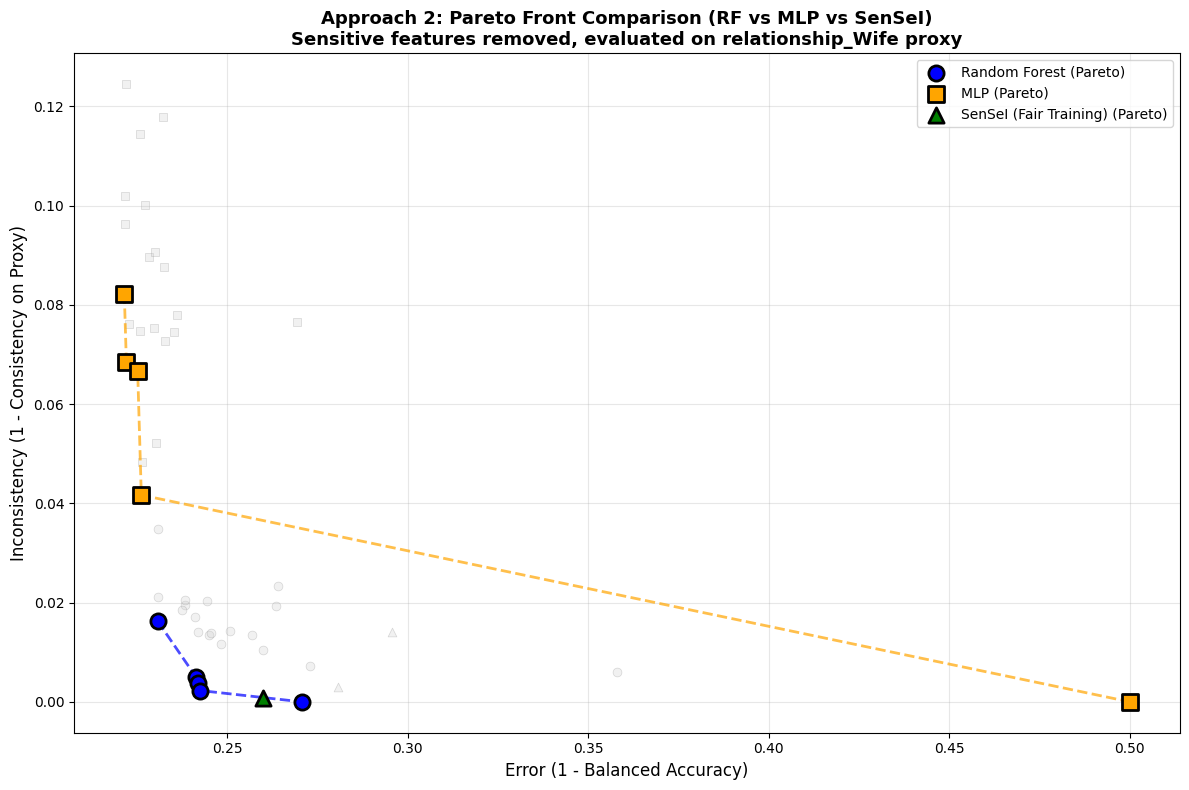

Plot saved to: ../plots/pareto_adult_approach2_with_sensei.png


In [70]:
# If SenSeI was optimized, create a combined Pareto plot including all 3 models
if "sensei" in results_a2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
    markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}
    labels = {'rf': 'Random Forest', 'mlp': 'MLP', 'sensei': 'SenSeI (Fair Training)'}
    
    for model_type, smac in results_a2.items():
        # Get Pareto front
        configs, pareto_costs = get_pareto_front(smac)
        
        # Get all costs
        all_costs = np.array([smac.runhistory.average_cost(c) 
                             for c in smac.runhistory.get_configs()])
        
        # Plot all points (faded)
        ax.scatter(
            all_costs[:, 0], all_costs[:, 1],
            c='lightgray', marker=markers[model_type],
            alpha=0.3, s=40, edgecolors='gray', linewidths=0.5,
            zorder=1
        )
        
        # Plot Pareto front (highlighted)
        ax.scatter(
            pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], marker=markers[model_type],
            s=120, edgecolors='black', linewidths=2,
            label=f'{labels[model_type]} (Pareto)',
            zorder=3
        )
        # Connect Pareto points
        ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
                c=colors[model_type], linestyle='--', linewidth=2, alpha=0.7, zorder=2)
    
    ax.set_xlabel('Error (1 - Balanced Accuracy)', fontsize=12)
    ax.set_ylabel('Inconsistency (1 - Consistency on Proxy)', fontsize=12)
    ax.set_title('Approach 2: Pareto Front Comparison (RF vs MLP vs SenSeI)\n'
                 'Sensitive features removed, evaluated on relationship_Wife proxy',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    sensei_pareto_path = f"{OUTPUT_DIR}/pareto_{DATASET_NAME_A2}_approach2_with_sensei.png"
    plt.savefig(sensei_pareto_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {sensei_pareto_path}")
else:
    print("SenSeI not included in results - skipping combined plot")


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_rf.png

Approach 2 - Random Forest Parallel Coordinate Plot:


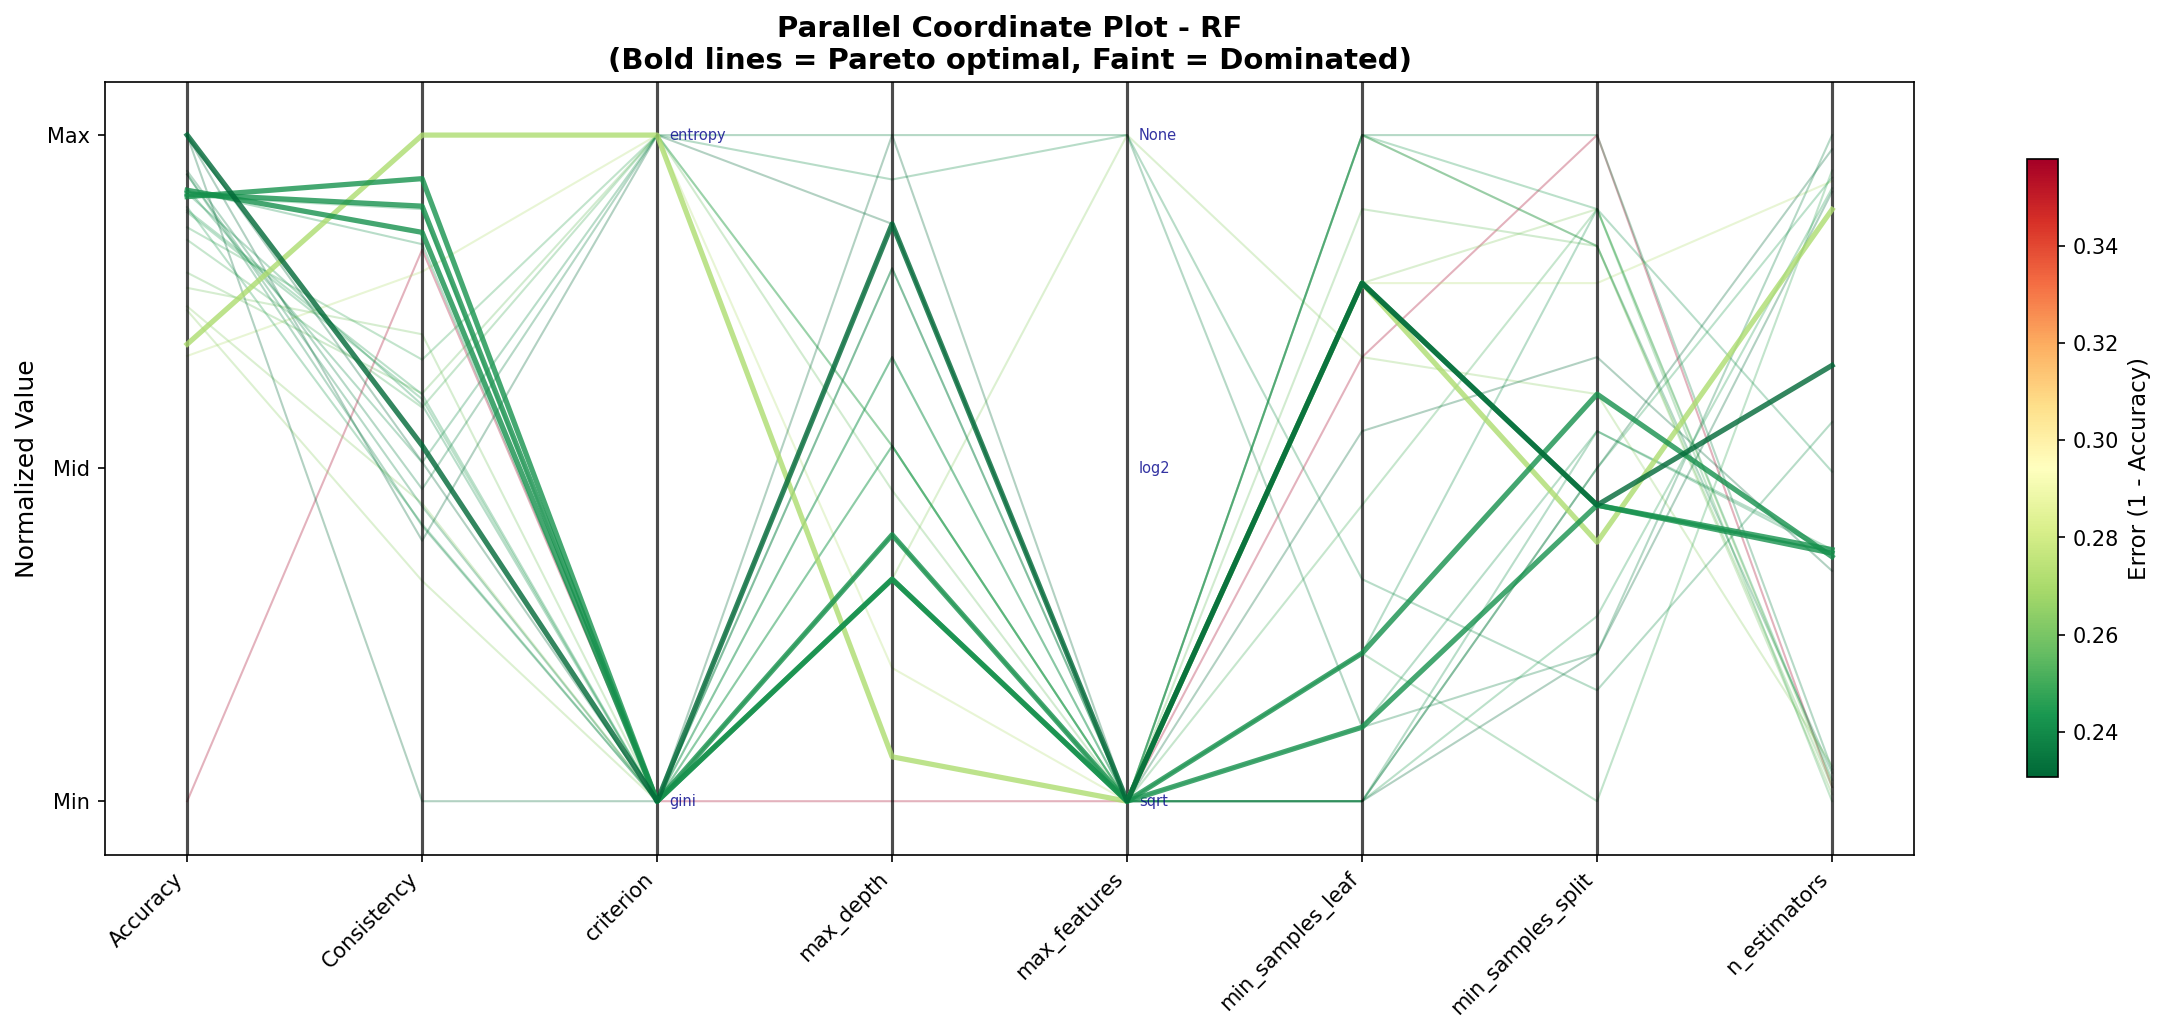

In [71]:
# Approach 2 - Random Forest Parallel Coordinates
rf_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_rf.png"
plot_parallel_coordinates(results_a2['rf'], 'rf', output_path=rf_parallel_path_a2, color_by='error')

print("\nApproach 2 - Random Forest Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_path_a2))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_mlp.png

Approach 2 - MLP Parallel Coordinate Plot:


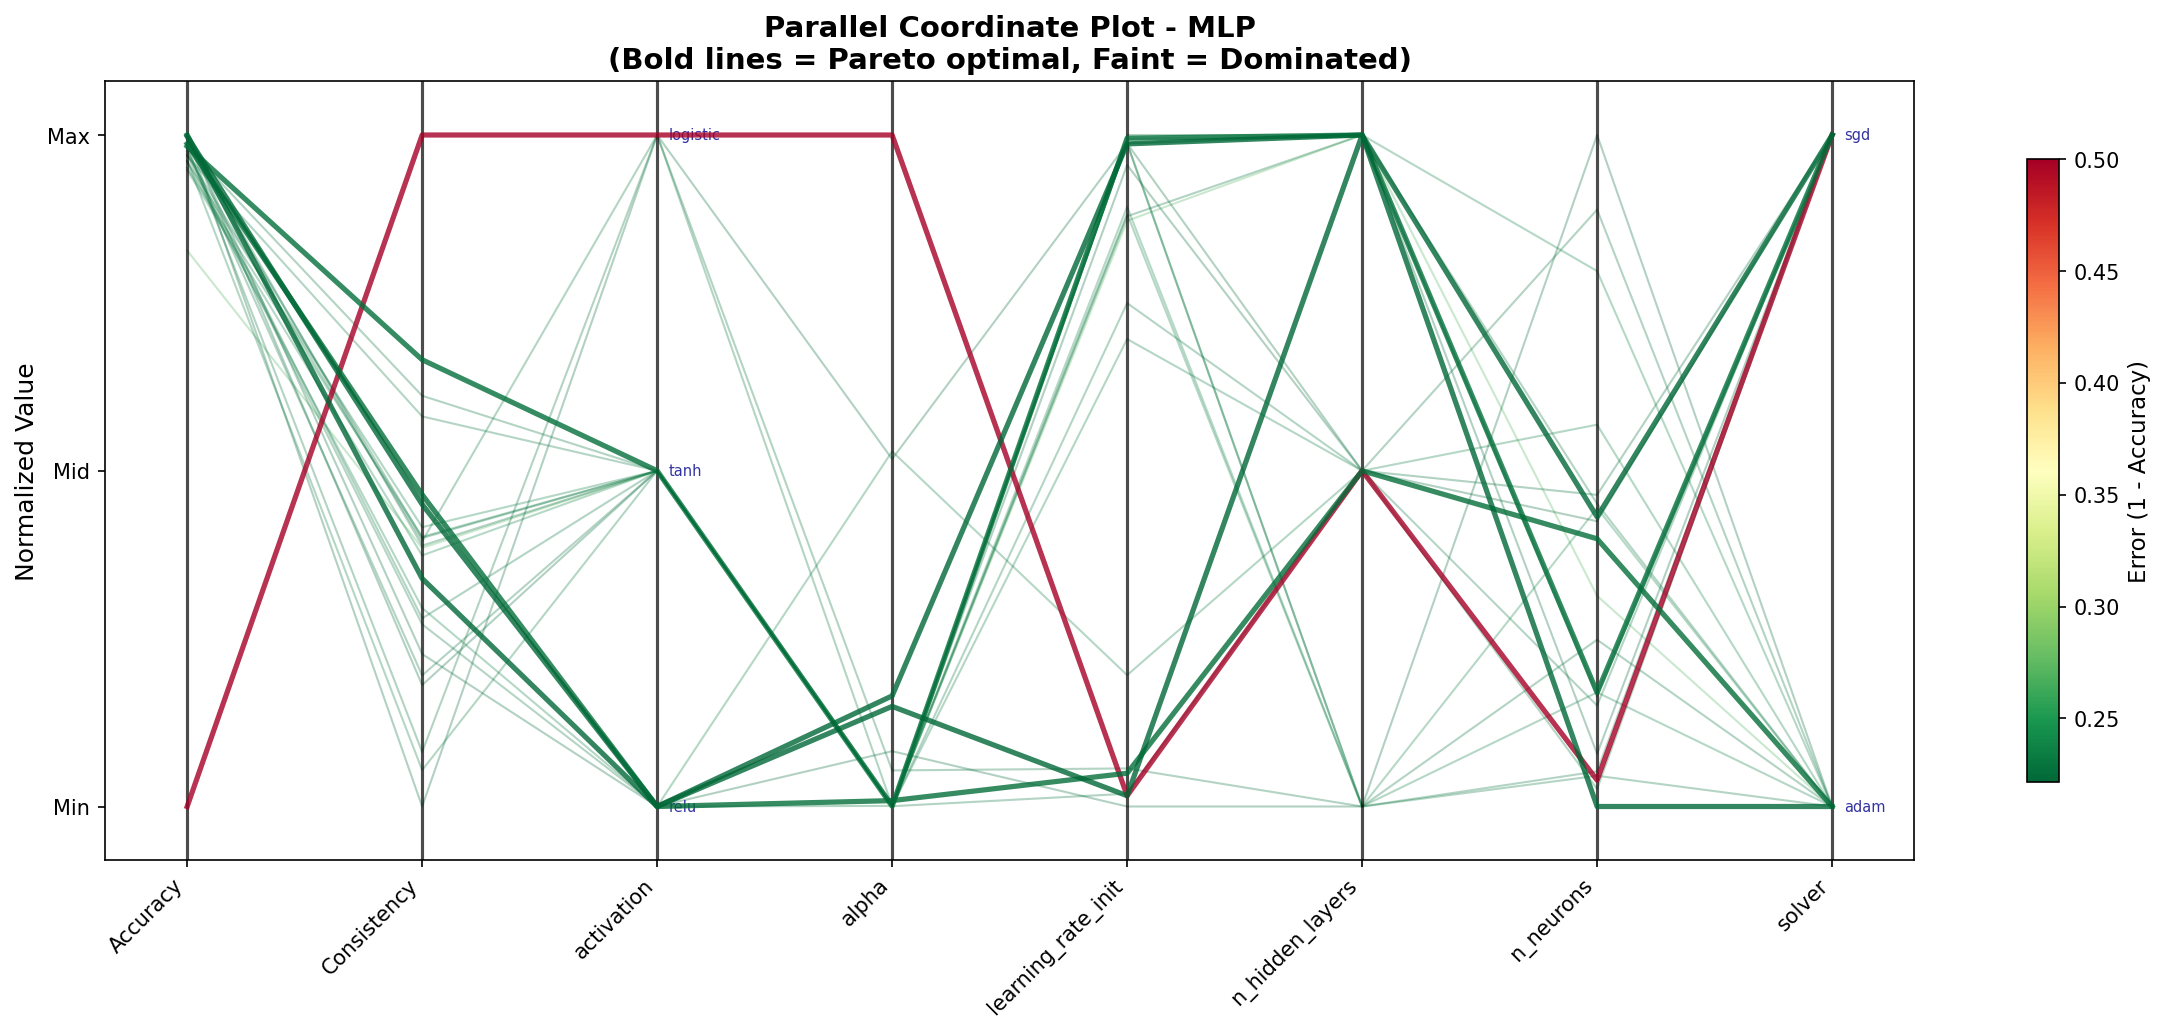

In [72]:
# Approach 2 - MLP Parallel Coordinates
mlp_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_mlp.png"
plot_parallel_coordinates(results_a2['mlp'], 'mlp', output_path=mlp_parallel_path_a2, color_by='error')

print("\nApproach 2 - MLP Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_path_a2))


MDS projection plot saved to: ../plots/mds_projection_adult_approach2_rf.png

Approach 2 - Random Forest MDS Projection:


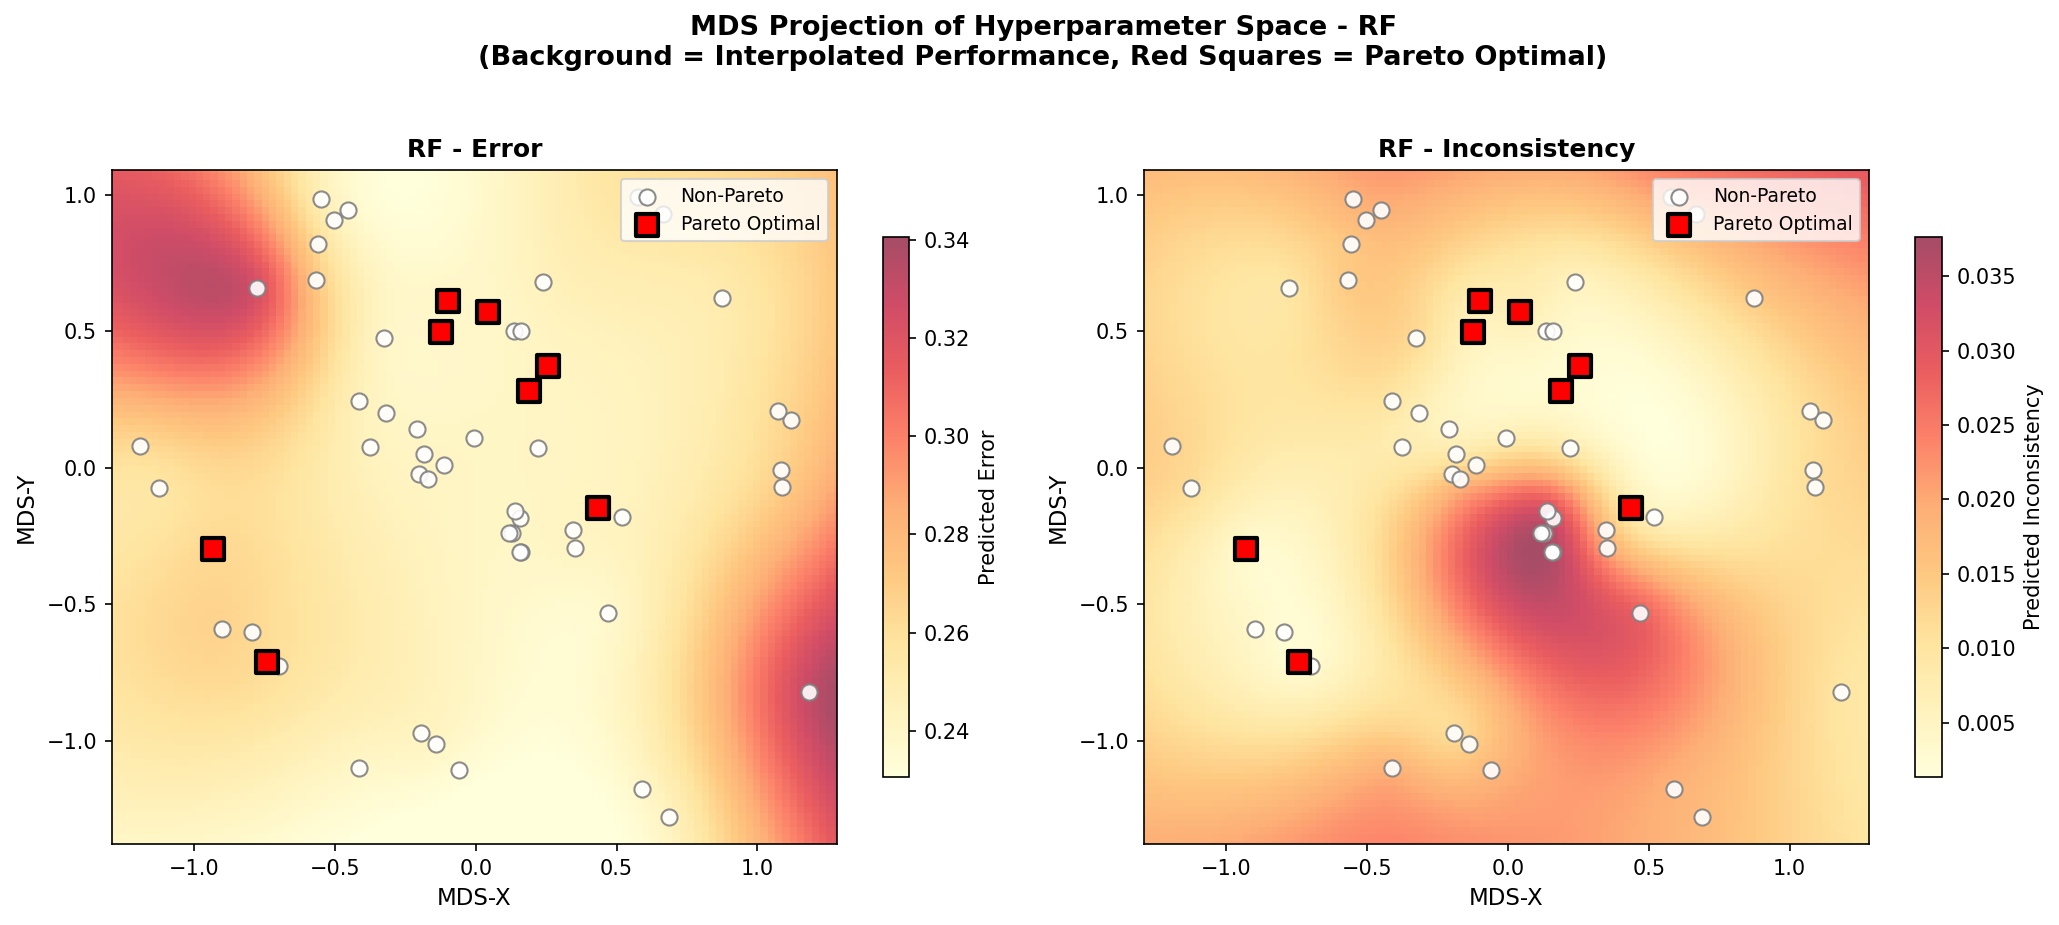

In [56]:
# Approach 2 - Random Forest MDS Projection
rf_mds_path_a2 = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME_A2}_approach2_rf.png"
plot_mds_projection(results_a2['rf'], 'rf', output_path=rf_mds_path_a2)

print("\nApproach 2 - Random Forest MDS Projection:")
display(Image(filename=rf_mds_path_a2))


## Approach 1 vs Approach 2: Comparison Summary

| Aspect | Approach 1 | Approach 2 |
|--------|-----------|-----------|
| **Sensitive features in model** | Yes (sex_Male, race_White) | No (removed) |
| **Counterfactual target** | Flip sex_Male directly | Flip relationship_Wife (proxy) |
| **Models compared** | RF, MLP | RF, MLP, SenSeI |
| **Fairness enforcement** | Post-hoc evaluation only | SenSeI: In-training enforcement |
| **Fair distance metric** | N/A | SenSeI uses LogisticRegSensitiveSubspace |

**Key questions this comparison answers:**
1. Does removing sensitive features improve fairness? (Compare RF/MLP Approach 1 vs Approach 2)
2. Does in-training fairness (SenSeI) outperform post-hoc evaluation? (Compare SenSeI vs RF/MLP)
3. Can models still discriminate via proxy features? (Approach 2 counterfactual results)


In [ ]:
# Compare best configurations from Approach 1 vs Approach 2
print("=" * 80)
print("COMPARISON: Approach 1 vs Approach 2 - Best Configurations")
print("=" * 80)

def get_best_configs(results_dict, approach_name):
    """Extract best accuracy and best fairness configs from results."""
    print(f"\n{approach_name}:")
    print("-" * 60)
    
    for model_type, smac in results_dict.items():
        configs, costs = get_pareto_front(smac)
        
        # Best accuracy
        best_acc_idx = np.argmin(costs[:, 0])
        best_acc = 1 - costs[best_acc_idx, 0]
        best_acc_cons = 1 - costs[best_acc_idx, 1]
        
        # Best consistency
        best_cons_idx = np.argmin(costs[:, 1])
        best_cons = 1 - costs[best_cons_idx, 1]
        best_cons_acc = 1 - costs[best_cons_idx, 0]
        
        print(f"\n  {model_type.upper()}:")
        print(f"    Best Accuracy:    Acc={best_acc:.4f}, Cons={best_acc_cons:.4f}")
        print(f"    Best Consistency: Acc={best_cons_acc:.4f}, Cons={best_cons:.4f}")

# # Approach 1 (with sensitive features, flip sex)
get_best_configs(results, "APPROACH 1 (With Sensitive Features, Flip Sex)")

# Approach 2 (without sensitive features, flip proxy)
get_best_configs(results_a2, "APPROACH 2 (Without Sensitive Features, Flip Proxy)")


COMPARISON: Approach 1 vs Approach 2 - Best Configurations

APPROACH 2 (Without Sensitive Features, Flip Proxy):
------------------------------------------------------------

  RF:
    Best Accuracy:    Acc=0.7693, Cons=0.9838
    Best Consistency: Acc=0.7294, Cons=1.0000

  MLP:
    Best Accuracy:    Acc=0.7786, Cons=0.9178
    Best Consistency: Acc=0.5000, Cons=1.0000

  SENSEI:
    Best Accuracy:    Acc=0.7403, Cons=0.9993
    Best Consistency: Acc=0.7403, Cons=0.9993


AttributeError: 'list' object has no attribute 'items'

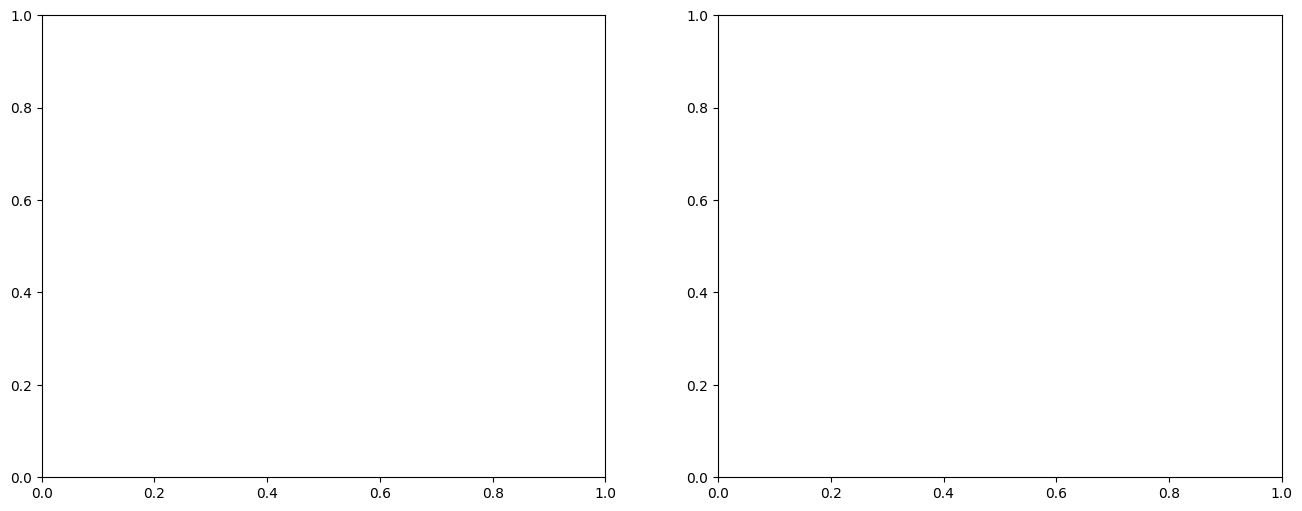

In [76]:
# Visual comparison: Approach 1 vs Approach 2 side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Common settings
colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}

# Plot Approach 1
ax = axes[0]
for model_type, smac in results.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 1: WITH Sensitive Features\n(Flip sex directly)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot Approach 2
ax = axes[1]
for model_type, smac in results_a2.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 2: WITHOUT Sensitive Features\n(Flip proxy: relationship_Wife)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Match axis limits for comparison
all_errors = []
all_incons = []
for res in [results, results_a2]:
    for smac in res.values():
        configs, costs = get_pareto_front(smac)
        all_errors.extend(costs[:, 0])
        all_incons.extend(costs[:, 1])

err_min, err_max = min(all_errors) - 0.02, max(all_errors) + 0.02
inc_min, inc_max = min(all_incons) - 0.02, max(all_incons) + 0.02

for ax in axes:
    ax.set_xlim(err_min, err_max)
    ax.set_ylim(inc_min, inc_max)

plt.suptitle('Comparison: Approach 1 vs Approach 2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comparison_approach1_vs_approach2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: {OUTPUT_DIR}/comparison_approach1_vs_approach2.png")
